# Dragonfly registration
While other tasks used standard emlddmm, this setup has a different geometry which requires a more involved setup.

Brain is cut into adjacent slabs.  Each slab deforms and shrinks/shifts/translates.  

We will use a version of projection LDDMM for this.




In version 00, we just do one forward pass, and one reconstruction of the slices

nothing nonlinear.  Everything looks nice so far and we have a reasonable initialization.

note that I may need a smaller voxel size, so we can really see the end of the slices


in v01 I will start optimizing

Next I will add nonlinaer

Some notes.
I think I will need to pad J so that there is some contrast at the ends

In version 2 I add a fixed translation to each slice, just like a fixed trapezoid sampling

in version 4 I add deformation to each slab, less smooth

In [1]:
# note, I'm pretty sure that 07 is also backwards

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join
import time

import imp
import donglab_workflows as dw
imp.reload(dw)

import torch
import time

In [3]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [4]:
# where should outputs go?
output_prefix = 'dragonfly_atlas_outputs_v04/'

In [5]:
# we will start by loading the data

In [6]:
# load atlas images
atlas_names = [
    '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk',
    '/home/dtward/data/AllenInstitute/allen_vtk/average_template_50.vtk',
]
seg_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'

In [7]:
target_dir = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/'

target_pattern = '*10x*channel_1_*.npz'
target_pattern = '*10x*channel_0_*.npz'

In [8]:
I = []
for atlas_name in atlas_names:
    xI,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))
    I.append(I_)
    
I = np.concatenate(I)   
I[0] = I[0]**0.25
I[0] /= np.mean(np.abs(I_[0]))
dI = np.array([x[1] - x[0] for x in xI])
XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)

In [9]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [10]:
target_files = glob(join(target_dir,target_pattern))
target_files.sort()

In [11]:
# one of the slab is weirdly separated
target_files = target_files[1:]

In [12]:
# load the data
Js = []
xJs = []
Ws = []
dJs = []
DJs = []
for fname in target_files:
    data = np.load(fname,allow_pickle=True)
    Js.append(data['I'][None])    
    xJs.append(data['xI'])
    Ws.append(data['W'])
    
    
    # we need to normalize to [0,1]
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.01)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    # I'd like to squash the bright signal
    Js[-1][Js[-1]>=0] = Js[-1][Js[-1]>=0]**0.25
    Js[-1][Js[-1]<0] = -np.abs(Js[-1][Js[-1]<0])**0.25
    
    # we need to normalize to [0,1] again!
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.01)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    dJs.append([x[1]-x[0] for x in xJs[-1]])
    DJs.append(np.prod(dJs[-1]) )
    

<IPython.core.display.Javascript object>


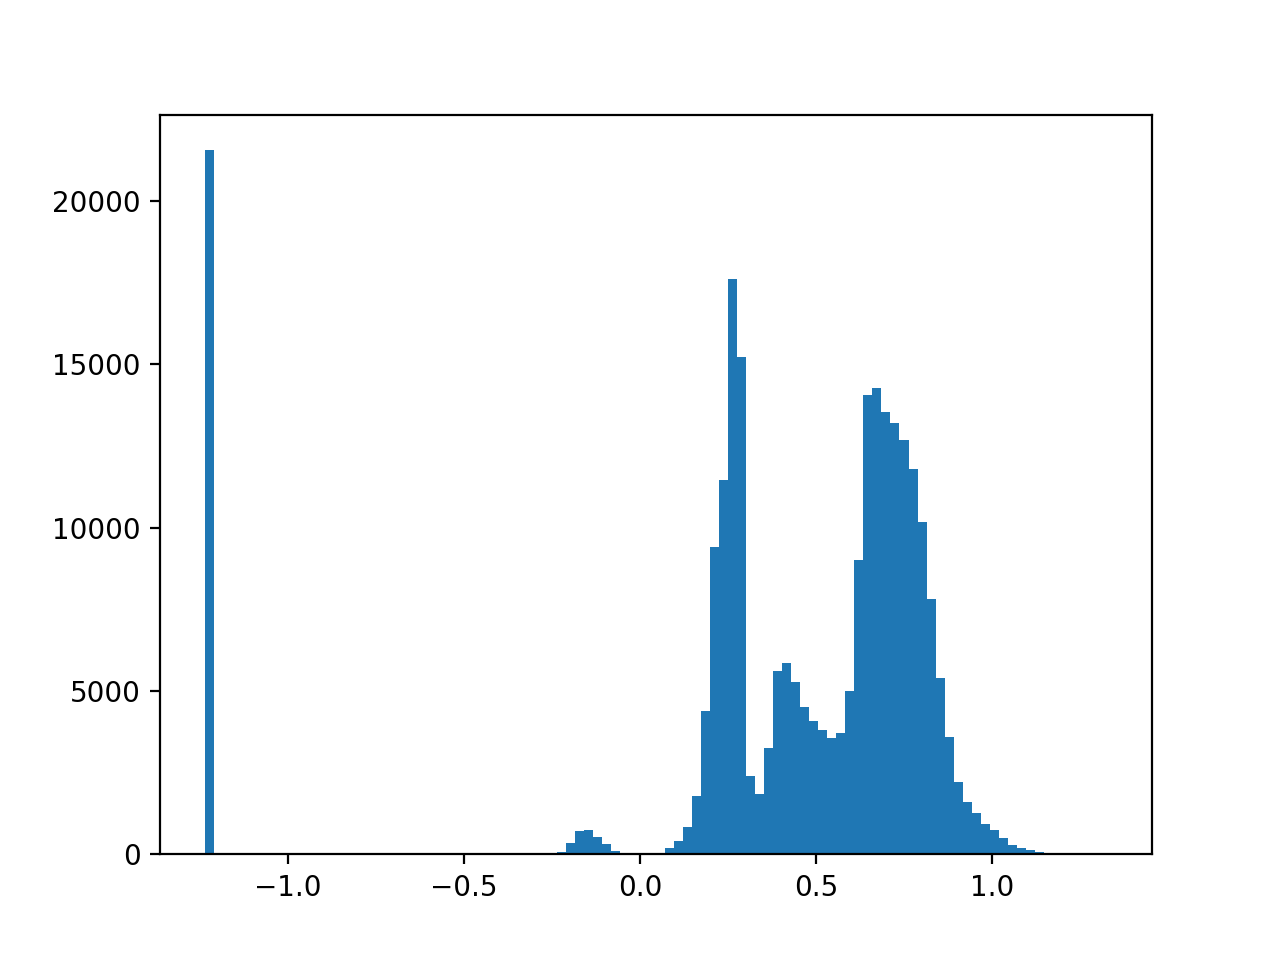

(array([2.1536e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+01, 5.9000e+01,
        3.3600e+02, 7.0400e+02, 7.5200e+02, 5.3900e+02, 3.1600e+02,
        1.1800e+02, 3.7000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+01,
        5.3000e+01, 1.9300e+02, 3.9500e+02, 8.4700e+02, 1.7730e+03,
        4.3740e+03, 9.3990e+03, 1.1454e+04, 1.7596e+04, 1.5222e+04,
        2.4070e+03, 1.8430e+03, 3.2580e+03, 5.6110e+03, 5.8620e+03,
        5.2840e+03, 4.5220e+03, 4.0800e+03, 3.7940e+03, 3.5600e+03,
        3.7070e+03, 5.0010e+03, 9.0210e+03, 1.40

In [13]:
f,ax = plt.subplots()
ax.hist(Js[-1].ravel(),100)

In [14]:
# I want to pad everything 
for i in range(len(Js)):
    Ji = Js[i]
    Wi = Ws[i]
    xJi = xJs[i]
    dJi = dJs[i]
    
    # find the 1% quantile
    val = np.quantile(Ji[Wi[None]>=0.99],0.05)
    npad = 2
    Ji = np.pad(Ji,((0,0),(npad,npad),(0,0),(0,0)), constant_values=val)
    Wi = np.pad(Wi,((npad,npad),(0,0),(0,0)), constant_values=1.0)
    for j in range(npad):
        xJi[0] = np.concatenate((xJi[0][0][None]-dJi[0], xJi[0], xJi[0][-1][None]+dJi[0]))
    
    Js[i] = Ji
    Ws[i] = Wi
    xJs[i] = xJi
    

<IPython.core.display.Javascript object>


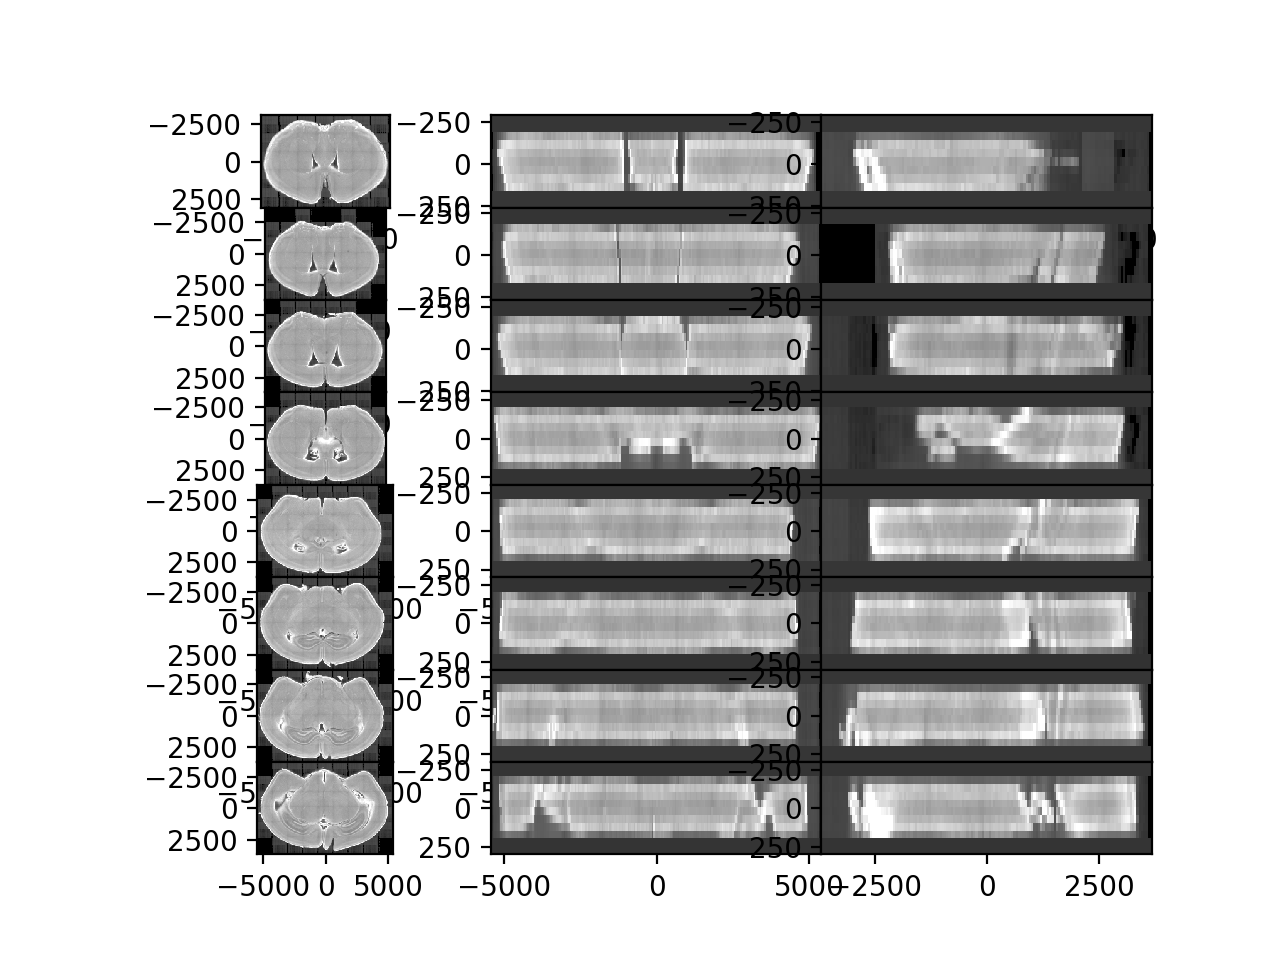

<IPython.core.display.Javascript object>


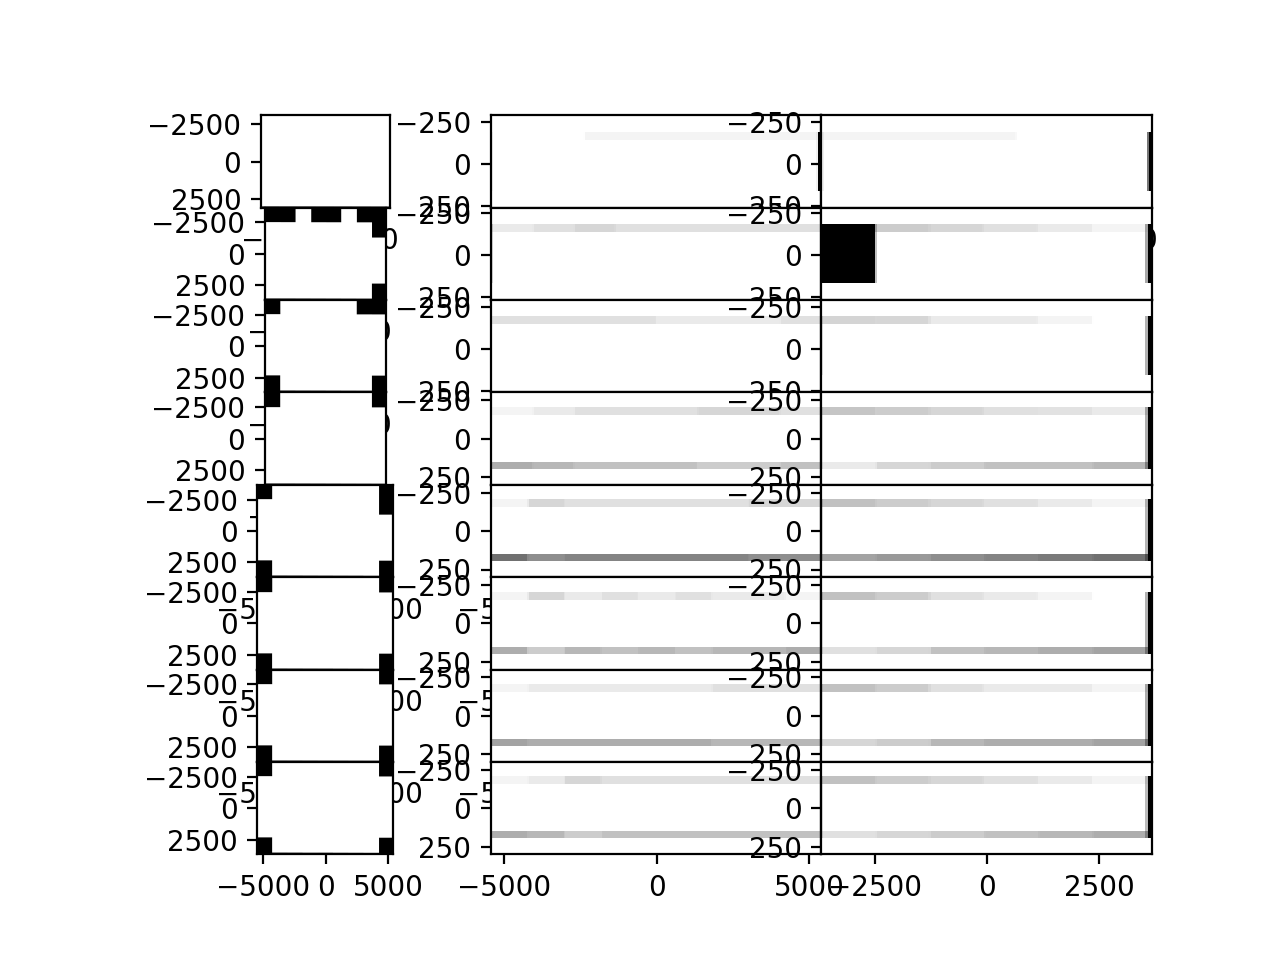

In [15]:
def clip(I):
    I = np.copy(I)
    I[I<0] = 0
    I[I>1] = 1
    return I
def draw_stack(Js,xJs,fig=None,**kwargs):
    '''
    stack is on the first axis
    note there is an issue with sharex and removing the axis labels
    also an issue cause the images are different number of slices
    Not using now
    TODO: make sure this will work with numpy or torch
    avoid copying too much

    '''
    #print(kwargs)
    if 'vmin' in kwargs:
        vmin = kwargs.pop('vmin')
    else:
        vmin = np.min([np.min(np.array(J)) for J in Js])
    if 'vmax' in kwargs:
        vmax = kwargs.pop('vmax')
    else:
        vmax = np.min([np.max(np.array(J)) for J in Js])    
    
    
    
    n = len(Js)
    if fig is None:
        figsize = (5,10)
        figsize = None
        fig = plt.figure(figsize=figsize)
    else:
        fig.clf()
    
    
    for i in range(n):
        if i == 0:
            ax0 = fig.add_subplot(n,3,3*i+1)
            ax = ax0
        else:
            ax0 = None
            ax = fig.add_subplot(n,3,3*i+1,sharex=ax0,sharey=ax0)
            
        toshow = np.array(Js[i][:,Js[i].shape[1]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        xJ = xJs[i]
        dJ = [x[1]-x[0] for x in xJ]
        extent = (xJ[-1][0]-dJ[-1]*0.5,xJ[-1][-1]+dJ[-1]*0.5,
                 xJ[-2][-1]+dJ[-2]*0.5,xJ[-2][0]-dJ[-2]*0.5)
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        #if i < n-1:
        #    ax.set_xticks([])
        
        
        
        if i == 0:
            ax1 = fig.add_subplot(n,3,3*i+2)
            ax = ax1
        else:
            ax1 = None
            ax = fig.add_subplot(n,3,3*i+2,sharex=ax1,sharey=ax1)
        toshow = np.array(Js[i][:,:,Js[i].shape[2]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        
        
        extent = (xJ[-1][0]-dJ[-1]*0.5,xJ[-1][-1]+dJ[-1]*0.5,
                 xJ[-3][-1]+dJ[-3]*0.5,xJ[-3][0]-dJ[-3]*0.5)        
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        ax.set_aspect('auto')
        #if i < n-1:
        #    ax.set_xticks([])
        
        
        if i == 0:
            ax2 = fig.add_subplot(n,3,3*i+3)
            ax = ax2
        else:
            ax2 = None
            ax = fig.add_subplot(n,3,3*i+3,sharex=ax2,sharey=ax2)
        toshow = np.array(Js[i][:,:,:,Js[i].shape[3]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)            
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        extent = (xJ[-2][0]-dJ[-2]*0.5,xJ[-2][-1]+dJ[-2]*0.5,
                 xJ[-3][-1]+dJ[-3]*0.5,xJ[-3][0]-dJ[-3]*0.5)
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        ax.set_aspect('auto')
        #if i < n-1:
        #    ax.set_xticks([])
        plt.subplots_adjust(wspace=0,hspace=0)
        
    return fig,None # later I will return ax
        
vminJ = 100.0
vmaxJ = 115.0
vmaxJ = 130 # for channel 0
vminJ = 0.0
vmaxJ = 1.0

fig,ax = draw_stack(Js,xJs,vmin=vminJ,vmax=vmaxJ)
fig.canvas.draw()
fig,ax = draw_stack([w[None] for w in Ws],xJs,vmin=0,vmax=1)
    
    

In [16]:
# now we have to firm up the model
# as usual, I will start with just linear
# then I'll add the projection step


In [17]:
# lets convert to torch

In [18]:
Inp = np.copy(I)
xInp = [np.copy(x) for x in xI]
Jnp = [np.copy(Ji) for Ji in Js]
xJnp = [[np.copy(x) for x in xJ] for xJ in xJs]
Wnp = [np.copy(Wi) for Wi in Ws]

In [19]:
device = 'cpu'
device = 'cuda:1'
dtype = torch.float64
I = torch.tensor(Inp,device=device,dtype=dtype)
xI = [torch.tensor(x,device=device,dtype=dtype) for x in xInp]
J = [torch.tensor(Ji,device=device,dtype=dtype) for Ji in Jnp]
W = [torch.tensor(Wi,device=device,dtype=dtype) for Wi in Wnp]
xJ = [[torch.tensor(x,device=device,dtype=dtype) for x in xJi] for xJi in xJnp]
XJ = [ torch.stack(torch.meshgrid(x[0],x[1],x[2],indexing='ij'),-1) for x in xJ]
# note I'm stacking at the end
# I think I may have to stack at the start
XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)

In [20]:
# lets build a trapezoid function
dslice = 500.0 # 500 micron slices
def trapezoid(x,i):
    # if it is in the middle
    d = torch.abs(x - (i - (len(J)-1)/2.0)*dslice)
    out = (d < dslice/2.0)*1.0 + (d >= dslice/2.0)*(d < dslice/2.0+dI[0])*(1.0 - (d-dslice/2.0)/dI[0])    
    return out
def trapezoid(x,i):
    # if it is in the middle
    d = torch.abs(x - (i - (len(J)-1)/2.0)*dslice)
    out = (d < dslice/2.0 - dI[0])*1.0 + (d >= dslice/2.0 - dI[0])*(d < dslice/2.0+dI[0])*(1.0 - (d-dslice/2.0)/dI[0])*0.5
    return out
# I want the edge to be at 0.5, and take one voxel to go up or down
t = torch.linspace(-3000,3000,1000)
f,ax = plt.subplots()
ax.plot(t,trapezoid(t,2))

<IPython.core.display.Javascript object>

In [21]:
DI = torch.prod(torch.tensor(dI,device=device,dtype=dtype))

In [22]:
W_ = (I[0] > 0).to(dtype)
DW = torch.stack(torch.gradient(W_,spacing=dI.tolist(),dim=(0,1,2)),-1)
emlddmm.draw(DW.permute(-1,0,1,2))

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fa2ec652ed0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fa2f164ac90>]])

In [23]:
gid = torch.zeros(12,12,device=device,dtype=dtype)

count0 = 0
for i0 in range(3):
    for j0 in range(4):
        E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
        if j0 == 3:
            tosum0 = DW[...,i0]
        else:
            tosum0 = DW[...,i0]*XI[...,j0]
            
        count1 = 0
        for i1 in range(3):
            for j1 in range(4):
                if count0 > count1:
                    count1 += 1
                    continue                                
                E1 = ((torch.arange(4,device=device,dtype=dtype)==i1)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j1)[None,:]).to(dtype)                
                if j1 == 3:
                    tosum1 = DW[...,i1]
                else:
                    tosum1 = DW[...,i1]*XI[...,j1]
                                                            
                gid[count0,count1] = torch.sum(tosum0*tosum1)*DI
                gid[count1,count0] = gid[count0,count1]                                
                
                count1 += 1
        count0 += 1

In [24]:
def small_to_big(a):
    '''
    Convert A to a big linear map that acts on a vectorized matrix
    We compute it through its action on basis vectors
    '''
    
    A = torch.zeros(12,12,dtype=a.dtype,device=a.device)
    device = a.device
    dtype = a.dtype
    count0 = 0
    for i0 in range(3):
        for j0 in range(4):
            E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
            
            A[:,count0] = (a@E0)[:3,:4].ravel()
            count0 += 1
    return A


In [25]:
def gA_from_gid(gid,A):
    # we need to convert A to a 12x12 map
    A_ = small_to_big(torch.linalg.inv(A))
    gA = A_.T@gid@A_
    return gA
    

In [26]:
# now we need to do the same for gJ
# but these will change
# so instead we'll just do this
Jind = len(XJ)//2
W_ = torch.ones_like(XJ[Jind][...,0])
border = 2
W_[:border] = 0.0
W_[-border:] = 0.0
W_[:,:border] = 0.0
W_[:,-border:] = 0.0
W_[:,:,:border] = 0.0
W_[:,:,-border:] = 0.0


DW = torch.stack(torch.gradient(W_,spacing=dI.tolist(),dim=(0,1,2)),-1)
emlddmm.draw(DW.permute(-1,0,1,2))

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fa2f15d3cd0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fa2f1281a50>]])

In [27]:
gJid = torch.zeros(12,12,device=device,dtype=dtype)

count0 = 0
for i0 in range(3):
    for j0 in range(4):
        E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
        if j0 == 3:
            tosum0 = DW[...,i0]
        else:
            tosum0 = DW[...,i0]*XJ[Jind][...,j0]
            
        count1 = 0
        for i1 in range(3):
            for j1 in range(4):
                if count0 > count1:
                    count1 += 1
                    continue                                
                E1 = ((torch.arange(4,device=device,dtype=dtype)==i1)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j1)[None,:]).to(dtype)                
                if j1 == 3:
                    tosum1 = DW[...,i1]
                else:
                    tosum1 = DW[...,i1]*XJ[Jind][...,j1]
                                                            
                gJid[count0,count1] = torch.sum(tosum0*tosum1)*DJs[Jind]
                gJid[count1,count0] = gJid[count0,count1]                                
                
                count1 += 1
        count0 += 1

In [28]:
f,ax = plt.subplots(1,2)
ax[0].imshow(gid.cpu())
ax[1].imshow(gJid.cpu())

<IPython.core.display.Javascript object>

In [29]:
# set up kernels
dv = torch.tensor([1.0,1.0,1.0],device=device,dtype=dtype)*500.0
DV = torch.prod(dv)
dI = torch.tensor(dI,device=device,dtype=dtype)
v_expand_factor = 0.1
a = 500.0
p = 2.0
aprefactor = 0.25
nt = 5

print(f'a scale is {a}')
x0v = [x[0] - (x[-1]-x[0])*v_expand_factor for x in xI]
x1v = [x[-1] + (x[-1]-x[0])*v_expand_factor for x in xI]
xv = [torch.arange(x0,x1,d,device=device,dtype=dtype) for x0,x1,d in zip(x0v,x1v,dv)]
nv = torch.tensor([len(x) for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)

# build energy operator for velocity
fv = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nv,dv)]
FV = torch.stack(torch.meshgrid(fv))

LL = (1.0 - 2.0*a**2 * 
          ( (torch.cos(2.0*np.pi*FV[0]*dv[0]) - 1)/dv[0]**2  
        + (torch.cos(2.0*np.pi*FV[1]*dv[1]) - 1)/dv[1]**2  
        + (torch.cos(2.0*np.pi*FV[2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
K = 1.0/LL

LLpre = (1.0 - 2.0*(aprefactor*torch.max(dI))**2 * 
         ( (torch.cos(2.0*np.pi*FV[0]*dv[0]) - 1)/dv[0]**2  
         + (torch.cos(2.0*np.pi*FV[1]*dv[1]) - 1)/dv[1]**2  
         + (torch.cos(2.0*np.pi*FV[2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
Kpre = 1.0/LLpre
KK = K*Kpre



a scale is 500.0


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [30]:
# set up kernels for blocks
dvJ = torch.tensor([1.0,1.0,1.0],device=device,dtype=dtype)*100.0
DVJ = torch.prod(dvJ)
v_expand_factor = 0.1
aJ = 50.0
pJ = 2.0
aprefactorJ = 0.25
ntJ = 3

print(f'aJ scale is {aJ}')
LLJ = []
KJ = []
KJpre = []
XVJ = []
xvJ = []
for i in range(len(J)):
    x0vJ = [x[0] - (x[-1]-x[0])*v_expand_factor for x in xJs[i]]
    x1vJ = [x[-1] + (x[-1]-x[0])*v_expand_factor for x in xJs[i]]    
    xvJi = [torch.arange(x0,x1,d,device=device,dtype=dtype) for x0,x1,d in zip(x0vJ,x1vJ,dvJ)]
    nvJi = torch.tensor([len(x) for x in xvJi],device=device,dtype=dtype)
    XVJi = torch.stack(torch.meshgrid(xvJi),-1)

    
    
    # build energy operator for velocity
    fvJi = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nvJi,dvJ)]
    FVJi = torch.stack(torch.meshgrid(fvJi))

    LLJi = (1.0 - 2.0*aJ**2 * 
            ( (torch.cos(2.0*np.pi*FVJi[0]*dvJ[0]) - 1)/dvJ[0]**2  
            + (torch.cos(2.0*np.pi*FVJi[1]*dvJ[1]) - 1)/dvJ[1]**2  
            + (torch.cos(2.0*np.pi*FVJi[2]*dvJ[2]) - 1)/dvJ[2]**2   ) )**(pJ*2)
    KJi = 1.0/LLJi

    LLpreJi = (1.0 - 2.0*(aprefactorJ*torch.max(dI))**2 * 
             ( (torch.cos(2.0*np.pi*FVJi[0]*dvJ[0]) - 1)/dvJ[0]**2  
             + (torch.cos(2.0*np.pi*FVJi[1]*dvJ[1]) - 1)/dvJ[1]**2  
             + (torch.cos(2.0*np.pi*FVJi[2]*dvJ[2]) - 1)/dvJ[2]**2   ) )**(pJ*2)
    KpreJi = 1.0/LLpreJi
    KKJi = KJi*KpreJi

    LLJ.append(LLJi)
    KJ.append(KJi)
    KJpre.append(KpreJi)
    XVJ.append(XVJi)
    xvJ.append(xvJi)

aJ scale is 50.0


In [31]:
# initialize params
# 3D
A = torch.eye(4,device=device,dtype=dtype) # no
A = torch.tensor([[0.0,1.0,0.0,0.0],
                 [1.0,0.0,0.0,0.0],
                 [0.0,0.0,1.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) # no
A = torch.tensor([[-1.0,0.0,0.0,2000.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) # good

A = torch.tensor([[-1.0,0.0,0.0,1000.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) # for ventricles
# this one seems to match ventricles well
# final energy after 20k iter: 2.3158e+10

# a test
A = torch.tensor([[-1.0,0.0,0.0,500.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) 
# this one (above) seemed to match dentate well
# got to E 2.3647e+10 after 20K iterations, this is definitely higher than the above
'''
A = torch.tensor([[-1.0,0.0,0.0,0.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) 
'''
# ok it does climb up toward 1000, but it is very slow, initialization is still important

# per slice, note translations 
# these take the slices and move them to be zero centered
TJ = [torch.tensor([[1.0,0.0,0.0,-(i - (len(J)-1)/2.0)*dslice],
                   [0.0,1.0,0.0,0.0],
                   [0.0,0.0,1.0,0.0],
                   [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) for i in range(len(J))]
AJi = [torch.tensor([[1.0,0.0,0.0,0.0],
                   [0.0,1.0,0.0,0.0],
                   [0.0,0.0,1.0,0.0],
                   [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) for i in range(len(J))]

AJi = torch.stack(AJi)
#AJi[1:6][0,0] = AJi[1:6][0,0]*(-1)
#AJi[1:6][1,1] = AJi[1:6][1,1]*(-1)

if len(J) == 8:
    for i in range(0,5): # after I cut off the first
        AJi[i][0,0] = AJi[i][0,0]*(-1)
        AJi[i][2,2] = AJi[i][2,2]*(-1) # left right
elif len(J) == 9:
    for i in range(1,6):
        print(i)
        print(target_files[i])
        AJi[i][0,0] = AJi[i][0,0]*(-1)
        AJi[i][2,2] = AJi[i][2,2]*(-1) # left right
else:
    raise Exeption(f'No initialization when len(J) is {len(J)}')
#print(AJi)
AJ = torch.linalg.inv(AJi)

v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
vJ = [torch.zeros((ntJ,KJ[i].shape[0],KJ[i].shape[1],KJ[i].shape[2],3),device=device,dtype=dtype,requires_grad=True) for i in range(len(J))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


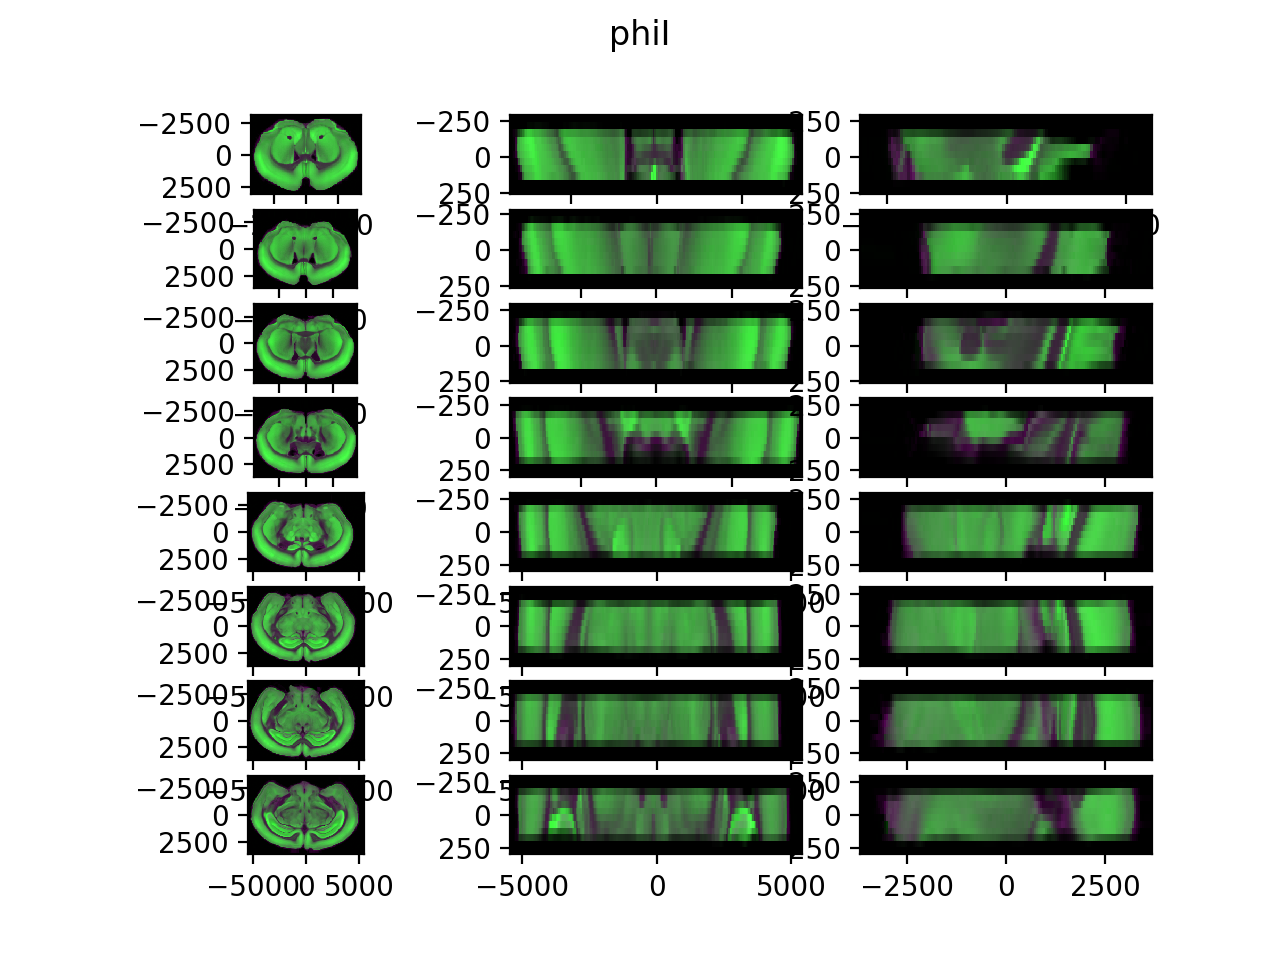

<IPython.core.display.Javascript object>


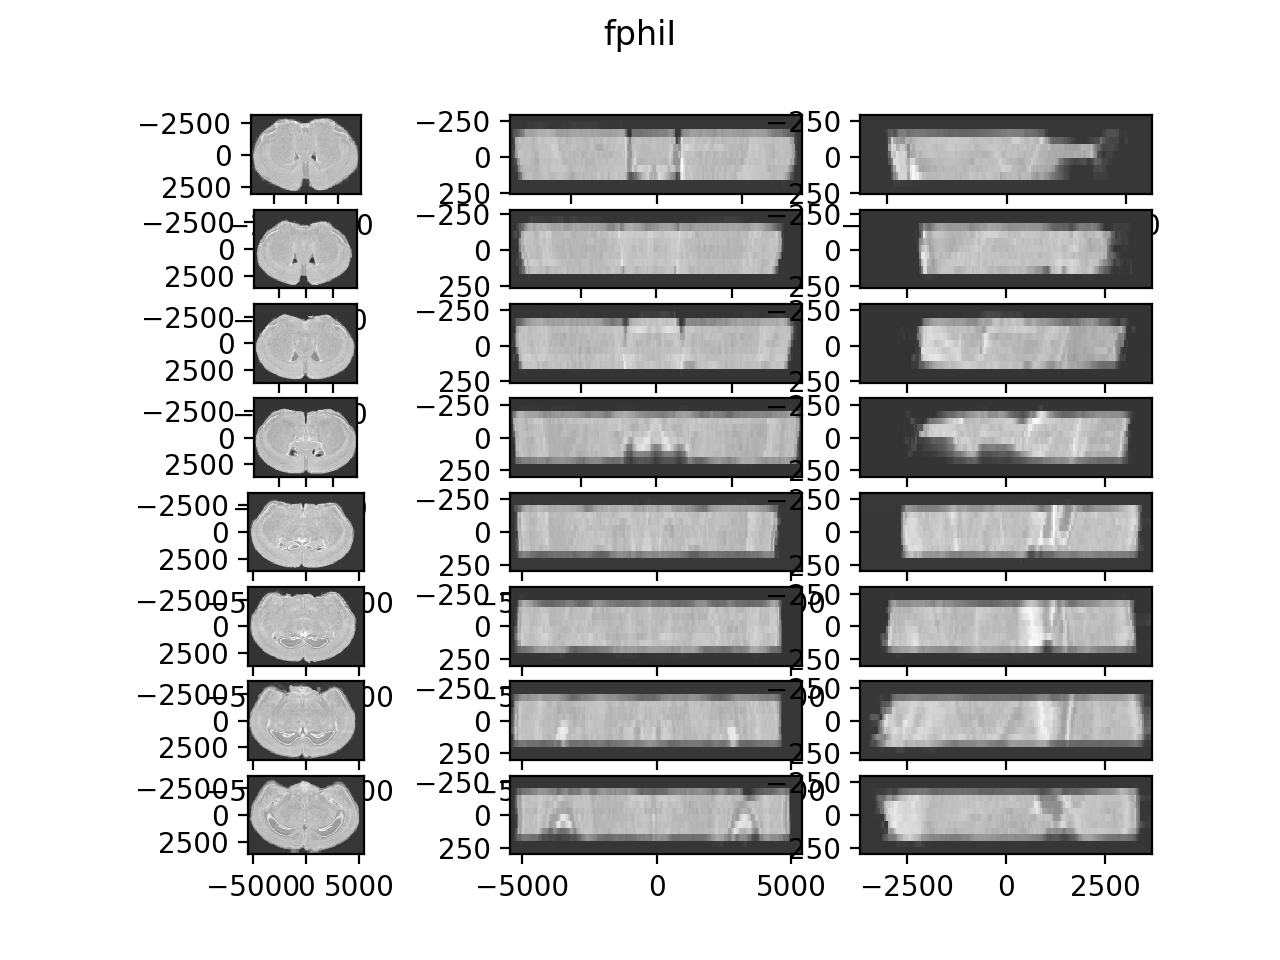

<IPython.core.display.Javascript object>


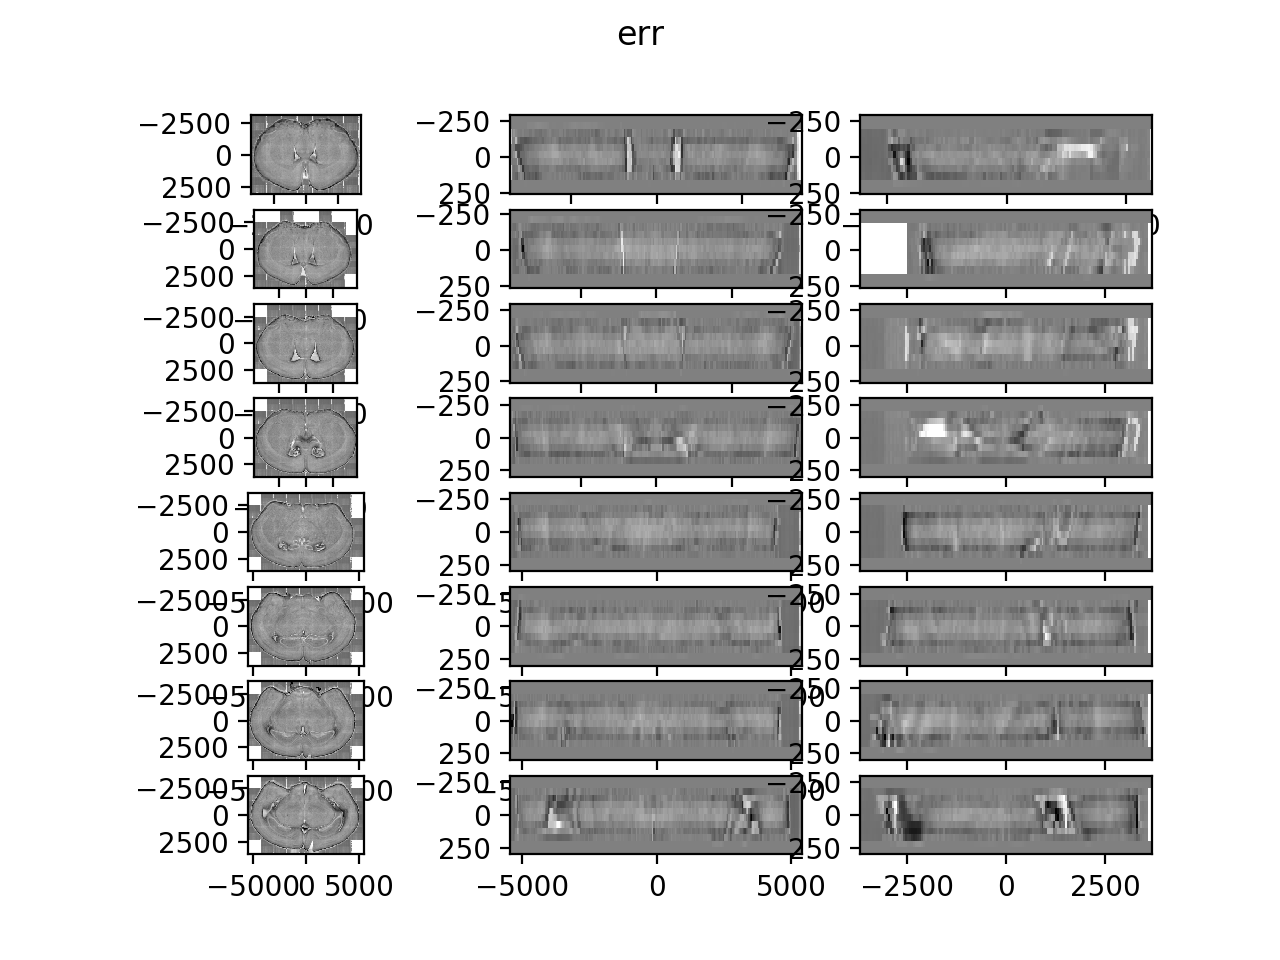

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


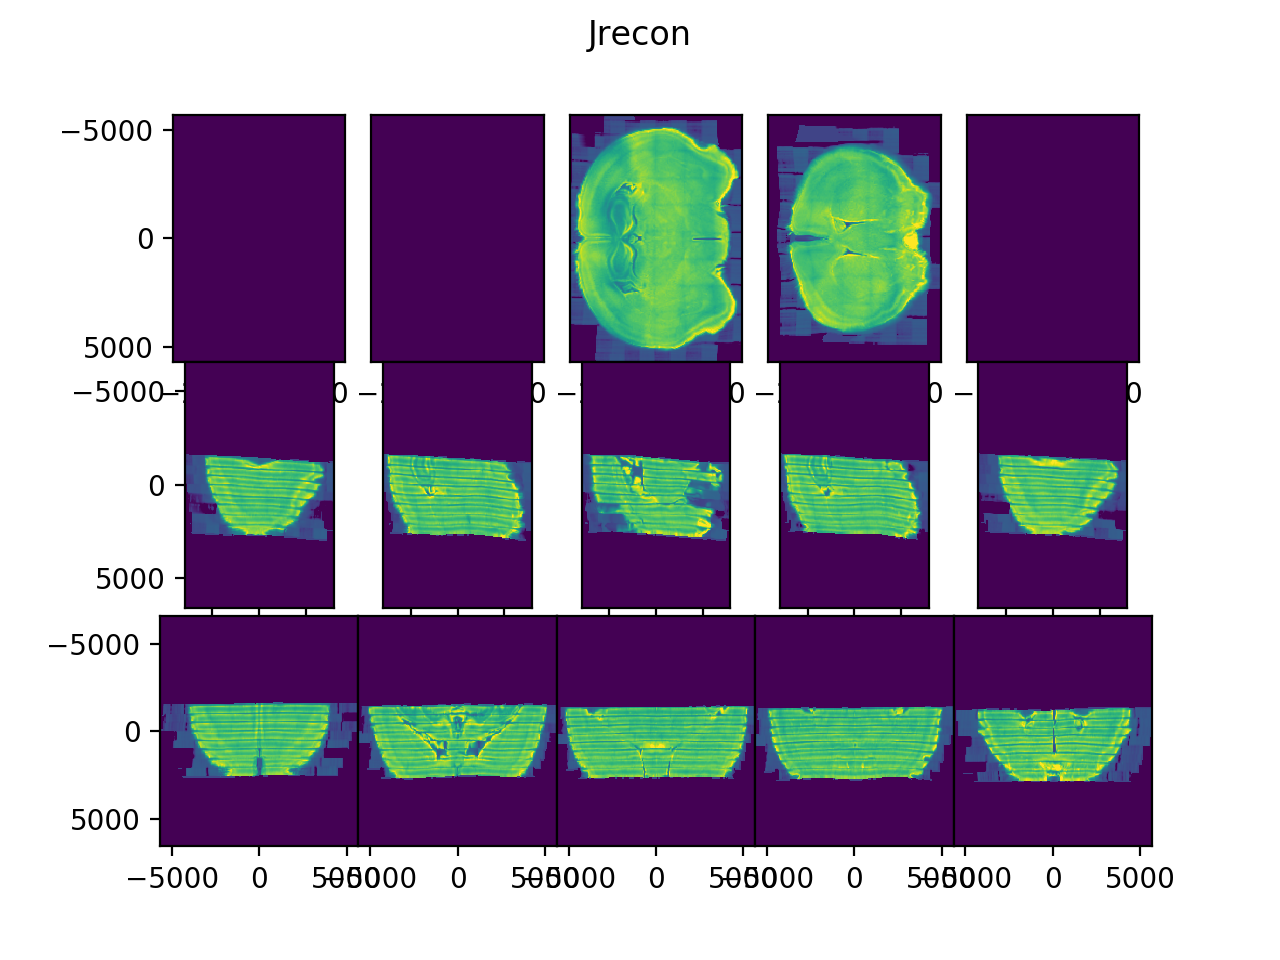

<IPython.core.display.Javascript object>


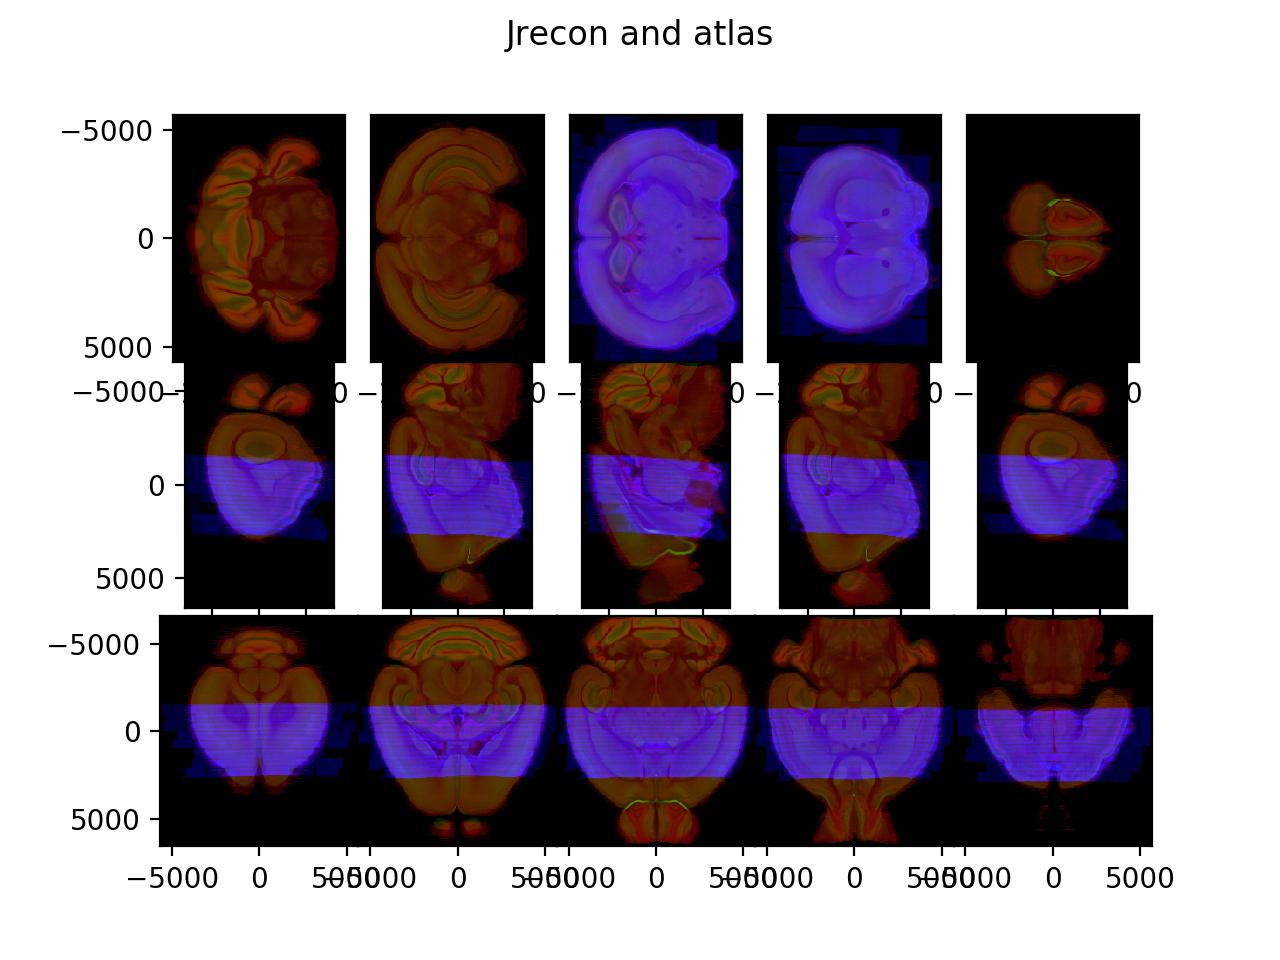

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/dtward/data/csh_data/emlddmm/emlddmm.py:89: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


4294967296 4294967296
4294967296 4294967296
drawing took 4.743041753768921 s
Finished it 0 (5.921569108963013 s), E: 53902658000.45101
4294967296 4294967296
4294967296 4294967296
drawing took 6.338785409927368 s
Finished it 1 (7.497573614120483 s), E: 53588102314.20694
Finished it 2 (0.2610898017883301 s), E: 53281675670.23351
Finished it 3 (0.21723580360412598 s), E: 52983721197.60759
Finished it 4 (0.22696542739868164 s), E: 52693777397.83432
Finished it 5 (0.22701621055603027 s), E: 52410940936.71863
Finished it 6 (0.22248363494873047 s), E: 52134410838.03258
4294967296 4294967296
4294967296 4294967296
drawing took 6.009109735488892 s
Finished it 7 (7.166090250015259 s), E: 51863871996.07728
Finished it 8 (0.25929713249206543 s), E: 51599400082.77016
Finished it 9 (0.22600913047790527 s), E: 51340471217.96566
Finished it 10 (0.21805286407470703 s), E: 51085651670.91672
Finished it 11 (0.2145214080810547 s), E: 50834363701.53543
Finished it 12 (0.21895313262939453 s), E: 50586563587.

Finished it 125 (0.2145099639892578 s), E: 26760129246.620758
Finished it 126 (0.21448397636413574 s), E: 26622084122.787247
4294967296 4294967296
4294967296 4294967296
drawing took 6.1677327156066895 s
Finished it 127 (7.325462818145752 s), E: 26485417256.752426
Finished it 128 (0.2518613338470459 s), E: 26350268565.22448
Finished it 129 (0.22467589378356934 s), E: 26216849549.104774
Finished it 130 (0.22098970413208008 s), E: 26085628036.008804
Finished it 131 (0.24886059761047363 s), E: 25956190081.66479
Finished it 132 (0.25393056869506836 s), E: 25828546954.18771
Finished it 133 (0.22793078422546387 s), E: 25704384220.545563
Finished it 134 (0.23560619354248047 s), E: 25583211114.795853
Finished it 135 (0.23488759994506836 s), E: 25465261348.467606
Finished it 136 (0.23750662803649902 s), E: 25349944718.651558
Finished it 137 (0.2387096881866455 s), E: 25236754717.08042
Finished it 138 (0.22767186164855957 s), E: 25125435158.31019
Finished it 139 (0.2305753231048584 s), E: 2501616

Finished it 252 (0.22773408889770508 s), E: 17928708569.104527
Finished it 253 (0.23041152954101562 s), E: 17891649999.681236
Finished it 254 (0.22460150718688965 s), E: 17855000150.005257
Finished it 255 (0.21542692184448242 s), E: 17818840220.48459
Finished it 256 (0.2147829532623291 s), E: 17782827694.411728
Finished it 257 (0.2223365306854248 s), E: 17747040757.784313
Finished it 258 (0.21413350105285645 s), E: 17711720382.930573
Finished it 259 (0.21629047393798828 s), E: 17676594180.873913
Finished it 260 (0.2167348861694336 s), E: 17641729765.40902
Finished it 261 (0.23408794403076172 s), E: 17607189701.131363
Finished it 262 (0.22128081321716309 s), E: 17573056600.386063
Finished it 263 (0.2278275489807129 s), E: 17539197945.229248
Finished it 264 (0.22684884071350098 s), E: 17505708579.21653
Finished it 265 (0.22773408889770508 s), E: 17472736048.749973
Finished it 266 (0.22837591171264648 s), E: 17440278455.08523
Finished it 267 (0.22138690948486328 s), E: 17408125612.534386


Finished it 381 (0.2176985740661621 s), E: 15093861065.66394
Finished it 382 (0.21805930137634277 s), E: 15082210638.86313
Finished it 383 (0.23305869102478027 s), E: 15070695306.697344
Finished it 384 (0.2373192310333252 s), E: 15059262617.476236
Finished it 385 (0.21672773361206055 s), E: 15047866810.89864
Finished it 386 (0.23249602317810059 s), E: 15036529269.327896
Finished it 387 (0.23380064964294434 s), E: 15025313128.824753
Finished it 388 (0.22820091247558594 s), E: 15014237790.368336
Finished it 389 (0.22785401344299316 s), E: 15003270512.814692
Finished it 390 (0.23413991928100586 s), E: 14992400347.08847
4294967296 4294967296
4294967296 4294967296
drawing took 6.17178750038147 s
Finished it 391 (7.318803787231445 s), E: 14981570884.574064
Finished it 392 (0.26468753814697266 s), E: 14970813960.490288
Finished it 393 (0.23269343376159668 s), E: 14960160820.93234
Finished it 394 (0.251361608505249 s), E: 14949639071.85145
Finished it 395 (0.22089314460754395 s), E: 1493920581

Finished it 510 (0.24005985260009766 s), E: 14068831006.492834
4294967296 4294967296
4294967296 4294967296
drawing took 6.213363885879517 s
Finished it 511 (7.421178817749023 s), E: 14063263528.972282
Finished it 512 (0.21484947204589844 s), E: 14057703335.661366
Finished it 513 (0.20377731323242188 s), E: 14052159573.215502
Finished it 514 (0.2227027416229248 s), E: 14046624657.087797
Finished it 515 (0.20561003684997559 s), E: 14041113592.209888
Finished it 516 (0.20968389511108398 s), E: 14035628797.88533
Finished it 517 (0.21705937385559082 s), E: 14030165001.695293
Finished it 518 (0.20338916778564453 s), E: 14024724533.709549
Finished it 519 (0.21732258796691895 s), E: 14019307768.1185
Finished it 520 (0.20365142822265625 s), E: 14013924712.1357
Finished it 521 (0.22110795974731445 s), E: 14008567493.285103
Finished it 522 (0.21825957298278809 s), E: 14003237225.869583
Finished it 523 (0.21564316749572754 s), E: 13997939651.47273
Finished it 524 (0.20417237281799316 s), E: 139926

Finished it 639 (0.21511459350585938 s), E: 13512277924.03703
Finished it 640 (0.2156515121459961 s), E: 13509132118.863228
Finished it 641 (0.21604061126708984 s), E: 13506014361.23677
Finished it 642 (0.21583867073059082 s), E: 13502926142.978325
Finished it 643 (0.21435761451721191 s), E: 13499869639.639307
Finished it 644 (0.21588635444641113 s), E: 13496823318.900124
Finished it 645 (0.21892356872558594 s), E: 13493795242.402882
Finished it 646 (0.21626663208007812 s), E: 13490781760.528776
4294967296 4294967296
4294967296 4294967296
drawing took 6.026885032653809 s
Finished it 647 (7.090355396270752 s), E: 13487785017.18699
Finished it 648 (0.22985363006591797 s), E: 13484806164.812422
Finished it 649 (0.209852933883667 s), E: 13481851557.695423
Finished it 650 (0.20483875274658203 s), E: 13478925534.336195
Finished it 651 (0.20549440383911133 s), E: 13476025568.762169
Finished it 652 (0.2223954200744629 s), E: 13473144167.732107
Finished it 653 (0.21380043029785156 s), E: 134702

Finished it 768 (0.21877789497375488 s), E: 13249845112.924635
Finished it 769 (0.22672700881958008 s), E: 13248507590.815174
Finished it 770 (0.21501636505126953 s), E: 13247177696.520538
Finished it 771 (0.2041950225830078 s), E: 13245856708.458126
Finished it 772 (0.2039651870727539 s), E: 13244545928.679138
Finished it 773 (0.20392966270446777 s), E: 13243244805.743942
Finished it 774 (0.20368742942810059 s), E: 13241948271.54354
Finished it 775 (0.20485925674438477 s), E: 13240660446.855553
Finished it 776 (0.20346879959106445 s), E: 13239378980.801235
Finished it 777 (0.2060236930847168 s), E: 13238108154.27998
Finished it 778 (0.20330214500427246 s), E: 13236844275.247662
Finished it 779 (0.21705889701843262 s), E: 13235585906.639368
Finished it 780 (0.21692252159118652 s), E: 13234331582.528864
Finished it 781 (0.21696162223815918 s), E: 13233086979.354797
Finished it 782 (0.21931004524230957 s), E: 13231853405.000587
Finished it 783 (0.21616291999816895 s), E: 13230630510.4987

Finished it 897 (0.20635247230529785 s), E: 13127439747.219051
Finished it 898 (0.21608281135559082 s), E: 13126778190.23094
Finished it 899 (0.21401143074035645 s), E: 13126120700.969528
Finished it 900 (0.2037196159362793 s), E: 13125467133.968784
Finished it 901 (0.2222309112548828 s), E: 13124818231.69366
Finished it 902 (0.21868538856506348 s), E: 13124171126.413681
Finished it 903 (0.21592402458190918 s), E: 13123526829.472067
Finished it 904 (0.21788287162780762 s), E: 13122884842.080763
Finished it 905 (0.21510672569274902 s), E: 13122245381.27953
Finished it 906 (0.21852755546569824 s), E: 13121607440.902407
Finished it 907 (0.21857666969299316 s), E: 13120970718.779694
Finished it 908 (0.21649694442749023 s), E: 13120333638.22805
Finished it 909 (0.21706676483154297 s), E: 13119698415.23923
Finished it 910 (0.21442532539367676 s), E: 13119064452.54787
Finished it 911 (0.2188117504119873 s), E: 13118434901.177341
Finished it 912 (0.2141869068145752 s), E: 13117808595.679691
Fi

Finished it 1027 (0.21234703063964844 s), E: 13054685868.451927
Finished it 1028 (0.22055459022521973 s), E: 13054236867.870676
Finished it 1029 (0.21652865409851074 s), E: 13053789718.95325
Finished it 1030 (0.21701598167419434 s), E: 13053345139.063046
Finished it 1031 (0.22099995613098145 s), E: 13052902067.330406
Finished it 1032 (0.22202682495117188 s), E: 13052460313.932941
Finished it 1033 (0.21738815307617188 s), E: 13052020967.033865
Finished it 1034 (0.22664213180541992 s), E: 13051582903.690292
Finished it 1035 (0.21651625633239746 s), E: 13051146176.974508
Finished it 1036 (0.22229814529418945 s), E: 13050710830.671503
Finished it 1037 (0.22895336151123047 s), E: 13050275835.938393
Finished it 1038 (0.21497178077697754 s), E: 13049842421.51211
Finished it 1039 (0.21893763542175293 s), E: 13049409060.753887
Finished it 1040 (0.22417426109313965 s), E: 13048975979.462479
Finished it 1041 (0.22966814041137695 s), E: 13048545587.523455
Finished it 1042 (0.22105717658996582 s), 

Finished it 1154 (0.2022862434387207 s), E: 13008906830.933228
Finished it 1155 (0.2079916000366211 s), E: 13008615073.99718
Finished it 1156 (0.20235300064086914 s), E: 13008324694.130905
Finished it 1157 (0.2057657241821289 s), E: 13008034463.383707
Finished it 1158 (0.20587682723999023 s), E: 13007745251.011051
Finished it 1159 (0.20334148406982422 s), E: 13007458261.406584
Finished it 1160 (0.2147231101989746 s), E: 13007172030.977926
Finished it 1161 (0.21588730812072754 s), E: 13006886671.27198
Finished it 1162 (0.21397852897644043 s), E: 13006601383.692492
Finished it 1163 (0.20448994636535645 s), E: 13006316469.310665
Finished it 1164 (0.22432446479797363 s), E: 13006031854.670664
Finished it 1165 (0.22689390182495117 s), E: 13005746629.582764
Finished it 1166 (0.22443485260009766 s), E: 13005459103.156206
Finished it 1167 (0.22084856033325195 s), E: 13005171191.873182
Finished it 1168 (0.21482419967651367 s), E: 13004882551.882713
Finished it 1169 (0.21756672859191895 s), E: 1

Finished it 1282 (0.21793913841247559 s), E: 12975434812.520542
Finished it 1283 (0.2203197479248047 s), E: 12975215413.336721
Finished it 1284 (0.21512317657470703 s), E: 12974997569.167091
Finished it 1285 (0.2156367301940918 s), E: 12974780904.804615
Finished it 1286 (0.23074078559875488 s), E: 12974565022.925848
Finished it 1287 (0.21692657470703125 s), E: 12974349800.120045
Finished it 1288 (0.21677231788635254 s), E: 12974135850.285673
Finished it 1289 (0.21832036972045898 s), E: 12973922124.02436
Finished it 1290 (0.21468639373779297 s), E: 12973708013.616795
Finished it 1291 (0.21793723106384277 s), E: 12973495189.084557
Finished it 1292 (0.21730756759643555 s), E: 12973282622.701782
Finished it 1293 (0.21624088287353516 s), E: 12973070889.021088
Finished it 1294 (0.22154808044433594 s), E: 12972859586.019669
Finished it 1295 (0.21950602531433105 s), E: 12972648470.017141
Finished it 1296 (0.22886157035827637 s), E: 12972438239.884445
Finished it 1297 (0.21761083602905273 s), E

Finished it 1410 (0.22210335731506348 s), E: 12946994585.051783
Finished it 1411 (0.2224283218383789 s), E: 12946747478.731571
Finished it 1412 (0.23295807838439941 s), E: 12946496977.109386
Finished it 1413 (0.2210557460784912 s), E: 12946243647.292692
Finished it 1414 (0.21915388107299805 s), E: 12945990526.334885
Finished it 1415 (0.2210249900817871 s), E: 12945740510.72746
Finished it 1416 (0.2215712070465088 s), E: 12945489313.869495
Finished it 1417 (0.21938562393188477 s), E: 12945237629.909485
Finished it 1418 (0.22266054153442383 s), E: 12944988203.499859
Finished it 1419 (0.2196347713470459 s), E: 12944740091.281168
Finished it 1420 (0.23168134689331055 s), E: 12944490187.303822
Finished it 1421 (0.218461275100708 s), E: 12944235876.509098
Finished it 1422 (0.21777796745300293 s), E: 12943974502.747335
Finished it 1423 (0.20637845993041992 s), E: 12943708667.072346
Finished it 1424 (0.20741963386535645 s), E: 12943437924.395267
Finished it 1425 (0.22252750396728516 s), E: 129

Finished it 1538 (0.21373224258422852 s), E: 12909593626.416
Finished it 1539 (0.2232198715209961 s), E: 12909320366.744503
Finished it 1540 (0.21946334838867188 s), E: 12909052876.121529
Finished it 1541 (0.22152113914489746 s), E: 12908788308.850035
Finished it 1542 (0.22307872772216797 s), E: 12908521016.063168
Finished it 1543 (0.2208089828491211 s), E: 12908247447.22063
Finished it 1544 (0.20593667030334473 s), E: 12907971729.949081
Finished it 1545 (0.22662639617919922 s), E: 12907705539.959171
Finished it 1546 (0.22104144096374512 s), E: 12907451706.130293
Finished it 1547 (0.2125110626220703 s), E: 12907207318.76166
Finished it 1548 (0.22122430801391602 s), E: 12906965149.554216
Finished it 1549 (0.22842144966125488 s), E: 12906724522.624552
Finished it 1550 (0.21781134605407715 s), E: 12906484410.345379
Finished it 1551 (0.21591901779174805 s), E: 12906247074.632483
Finished it 1552 (0.22171854972839355 s), E: 12906010731.39621
Finished it 1553 (0.2272624969482422 s), E: 12905

Finished it 1667 (0.21883249282836914 s), E: 12888343976.95223
Finished it 1668 (0.22085809707641602 s), E: 12888215349.020123
Finished it 1669 (0.2263779640197754 s), E: 12888083875.642445
Finished it 1670 (0.22615718841552734 s), E: 12887948812.883764
Finished it 1671 (0.20962738990783691 s), E: 12887811356.20387
Finished it 1672 (0.20703411102294922 s), E: 12887673182.565514
Finished it 1673 (0.21161389350891113 s), E: 12887532053.44341
Finished it 1674 (0.22401714324951172 s), E: 12887389247.89551
Finished it 1675 (0.21842455863952637 s), E: 12887243135.383411
Finished it 1676 (0.22485852241516113 s), E: 12887096362.38436
Finished it 1677 (0.21703648567199707 s), E: 12886952899.872593
Finished it 1678 (0.21822047233581543 s), E: 12886811977.155052
Finished it 1679 (0.22379732131958008 s), E: 12886672925.999853
Finished it 1680 (0.2141563892364502 s), E: 12886532175.23263
4294967296 4294967296
4294967296 4294967296
drawing took 5.975951671600342 s
Finished it 1681 (7.06281590461731 

Finished it 1795 (0.21423721313476562 s), E: 12873045623.787569
Finished it 1796 (0.20657873153686523 s), E: 12872948697.009007
Finished it 1797 (0.21715903282165527 s), E: 12872852009.020996
Finished it 1798 (0.22106361389160156 s), E: 12872756165.260893
4294967296 4294967296
4294967296 4294967296
drawing took 6.428512334823608 s
Finished it 1799 (7.517367839813232 s), E: 12872661081.279526
Finished it 1800 (0.24010729789733887 s), E: 12872565629.394184
Finished it 1801 (0.21540212631225586 s), E: 12872472330.821579
Finished it 1802 (0.21520113945007324 s), E: 12872378326.198997
Finished it 1803 (0.21466970443725586 s), E: 12872284686.18319
Finished it 1804 (0.22980642318725586 s), E: 12872191018.249542
Finished it 1805 (0.21681904792785645 s), E: 12872095647.664343
Finished it 1806 (0.21637248992919922 s), E: 12872000795.838446
Finished it 1807 (0.21694254875183105 s), E: 12871904297.279945
Finished it 1808 (0.21480965614318848 s), E: 12871807754.533932
Finished it 1809 (0.2167007923

Finished it 1922 (0.23757076263427734 s), E: 12860247643.04327
Finished it 1923 (0.2038710117340088 s), E: 12860132543.178856
Finished it 1924 (0.2182636260986328 s), E: 12860018160.253256
Finished it 1925 (0.22158360481262207 s), E: 12859904595.480745
Finished it 1926 (0.23044538497924805 s), E: 12859791399.293291
Finished it 1927 (0.20940804481506348 s), E: 12859676398.160568
Finished it 1928 (0.2096238136291504 s), E: 12859560380.63636
Finished it 1929 (0.20637774467468262 s), E: 12859446597.137384
Finished it 1930 (0.2025609016418457 s), E: 12859336759.360744
Finished it 1931 (0.20302224159240723 s), E: 12859228279.526602
Finished it 1932 (0.2027876377105713 s), E: 12859119048.946362
Finished it 1933 (0.20218563079833984 s), E: 12859010262.940771
Finished it 1934 (0.20425939559936523 s), E: 12858902543.238907
Finished it 1935 (0.20293521881103516 s), E: 12858796385.283216
Finished it 1936 (0.22844791412353516 s), E: 12858691811.95147
Finished it 1937 (0.21766901016235352 s), E: 128

Finished it 2050 (0.20285987854003906 s), E: 12590458787.688843
Finished it 2051 (0.22269749641418457 s), E: 12586134153.993286
Finished it 2052 (0.21732115745544434 s), E: 12581824107.974012
Finished it 2053 (0.21549630165100098 s), E: 12577549433.294064
Finished it 2054 (0.22713422775268555 s), E: 12573320358.33668
Finished it 2055 (0.21938848495483398 s), E: 12569126622.78204
Finished it 2056 (0.21808624267578125 s), E: 12564952474.892593
Finished it 2057 (0.20611906051635742 s), E: 12560805180.792639
Finished it 2058 (0.20379638671875 s), E: 12556682138.993065
Finished it 2059 (0.21701693534851074 s), E: 12552594867.96907
Finished it 2060 (0.21490859985351562 s), E: 12548545143.649244
Finished it 2061 (0.2167222499847412 s), E: 12544509369.255516
Finished it 2062 (0.21773648262023926 s), E: 12540471811.271381
Finished it 2063 (0.215559720993042 s), E: 12536460154.688366
Finished it 2064 (0.22508597373962402 s), E: 12532474838.353867
Finished it 2065 (0.21062397956848145 s), E: 1252

Finished it 2178 (0.24783849716186523 s), E: 12217737300.575548
Finished it 2179 (0.207289457321167 s), E: 12215865906.490608
Finished it 2180 (0.2132432460784912 s), E: 12213999628.322037
Finished it 2181 (0.22218704223632812 s), E: 12212142443.44638
Finished it 2182 (0.21967053413391113 s), E: 12210286532.20963
Finished it 2183 (0.21234393119812012 s), E: 12208434524.72256
Finished it 2184 (0.21913814544677734 s), E: 12206586922.17847
Finished it 2185 (0.20614147186279297 s), E: 12204744462.101263
Finished it 2186 (0.2040266990661621 s), E: 12202906490.502758
Finished it 2187 (0.20354986190795898 s), E: 12201079763.208092
Finished it 2188 (0.2155909538269043 s), E: 12199263533.194191
Finished it 2189 (0.21553444862365723 s), E: 12197451682.40292
Finished it 2190 (0.20624256134033203 s), E: 12195648443.948145
Finished it 2191 (0.2036452293395996 s), E: 12193853219.05576
Finished it 2192 (0.21749615669250488 s), E: 12192064269.195665
Finished it 2193 (0.21622490882873535 s), E: 1219028

Finished it 2308 (0.22167086601257324 s), E: 12020813947.16804
Finished it 2309 (0.23013067245483398 s), E: 12019520567.720217
Finished it 2310 (0.2161874771118164 s), E: 12018229170.04433
4294967296 4294967296
4294967296 4294967296
drawing took 6.336929082870483 s
Finished it 2311 (7.421206951141357 s), E: 12016943543.097916
Finished it 2312 (0.2411348819732666 s), E: 12015661911.33136
Finished it 2313 (0.2075977325439453 s), E: 12014384360.70988
Finished it 2314 (0.21357011795043945 s), E: 12013109496.707302
Finished it 2315 (0.22862887382507324 s), E: 12011837105.839241
Finished it 2316 (0.22706985473632812 s), E: 12010570476.050148
Finished it 2317 (0.2193615436553955 s), E: 12009306122.439213
Finished it 2318 (0.21565675735473633 s), E: 12008047373.822414
Finished it 2319 (0.2158973217010498 s), E: 12006791978.103271
Finished it 2320 (0.21610808372497559 s), E: 12005537303.56451
Finished it 2321 (0.21570110321044922 s), E: 12004286519.693434
Finished it 2322 (0.20603132247924805 s

Finished it 2436 (0.2197415828704834 s), E: 11878920392.06374
Finished it 2437 (0.23066210746765137 s), E: 11877978984.856636
Finished it 2438 (0.22153162956237793 s), E: 11877040713.97447
Finished it 2439 (0.21870112419128418 s), E: 11876105057.902355
Finished it 2440 (0.22467303276062012 s), E: 11875172243.792347
Finished it 2441 (0.2279651165008545 s), E: 11874245957.594582
Finished it 2442 (0.2213282585144043 s), E: 11873322072.25809
Finished it 2443 (0.23055672645568848 s), E: 11872400981.653118
Finished it 2444 (0.21405529975891113 s), E: 11871485251.390882
Finished it 2445 (0.23012137413024902 s), E: 11870573980.232588
Finished it 2446 (0.21763253211975098 s), E: 11869665822.306377
Finished it 2447 (0.22051596641540527 s), E: 11868761280.090904
Finished it 2448 (0.2244119644165039 s), E: 11867859013.988386
4294967296 4294967296
4294967296 4294967296
drawing took 6.023576021194458 s
Finished it 2449 (7.114248275756836 s), E: 11866958757.595978
Finished it 2450 (0.2348294258117675

Finished it 2565 (0.22356700897216797 s), E: 11777217956.186142
Finished it 2566 (0.22646212577819824 s), E: 11776543433.60876
Finished it 2567 (0.22286295890808105 s), E: 11775871206.05125
Finished it 2568 (0.2211318016052246 s), E: 11775200126.342083
Finished it 2569 (0.22971296310424805 s), E: 11774529560.830318
Finished it 2570 (0.21708369255065918 s), E: 11773858550.33659
Finished it 2571 (0.22642111778259277 s), E: 11773187335.190662
Finished it 2572 (0.21651744842529297 s), E: 11772518670.728775
Finished it 2573 (0.21432280540466309 s), E: 11771850357.996498
Finished it 2574 (0.22268176078796387 s), E: 11771183140.624252
Finished it 2575 (0.21891403198242188 s), E: 11770517901.988058
Finished it 2576 (0.22131586074829102 s), E: 11769852911.895512
Finished it 2577 (0.22526168823242188 s), E: 11769190579.946379
Finished it 2578 (0.23535609245300293 s), E: 11768529427.561926
Finished it 2579 (0.22026443481445312 s), E: 11767869529.073002
Finished it 2580 (0.23157882690429688 s), E:

Finished it 2693 (0.20766854286193848 s), E: 11703594238.422745
Finished it 2694 (0.20937490463256836 s), E: 11703099118.229395
Finished it 2695 (0.2244126796722412 s), E: 11702604282.830076
Finished it 2696 (0.23071861267089844 s), E: 11702109751.805103
Finished it 2697 (0.2153785228729248 s), E: 11701616374.999344
Finished it 2698 (0.22031140327453613 s), E: 11701124117.026047
Finished it 2699 (0.2274777889251709 s), E: 11700632779.13178
Finished it 2700 (0.22517108917236328 s), E: 11700143524.510479
Finished it 2701 (0.21709465980529785 s), E: 11699654763.835566
Finished it 2702 (0.22152328491210938 s), E: 11699166350.523949
Finished it 2703 (0.2243518829345703 s), E: 11698677721.118784
Finished it 2704 (0.22070956230163574 s), E: 11698189461.494143
Finished it 2705 (0.21781063079833984 s), E: 11697702562.439404
Finished it 2706 (0.2181107997894287 s), E: 11697216695.209467
Finished it 2707 (0.21773505210876465 s), E: 11696731849.325308
Finished it 2708 (0.22931265830993652 s), E: 1

Finished it 2821 (0.22642087936401367 s), E: 11646323725.799473
Finished it 2822 (0.20734763145446777 s), E: 11645919005.987259
Finished it 2823 (0.20727181434631348 s), E: 11645514535.549082
Finished it 2824 (0.2096848487854004 s), E: 11645111296.262142
Finished it 2825 (0.21566557884216309 s), E: 11644708117.66738
Finished it 2826 (0.2101302146911621 s), E: 11644305197.313662
Finished it 2827 (0.21660089492797852 s), E: 11643902813.539848
Finished it 2828 (0.21624493598937988 s), E: 11643500837.5324
Finished it 2829 (0.22012114524841309 s), E: 11643099031.10485
Finished it 2830 (0.22896361351013184 s), E: 11642697635.77285
Finished it 2831 (0.21753692626953125 s), E: 11642297107.022903
Finished it 2832 (0.23114299774169922 s), E: 11641896766.858032
Finished it 2833 (0.2152576446533203 s), E: 11641495544.683977
Finished it 2834 (0.21711230278015137 s), E: 11641095544.974384
Finished it 2835 (0.22401762008666992 s), E: 11640697044.453236
Finished it 2836 (0.22451353073120117 s), E: 116

Finished it 2949 (0.22246265411376953 s), E: 11597494622.530972
Finished it 2950 (0.21662020683288574 s), E: 11597136040.333328
Finished it 2951 (0.22182941436767578 s), E: 11596777685.92075
Finished it 2952 (0.2263658046722412 s), E: 11596420167.86966
Finished it 2953 (0.22270488739013672 s), E: 11596064043.280014
Finished it 2954 (0.21847105026245117 s), E: 11595709384.71395
Finished it 2955 (0.21933221817016602 s), E: 11595355846.745058
Finished it 2956 (0.22692489624023438 s), E: 11595002352.914993
Finished it 2957 (0.21625542640686035 s), E: 11594649327.314705
Finished it 2958 (0.2265183925628662 s), E: 11594296123.846684
Finished it 2959 (0.2176377773284912 s), E: 11593942595.037964
Finished it 2960 (0.22033143043518066 s), E: 11593589013.401905
Finished it 2961 (0.22260570526123047 s), E: 11593234732.865612
Finished it 2962 (0.22765207290649414 s), E: 11592880524.657705
Finished it 2963 (0.21573805809020996 s), E: 11592525619.595308
Finished it 2964 (0.22394800186157227 s), E: 1

Finished it 3077 (0.2180614471435547 s), E: 11555884290.092594
Finished it 3078 (0.2213423252105713 s), E: 11555590939.402054
Finished it 3079 (0.23127031326293945 s), E: 11555298000.217897
Finished it 3080 (0.2187182903289795 s), E: 11555005558.655895
Finished it 3081 (0.2222898006439209 s), E: 11554713077.970951
Finished it 3082 (0.2315685749053955 s), E: 11554421491.507214
Finished it 3083 (0.21196937561035156 s), E: 11554129873.70737
Finished it 3084 (0.2187175750732422 s), E: 11553839229.782839
Finished it 3085 (0.21076059341430664 s), E: 11553549197.646639
Finished it 3086 (0.2240889072418213 s), E: 11553259650.331238
Finished it 3087 (0.22147679328918457 s), E: 11552969933.603445
Finished it 3088 (0.2264716625213623 s), E: 11552681263.082651
Finished it 3089 (0.21773743629455566 s), E: 11552393642.452612
Finished it 3090 (0.21698784828186035 s), E: 11552106445.636904
Finished it 3091 (0.2244856357574463 s), E: 11551819992.847187
Finished it 3092 (0.21830224990844727 s), E: 11551

Finished it 3205 (0.2241809368133545 s), E: 11521178459.391409
Finished it 3206 (0.22711896896362305 s), E: 11520929972.686314
Finished it 3207 (0.22264957427978516 s), E: 11520681744.052345
Finished it 3208 (0.20613551139831543 s), E: 11520433607.56336
Finished it 3209 (0.20447754859924316 s), E: 11520185565.118399
Finished it 3210 (0.20399069786071777 s), E: 11519937818.840658
Finished it 3211 (0.20873022079467773 s), E: 11519690257.99924
Finished it 3212 (0.2050769329071045 s), E: 11519442895.22367
Finished it 3213 (0.20466852188110352 s), E: 11519195779.649197
Finished it 3214 (0.20672106742858887 s), E: 11518948557.558922
Finished it 3215 (0.2163081169128418 s), E: 11518702271.284649
Finished it 3216 (0.22206425666809082 s), E: 11518457174.151466
Finished it 3217 (0.22188258171081543 s), E: 11518212702.432339
Finished it 3218 (0.21737051010131836 s), E: 11517968836.169338
Finished it 3219 (0.21670842170715332 s), E: 11517725264.220036
Finished it 3220 (0.21796059608459473 s), E: 1

Finished it 3335 (0.21941852569580078 s), E: 11491611391.655922
Finished it 3336 (0.2249126434326172 s), E: 11491401253.171848
Finished it 3337 (0.22752094268798828 s), E: 11491192037.002218
Finished it 3338 (0.22396111488342285 s), E: 11490982243.042854
Finished it 3339 (0.22132277488708496 s), E: 11490772301.005116
Finished it 3340 (0.22541451454162598 s), E: 11490561660.567371
Finished it 3341 (0.2237873077392578 s), E: 11490350953.966293
Finished it 3342 (0.21868109703063965 s), E: 11490140640.322712
Finished it 3343 (0.22186779975891113 s), E: 11489930961.330278
Finished it 3344 (0.22951769828796387 s), E: 11489721559.3325
Finished it 3345 (0.22680044174194336 s), E: 11489511945.116198
Finished it 3346 (0.22019219398498535 s), E: 11489302311.272682
Finished it 3347 (0.22400355339050293 s), E: 11489092596.79464
Finished it 3348 (0.2269446849822998 s), E: 11488883058.842388
Finished it 3349 (0.22131991386413574 s), E: 11488673090.24296
Finished it 3350 (0.22066164016723633 s), E: 11

Finished it 3463 (0.22027826309204102 s), E: 11466330202.163137
Finished it 3464 (0.23147249221801758 s), E: 11466147250.199165
Finished it 3465 (0.2137141227722168 s), E: 11465964296.7869
Finished it 3466 (0.22778630256652832 s), E: 11465781705.569141
Finished it 3467 (0.22973966598510742 s), E: 11465599508.655272
Finished it 3468 (0.21607184410095215 s), E: 11465417175.816286
Finished it 3469 (0.21911191940307617 s), E: 11465235224.676126
Finished it 3470 (0.22099542617797852 s), E: 11465052826.868263
Finished it 3471 (0.2259230613708496 s), E: 11464870538.660599
Finished it 3472 (0.22241926193237305 s), E: 11464688766.146164
Finished it 3473 (0.21505165100097656 s), E: 11464507462.853716
Finished it 3474 (0.21908235549926758 s), E: 11464326851.46268
Finished it 3475 (0.22150945663452148 s), E: 11464146710.844893
Finished it 3476 (0.21797657012939453 s), E: 11463966636.244043
Finished it 3477 (0.20586919784545898 s), E: 11463786644.401379
Finished it 3478 (0.2093973159790039 s), E: 1

Finished it 3591 (0.21738719940185547 s), E: 11444426145.268147
Finished it 3592 (0.21998167037963867 s), E: 11444267206.60524
Finished it 3593 (0.22179937362670898 s), E: 11444108556.731855
Finished it 3594 (0.22660326957702637 s), E: 11443950053.197428
Finished it 3595 (0.21670866012573242 s), E: 11443791440.413395
Finished it 3596 (0.2194232940673828 s), E: 11443632392.547039
Finished it 3597 (0.22603702545166016 s), E: 11443473706.509823
Finished it 3598 (0.2161400318145752 s), E: 11443315304.677277
Finished it 3599 (0.2299635410308838 s), E: 11443157280.40157
Finished it 3600 (0.21647238731384277 s), E: 11442999716.790684
Finished it 3601 (0.21731352806091309 s), E: 11442842185.508831
Finished it 3602 (0.22054767608642578 s), E: 11442684586.264715
Finished it 3603 (0.22150826454162598 s), E: 11442527136.489548
Finished it 3604 (0.20574140548706055 s), E: 11442370155.371082
Finished it 3605 (0.23373031616210938 s), E: 11442213605.410366
Finished it 3606 (0.21661782264709473 s), E: 

Finished it 3719 (0.22157573699951172 s), E: 11425323323.800684
Finished it 3720 (0.2261340618133545 s), E: 11425184166.925758
Finished it 3721 (0.21616911888122559 s), E: 11425045215.695879
Finished it 3722 (0.22272324562072754 s), E: 11424905968.660267
Finished it 3723 (0.22401046752929688 s), E: 11424766710.223999
Finished it 3724 (0.22330045700073242 s), E: 11424627705.151638
Finished it 3725 (0.21636509895324707 s), E: 11424489260.222855
Finished it 3726 (0.21994972229003906 s), E: 11424351161.210392
Finished it 3727 (0.2198793888092041 s), E: 11424213391.538824
Finished it 3728 (0.21921062469482422 s), E: 11424075518.002663
Finished it 3729 (0.21909570693969727 s), E: 11423937936.298344
Finished it 3730 (0.22336792945861816 s), E: 11423800716.087067
Finished it 3731 (0.21850228309631348 s), E: 11423663369.582142
Finished it 3732 (0.2226567268371582 s), E: 11423526256.383556
Finished it 3733 (0.22614693641662598 s), E: 11423389068.588398
Finished it 3734 (0.20389127731323242 s), E

Finished it 3848 (0.21789288520812988 s), E: 11408727286.348036
Finished it 3849 (0.22315692901611328 s), E: 11408607884.410553
Finished it 3850 (0.22081947326660156 s), E: 11408488611.426079
Finished it 3851 (0.22405719757080078 s), E: 11408369664.266438
Finished it 3852 (0.2220592498779297 s), E: 11408250989.358824
Finished it 3853 (0.22626399993896484 s), E: 11408132738.939503
Finished it 3854 (0.21463656425476074 s), E: 11408014635.39351
Finished it 3855 (0.22330617904663086 s), E: 11407896584.133564
Finished it 3856 (0.22629785537719727 s), E: 11407778596.057144
Finished it 3857 (0.2277979850769043 s), E: 11407660727.948982
Finished it 3858 (0.2160792350769043 s), E: 11407542954.507442
Finished it 3859 (0.22052454948425293 s), E: 11407425183.594429
Finished it 3860 (0.23229575157165527 s), E: 11407307899.566986
Finished it 3861 (0.22376585006713867 s), E: 11407190877.557451
Finished it 3862 (0.21772217750549316 s), E: 11407073832.787718
Finished it 3863 (0.22068357467651367 s), E:

Finished it 3976 (0.2277240753173828 s), E: 11394137311.715303
Finished it 3977 (0.22367620468139648 s), E: 11394029424.188004
Finished it 3978 (0.2194216251373291 s), E: 11393921332.393208
Finished it 3979 (0.21999573707580566 s), E: 11393813271.408365
Finished it 3980 (0.21311664581298828 s), E: 11393705284.036152
Finished it 3981 (0.21773529052734375 s), E: 11393597408.732391
Finished it 3982 (0.2057812213897705 s), E: 11393489659.59116
Finished it 3983 (0.20680975914001465 s), E: 11393381878.163141
Finished it 3984 (0.21783065795898438 s), E: 11393274157.205284
Finished it 3985 (0.20549821853637695 s), E: 11393166694.774647
Finished it 3986 (0.20759248733520508 s), E: 11393059231.910803
Finished it 3987 (0.22301578521728516 s), E: 11392951543.777668
Finished it 3988 (0.22777295112609863 s), E: 11392844021.656681
Finished it 3989 (0.2283334732055664 s), E: 11392736798.107756
Finished it 3990 (0.21544599533081055 s), E: 11392629557.61879
Finished it 3991 (0.2133324146270752 s), E: 11

Finished it 4104 (0.20670747756958008 s), E: 11380924985.935507
Finished it 4105 (0.2083897590637207 s), E: 11380825727.694828
Finished it 4106 (0.21358752250671387 s), E: 11380726635.43644
Finished it 4107 (0.20659184455871582 s), E: 11380627685.420166
Finished it 4108 (0.23007822036743164 s), E: 11380528879.15445
Finished it 4109 (0.21503448486328125 s), E: 11380430112.53009
Finished it 4110 (0.2164747714996338 s), E: 11380330910.253685
Finished it 4111 (0.22008514404296875 s), E: 11380231861.78033
Finished it 4112 (0.22249293327331543 s), E: 11380132954.053265
Finished it 4113 (0.21728086471557617 s), E: 11380034181.955803
Finished it 4114 (0.21045279502868652 s), E: 11379935657.711948
Finished it 4115 (0.2103409767150879 s), E: 11379837123.764458
Finished it 4116 (0.21461009979248047 s), E: 11379738437.065746
Finished it 4117 (0.21862578392028809 s), E: 11379639874.957296
Finished it 4118 (0.21876120567321777 s), E: 11379541491.73971
Finished it 4119 (0.20850229263305664 s), E: 113

Finished it 4232 (0.23969650268554688 s), E: 11368853338.4873
Finished it 4233 (0.20493769645690918 s), E: 11368764349.583214
Finished it 4234 (0.22012066841125488 s), E: 11368675505.540154
Finished it 4235 (0.23962140083312988 s), E: 11368586768.68981
Finished it 4236 (0.2106034755706787 s), E: 11368498037.250116
Finished it 4237 (0.2082047462463379 s), E: 11368409287.792269
Finished it 4238 (0.23167991638183594 s), E: 11368320390.869377
Finished it 4239 (0.21224069595336914 s), E: 11368231675.310963
Finished it 4240 (0.21053814888000488 s), E: 11368142859.296751
Finished it 4241 (0.20712685585021973 s), E: 11368054162.386467
Finished it 4242 (0.2073221206665039 s), E: 11367965637.958187
Finished it 4243 (0.2080545425415039 s), E: 11367877268.589369
Finished it 4244 (0.21127605438232422 s), E: 11367788901.534561
Finished it 4245 (0.2135789394378662 s), E: 11367700543.261272
Finished it 4246 (0.20651531219482422 s), E: 11367612747.352242
Finished it 4247 (0.20616412162780762 s), E: 113

Finished it 4361 (0.21274971961975098 s), E: 11358007184.947407
Finished it 4362 (0.2295229434967041 s), E: 11357928835.071392
Finished it 4363 (0.21123623847961426 s), E: 11357850424.230488
Finished it 4364 (0.21886777877807617 s), E: 11357772144.9037
Finished it 4365 (0.22284173965454102 s), E: 11357693827.636124
Finished it 4366 (0.21747374534606934 s), E: 11357615383.77062
Finished it 4367 (0.21292996406555176 s), E: 11357537094.473034
Finished it 4368 (0.22435808181762695 s), E: 11357458759.598633
Finished it 4369 (0.22593903541564941 s), E: 11357380571.446363
Finished it 4370 (0.22246623039245605 s), E: 11357302688.51096
Finished it 4371 (0.2160511016845703 s), E: 11357225080.701523
Finished it 4372 (0.22050976753234863 s), E: 11357147461.18617
Finished it 4373 (0.22225618362426758 s), E: 11357069698.616894
Finished it 4374 (0.21802830696105957 s), E: 11356992035.064522
Finished it 4375 (0.21883320808410645 s), E: 11356914475.302692
Finished it 4376 (0.20693683624267578 s), E: 11

Finished it 4489 (0.21037721633911133 s), E: 11348657613.53122
Finished it 4490 (0.2173936367034912 s), E: 11348589067.058357
Finished it 4491 (0.23396730422973633 s), E: 11348520480.56431
Finished it 4492 (0.21181654930114746 s), E: 11348451937.867662
Finished it 4493 (0.2113654613494873 s), E: 11348383413.355747
Finished it 4494 (0.23167657852172852 s), E: 11348315034.381191
Finished it 4495 (0.22930645942687988 s), E: 11348246712.542007
Finished it 4496 (0.21718621253967285 s), E: 11348178334.294714
Finished it 4497 (0.20824551582336426 s), E: 11348109908.600449
Finished it 4498 (0.21268153190612793 s), E: 11348041431.753521
Finished it 4499 (0.22481536865234375 s), E: 11347973002.653984
Finished it 4500 (0.22963762283325195 s), E: 11347904437.178314
Finished it 4501 (0.21287941932678223 s), E: 11347835815.91625
Finished it 4502 (0.21196532249450684 s), E: 11347767261.358019
Finished it 4503 (0.2118825912475586 s), E: 11347698920.462078
Finished it 4504 (0.21444272994995117 s), E: 1

Finished it 4617 (0.21451878547668457 s), E: 11340339924.1175
Finished it 4618 (0.22289514541625977 s), E: 11340279161.561386
Finished it 4619 (0.2091233730316162 s), E: 11340218396.50467
Finished it 4620 (0.20440196990966797 s), E: 11340157733.17933
Finished it 4621 (0.20463871955871582 s), E: 11340097083.386486
Finished it 4622 (0.20569992065429688 s), E: 11340036402.93552
Finished it 4623 (0.20402812957763672 s), E: 11339975775.735422
Finished it 4624 (0.20369863510131836 s), E: 11339915216.536446
Finished it 4625 (0.21455144882202148 s), E: 11339854654.54197
Finished it 4626 (0.21611762046813965 s), E: 11339794143.715263
Finished it 4627 (0.21583032608032227 s), E: 11339733694.688154
Finished it 4628 (0.2158644199371338 s), E: 11339673253.740664
Finished it 4629 (0.2152249813079834 s), E: 11339612882.714802
Finished it 4630 (0.21753215789794922 s), E: 11339552492.254564
Finished it 4631 (0.21508312225341797 s), E: 11339492035.082857
Finished it 4632 (0.2160634994506836 s), E: 11339

Finished it 4747 (0.22109651565551758 s), E: 11332729507.191967
Finished it 4748 (0.23061013221740723 s), E: 11332673367.366411
Finished it 4749 (0.2174205780029297 s), E: 11332617278.101152
Finished it 4750 (0.2087242603302002 s), E: 11332561160.414799
Finished it 4751 (0.23047256469726562 s), E: 11332505072.710102
Finished it 4752 (0.2206118106842041 s), E: 11332449022.943571
Finished it 4753 (0.20537137985229492 s), E: 11332392948.77525
Finished it 4754 (0.20842790603637695 s), E: 11332336785.67463
Finished it 4755 (0.2124161720275879 s), E: 11332280646.241531
Finished it 4756 (0.22721529006958008 s), E: 11332224536.908379
Finished it 4757 (0.22176504135131836 s), E: 11332168463.92981
Finished it 4758 (0.21845221519470215 s), E: 11332112472.66022
Finished it 4759 (0.22377300262451172 s), E: 11332056489.980463
Finished it 4760 (0.22504019737243652 s), E: 11332000629.534763
Finished it 4761 (0.2161705493927002 s), E: 11331944834.956644
Finished it 4762 (0.22973346710205078 s), E: 1133

Finished it 4875 (0.22330880165100098 s), E: 11325735619.714733
Finished it 4876 (0.2196192741394043 s), E: 11325682475.714535
Finished it 4877 (0.21868896484375 s), E: 11325629434.584915
Finished it 4878 (0.22190618515014648 s), E: 11325576380.106474
Finished it 4879 (0.22042036056518555 s), E: 11325523343.501822
Finished it 4880 (0.22174859046936035 s), E: 11325470591.78848
Finished it 4881 (0.22233819961547852 s), E: 11325417913.245075
Finished it 4882 (0.21541476249694824 s), E: 11325365276.116362
Finished it 4883 (0.21726059913635254 s), E: 11325312694.193121
Finished it 4884 (0.2219226360321045 s), E: 11325260263.754263
Finished it 4885 (0.22713494300842285 s), E: 11325207968.84794
Finished it 4886 (0.21690845489501953 s), E: 11325155792.690601
Finished it 4887 (0.21672654151916504 s), E: 11325103727.92698
Finished it 4888 (0.22235870361328125 s), E: 11325051739.661577
Finished it 4889 (0.2085552215576172 s), E: 11324999974.074451
Finished it 4890 (0.21099257469177246 s), E: 1132

Finished it 5003 (0.21568512916564941 s), E: 11095153101.658916
Finished it 5004 (0.23028564453125 s), E: 11030110073.520725
Finished it 5005 (0.20548415184020996 s), E: 10969183738.679144
Finished it 5006 (0.21617841720581055 s), E: 10912001340.946474
Finished it 5007 (0.21960186958312988 s), E: 10858232246.067415
Finished it 5008 (0.21973204612731934 s), E: 10807599036.602455
Finished it 5009 (0.21765518188476562 s), E: 10759751470.337547
Finished it 5010 (0.22297883033752441 s), E: 10714450003.128895
Finished it 5011 (0.22734642028808594 s), E: 10671460771.456892
Finished it 5012 (0.21934819221496582 s), E: 10630538212.807516
Finished it 5013 (0.2064802646636963 s), E: 10591440570.529419
Finished it 5014 (0.21276164054870605 s), E: 10554005992.557932
Finished it 5015 (0.20587396621704102 s), E: 10518139225.437176
Finished it 5016 (0.20771074295043945 s), E: 10483712772.208641
Finished it 5017 (0.21198821067810059 s), E: 10450612388.334578
Finished it 5018 (0.22322869300842285 s), E:

Finished it 5134 (0.22067666053771973 s), E: 9037743998.72729
Finished it 5135 (0.2287285327911377 s), E: 9032385082.924305
Finished it 5136 (0.23268556594848633 s), E: 9027019438.0521
Finished it 5137 (0.21974492073059082 s), E: 9021720883.764881
Finished it 5138 (0.23194003105163574 s), E: 9016358951.082056
Finished it 5139 (0.233137845993042 s), E: 9011073483.142128
Finished it 5140 (0.22665905952453613 s), E: 9005833380.669851
Finished it 5141 (0.2237989902496338 s), E: 9000670420.112131
Finished it 5142 (0.2253561019897461 s), E: 8995479356.69167
Finished it 5143 (0.2251591682434082 s), E: 8990354664.085464
Finished it 5144 (0.22941851615905762 s), E: 8985225029.771149
Finished it 5145 (0.21869182586669922 s), E: 8980171342.521309
Finished it 5146 (0.21839547157287598 s), E: 8975106643.9929
Finished it 5147 (0.2236793041229248 s), E: 8970084854.027966
Finished it 5148 (0.22980165481567383 s), E: 8965085285.862263
Finished it 5149 (0.2339611053466797 s), E: 8960063509.741402
Finish

Finished it 5264 (0.21222591400146484 s), E: 8529825638.055796
Finished it 5265 (0.20781326293945312 s), E: 8527181727.598988
Finished it 5266 (0.22320771217346191 s), E: 8524551405.109232
Finished it 5267 (0.21288633346557617 s), E: 8521932675.64864
Finished it 5268 (0.22162795066833496 s), E: 8519327935.325585
Finished it 5269 (0.20689892768859863 s), E: 8516743138.1165085
Finished it 5270 (0.20808172225952148 s), E: 8514170342.371134
Finished it 5271 (0.21242856979370117 s), E: 8511607149.812175
Finished it 5272 (0.23000001907348633 s), E: 8509054751.3378315
Finished it 5273 (0.23283076286315918 s), E: 8506525661.234018
Finished it 5274 (0.22655844688415527 s), E: 8504014380.505037
Finished it 5275 (0.23065853118896484 s), E: 8501511124.937918
Finished it 5276 (0.22615647315979004 s), E: 8499020183.427028
Finished it 5277 (0.23180294036865234 s), E: 8496555084.455257
Finished it 5278 (0.23120880126953125 s), E: 8494101373.37238
Finished it 5279 (0.21558141708374023 s), E: 8491659558

Finished it 5395 (0.23261141777038574 s), E: 8255380646.709875
Finished it 5396 (0.21934962272644043 s), E: 8253700420.399305
Finished it 5397 (0.2192831039428711 s), E: 8252035085.594122
Finished it 5398 (0.23118948936462402 s), E: 8250358310.438679
Finished it 5399 (0.232499361038208 s), E: 8248686467.349261
Finished it 5400 (0.2160813808441162 s), E: 8247021689.243111
Finished it 5401 (0.22025847434997559 s), E: 8245351814.968031
Finished it 5402 (0.2178668975830078 s), E: 8243697762.94545
Finished it 5403 (0.21350860595703125 s), E: 8242040929.851267
Finished it 5404 (0.2180802822113037 s), E: 8240398681.153354
Finished it 5405 (0.23546099662780762 s), E: 8238756199.309305
Finished it 5406 (0.21846294403076172 s), E: 8237127278.848059
4294967296 4294967296
4294967296 4294967296
drawing took 6.061460018157959 s
Finished it 5407 (7.1485936641693115 s), E: 8235513707.46443
Finished it 5408 (0.2517552375793457 s), E: 8233903427.985121
Finished it 5409 (0.2078232765197754 s), E: 8232307

Finished it 5525 (0.22142720222473145 s), E: 8081310621.569319
Finished it 5526 (0.23056411743164062 s), E: 8080218767.801182
Finished it 5527 (0.22451496124267578 s), E: 8079140434.124333
Finished it 5528 (0.22712254524230957 s), E: 8078060941.70296
Finished it 5529 (0.2299487590789795 s), E: 8076975915.125774
Finished it 5530 (0.2303917407989502 s), E: 8075886963.474593
Finished it 5531 (0.21986770629882812 s), E: 8074801284.714897
Finished it 5532 (0.22545576095581055 s), E: 8073709380.503586
Finished it 5533 (0.22541570663452148 s), E: 8072630923.597443
Finished it 5534 (0.22286558151245117 s), E: 8071538181.344376
Finished it 5535 (0.22735381126403809 s), E: 8070455851.587414
Finished it 5536 (0.23220396041870117 s), E: 8069366671.696329
Finished it 5537 (0.2285172939300537 s), E: 8068281899.412929
Finished it 5538 (0.21731233596801758 s), E: 8067196998.3861
Finished it 5539 (0.22322869300842285 s), E: 8066114103.571829
Finished it 5540 (0.22948837280273438 s), E: 8065025554.61705

Finished it 5655 (0.22976446151733398 s), E: 7954698143.894256
Finished it 5656 (0.22938299179077148 s), E: 7953878883.157712
Finished it 5657 (0.2223796844482422 s), E: 7953065825.509644
Finished it 5658 (0.2294614315032959 s), E: 7952241619.8549385
Finished it 5659 (0.2165083885192871 s), E: 7951428969.565819
Finished it 5660 (0.22495293617248535 s), E: 7950610371.394314
Finished it 5661 (0.22083377838134766 s), E: 7949809759.147348
Finished it 5662 (0.2203369140625 s), E: 7949002451.002152
Finished it 5663 (0.22757554054260254 s), E: 7948200854.321132
Finished it 5664 (0.23153352737426758 s), E: 7947404790.534769
Finished it 5665 (0.22466087341308594 s), E: 7946622522.669477
Finished it 5666 (0.21958684921264648 s), E: 7945808954.043337
Finished it 5667 (0.2214505672454834 s), E: 7945012540.537003
Finished it 5668 (0.2299189567565918 s), E: 7944212459.791278
Finished it 5669 (0.2209639549255371 s), E: 7943434455.800558
Finished it 5670 (0.22102141380310059 s), E: 7942641686.017345
F

Finished it 5786 (0.21055102348327637 s), E: 7864554148.220041
Finished it 5787 (0.22729945182800293 s), E: 7863992390.806321
Finished it 5788 (0.24074673652648926 s), E: 7863413174.078652
Finished it 5789 (0.22208166122436523 s), E: 7862839610.6208315
Finished it 5790 (0.23248505592346191 s), E: 7862264492.692606
Finished it 5791 (0.2335975170135498 s), E: 7861704404.870628
Finished it 5792 (0.22435402870178223 s), E: 7861129732.594938
Finished it 5793 (0.22313547134399414 s), E: 7860556087.51395
Finished it 5794 (0.2344961166381836 s), E: 7859981121.435
Finished it 5795 (0.2268359661102295 s), E: 7859421894.7008
Finished it 5796 (0.22904062271118164 s), E: 7858845404.400848
Finished it 5797 (0.23152542114257812 s), E: 7858283914.074749
Finished it 5798 (0.21715235710144043 s), E: 7857717366.815232
Finished it 5799 (0.22069096565246582 s), E: 7857161097.954613
Finished it 5800 (0.23046159744262695 s), E: 7856600565.517347
Finished it 5801 (0.23331332206726074 s), E: 7856048880.36319
F

Finished it 5916 (0.23068499565124512 s), E: 7797847173.525881
Finished it 5917 (0.22273755073547363 s), E: 7797397871.062943
Finished it 5918 (0.2233295440673828 s), E: 7796944173.499089
Finished it 5919 (0.22228050231933594 s), E: 7796496921.906523
Finished it 5920 (0.21870923042297363 s), E: 7796047074.078844
Finished it 5921 (0.22429108619689941 s), E: 7795619480.716421
Finished it 5922 (0.2205977439880371 s), E: 7795168627.579151
Finished it 5923 (0.23408937454223633 s), E: 7794727605.759964
Finished it 5924 (0.2269608974456787 s), E: 7794277652.898006
Finished it 5925 (0.22837233543395996 s), E: 7793848430.631206
Finished it 5926 (0.22051429748535156 s), E: 7793401579.477341
Finished it 5927 (0.2235865592956543 s), E: 7792970275.330063
Finished it 5928 (0.2227630615234375 s), E: 7792521003.373686
Finished it 5929 (0.23446226119995117 s), E: 7792087419.407407
Finished it 5930 (0.21587586402893066 s), E: 7791647342.848969
Finished it 5931 (0.22309660911560059 s), E: 7791215677.2742

Finished it 6047 (0.22188043594360352 s), E: 7745904690.81919
Finished it 6048 (0.22922086715698242 s), E: 7745550573.442945
4294967296 4294967296
4294967296 4294967296
drawing took 6.108408212661743 s
Finished it 6049 (7.20466947555542 s), E: 7745204841.7853565
Finished it 6050 (0.2467184066772461 s), E: 7744859298.726913
Finished it 6051 (0.21144318580627441 s), E: 7744520137.9254055
Finished it 6052 (0.2160792350769043 s), E: 7744168143.984055
Finished it 6053 (0.20442700386047363 s), E: 7743830331.498732
Finished it 6054 (0.21256804466247559 s), E: 7743478792.638376
Finished it 6055 (0.20688676834106445 s), E: 7743141764.580187
Finished it 6056 (0.22480988502502441 s), E: 7742788558.302926
Finished it 6057 (0.22703027725219727 s), E: 7742454960.800125
Finished it 6058 (0.22446155548095703 s), E: 7742114166.02809
Finished it 6059 (0.22250890731811523 s), E: 7741777532.909114
Finished it 6060 (0.2223949432373047 s), E: 7741432636.181357
Finished it 6061 (0.21824431419372559 s), E: 77

Finished it 6177 (0.23438143730163574 s), E: 7705536328.009924
Finished it 6178 (0.23163485527038574 s), E: 7705252354.888478
Finished it 6179 (0.21783685684204102 s), E: 7704973499.1949215
Finished it 6180 (0.2079014778137207 s), E: 7704690703.781301
Finished it 6181 (0.2278742790222168 s), E: 7704409169.484063
Finished it 6182 (0.22741150856018066 s), E: 7704125684.659716
Finished it 6183 (0.22789311408996582 s), E: 7703853693.52876
Finished it 6184 (0.23338699340820312 s), E: 7703567290.095061
Finished it 6185 (0.23363256454467773 s), E: 7703297768.1381855
Finished it 6186 (0.2183244228363037 s), E: 7703020052.534109
Finished it 6187 (0.2216806411743164 s), E: 7702748894.714697
Finished it 6188 (0.22522234916687012 s), E: 7702470024.129384
Finished it 6189 (0.2286989688873291 s), E: 7702199071.490997
Finished it 6190 (0.22277092933654785 s), E: 7701917794.9537735
Finished it 6191 (0.21766138076782227 s), E: 7701635756.572849
Finished it 6192 (0.21941089630126953 s), E: 7701350570.34

Finished it 6307 (0.21973609924316406 s), E: 7670129389.812461
Finished it 6308 (0.21558547019958496 s), E: 7669844009.307894
Finished it 6309 (0.2318286895751953 s), E: 7669564813.022756
Finished it 6310 (0.21839618682861328 s), E: 7669272474.534548
Finished it 6311 (0.21740150451660156 s), E: 7668996199.956583
Finished it 6312 (0.21523690223693848 s), E: 7668712383.586042
Finished it 6313 (0.2157902717590332 s), E: 7668448920.405713
Finished it 6314 (0.21956205368041992 s), E: 7668177667.768906
Finished it 6315 (0.21613025665283203 s), E: 7667901542.219803
Finished it 6316 (0.21995306015014648 s), E: 7667612300.405958
Finished it 6317 (0.21744275093078613 s), E: 7667325428.272873
Finished it 6318 (0.21033740043640137 s), E: 7667035704.181007
Finished it 6319 (0.22112441062927246 s), E: 7666753172.713911
Finished it 6320 (0.21941590309143066 s), E: 7666469104.789906
Finished it 6321 (0.2192215919494629 s), E: 7666204472.911535
Finished it 6322 (0.21717143058776855 s), E: 7665932631.45

Finished it 6438 (0.2283172607421875 s), E: 7637498901.433956
Finished it 6439 (0.21187806129455566 s), E: 7637301206.402689
Finished it 6440 (0.20830488204956055 s), E: 7637097562.575526
Finished it 6441 (0.22332429885864258 s), E: 7636896434.261341
Finished it 6442 (0.2320716381072998 s), E: 7636682688.424761
Finished it 6443 (0.2319953441619873 s), E: 7636470012.556725
Finished it 6444 (0.20782780647277832 s), E: 7636248827.524134
Finished it 6445 (0.21121883392333984 s), E: 7636040337.951378
Finished it 6446 (0.21369481086730957 s), E: 7635822782.608318
Finished it 6447 (0.2206432819366455 s), E: 7635625788.619392
Finished it 6448 (0.22473740577697754 s), E: 7635414635.79075
Finished it 6449 (0.2196972370147705 s), E: 7635215655.72152
Finished it 6450 (0.23685884475708008 s), E: 7635009314.217142
Finished it 6451 (0.23000168800354004 s), E: 7634806885.713425
Finished it 6452 (0.22991514205932617 s), E: 7634593473.385073
Finished it 6453 (0.21999359130859375 s), E: 7634389255.685937

Finished it 6568 (0.22898650169372559 s), E: 7612123407.7767935
Finished it 6569 (0.2233259677886963 s), E: 7611951781.020622
Finished it 6570 (0.2247452735900879 s), E: 7611768486.480994
Finished it 6571 (0.22315311431884766 s), E: 7611587391.50853
Finished it 6572 (0.2202763557434082 s), E: 7611404661.336186
Finished it 6573 (0.21778655052185059 s), E: 7611222265.788151
Finished it 6574 (0.2204303741455078 s), E: 7611040557.49354
Finished it 6575 (0.22010111808776855 s), E: 7610866810.583057
Finished it 6576 (0.2052767276763916 s), E: 7610691568.720108
Finished it 6577 (0.20775055885314941 s), E: 7610523628.003043
Finished it 6578 (0.2090451717376709 s), E: 7610348601.03224
Finished it 6579 (0.23161673545837402 s), E: 7610180801.58469
Finished it 6580 (0.22409558296203613 s), E: 7609995337.483799
Finished it 6581 (0.22378158569335938 s), E: 7609817964.83704
Finished it 6582 (0.2271120548248291 s), E: 7609641107.828444
Finished it 6583 (0.22162961959838867 s), E: 7609456386.122284
Fin

Finished it 6699 (0.21592068672180176 s), E: 7589685914.258509
Finished it 6700 (0.22974443435668945 s), E: 7589521204.403599
Finished it 6701 (0.22125744819641113 s), E: 7589377559.407928
Finished it 6702 (0.22034072875976562 s), E: 7589220663.160018
Finished it 6703 (0.22551798820495605 s), E: 7589071521.017605
Finished it 6704 (0.2283787727355957 s), E: 7588914052.401188
Finished it 6705 (0.23215866088867188 s), E: 7588767657.224677
Finished it 6706 (0.2246565818786621 s), E: 7588605060.157372
Finished it 6707 (0.21584510803222656 s), E: 7588444818.527364
Finished it 6708 (0.22987914085388184 s), E: 7588277171.370543
Finished it 6709 (0.2304060459136963 s), E: 7588114771.687202
Finished it 6710 (0.23064589500427246 s), E: 7587949989.186581
Finished it 6711 (0.21686935424804688 s), E: 7587800450.159395
Finished it 6712 (0.21413969993591309 s), E: 7587644413.895489
Finished it 6713 (0.2184920310974121 s), E: 7587497900.001967
Finished it 6714 (0.2407214641571045 s), E: 7587347845.3200

Finished it 6829 (0.21884870529174805 s), E: 7570370726.682514
Finished it 6830 (0.20615291595458984 s), E: 7570244377.735909
Finished it 6831 (0.20919561386108398 s), E: 7570120082.8748865
Finished it 6832 (0.22814536094665527 s), E: 7569992428.582039
Finished it 6833 (0.22885465621948242 s), E: 7569849313.616208
Finished it 6834 (0.2319927215576172 s), E: 7569694365.253141
Finished it 6835 (0.223236083984375 s), E: 7569544964.5890465
Finished it 6836 (0.23354077339172363 s), E: 7569392231.33423
Finished it 6837 (0.23914480209350586 s), E: 7569257307.022238
Finished it 6838 (0.2173151969909668 s), E: 7569110688.7513485
Finished it 6839 (0.2225172519683838 s), E: 7568987125.048494
Finished it 6840 (0.23016571998596191 s), E: 7568857598.997051
Finished it 6841 (0.23819923400878906 s), E: 7568731366.266384
Finished it 6842 (0.2184901237487793 s), E: 7568594729.110779
Finished it 6843 (0.22060823440551758 s), E: 7568451279.361137
Finished it 6844 (0.23666167259216309 s), E: 7568296925.012

Finished it 6960 (0.23293161392211914 s), E: 7553001723.49612
4294967296 4294967296
4294967296 4294967296
drawing took 6.475712537765503 s
Finished it 6961 (7.570430517196655 s), E: 7552883819.5539055
Finished it 6962 (0.2416701316833496 s), E: 7552753288.383028
Finished it 6963 (0.20988082885742188 s), E: 7552623552.565547
Finished it 6964 (0.2050936222076416 s), E: 7552478496.148163
Finished it 6965 (0.22124147415161133 s), E: 7552347883.842665
Finished it 6966 (0.20605778694152832 s), E: 7552214605.68637
Finished it 6967 (0.2220306396484375 s), E: 7552089193.060379
Finished it 6968 (0.21752238273620605 s), E: 7551954161.362882
Finished it 6969 (0.22124838829040527 s), E: 7551847601.581919
Finished it 6970 (0.2121427059173584 s), E: 7551724984.702717
Finished it 6971 (0.209334135055542 s), E: 7551606055.185663
Finished it 6972 (0.22318458557128906 s), E: 7551480008.289922
Finished it 6973 (0.21811151504516602 s), E: 7551350588.966684
Finished it 6974 (0.21849751472473145 s), E: 75512

Finished it 7090 (0.23247885704040527 s), E: 7537506696.427042
Finished it 7091 (0.22909855842590332 s), E: 7537406007.792213
Finished it 7092 (0.22141718864440918 s), E: 7537307003.696224
Finished it 7093 (0.22278285026550293 s), E: 7537209533.13586
Finished it 7094 (0.22892379760742188 s), E: 7537099803.343766
Finished it 7095 (0.23016858100891113 s), E: 7536986500.022648
Finished it 7096 (0.23833036422729492 s), E: 7536863434.42468
Finished it 7097 (0.22812628746032715 s), E: 7536754442.37763
Finished it 7098 (0.2267615795135498 s), E: 7536637557.923292
Finished it 7099 (0.21743226051330566 s), E: 7536532715.193596
Finished it 7100 (0.22505855560302734 s), E: 7536419171.351963
Finished it 7101 (0.22441697120666504 s), E: 7536312381.534707
Finished it 7102 (0.22888755798339844 s), E: 7536205825.859849
Finished it 7103 (0.23505783081054688 s), E: 7536121070.952772
Finished it 7104 (0.21979331970214844 s), E: 7536013922.895309
Finished it 7105 (0.22196149826049805 s), E: 7535900827.085

Finished it 7220 (0.22197937965393066 s), E: 7524081965.47401
Finished it 7221 (0.22223353385925293 s), E: 7523998434.057789
Finished it 7222 (0.2229773998260498 s), E: 7523887201.86648
Finished it 7223 (0.22076058387756348 s), E: 7523778477.517003
Finished it 7224 (0.21176362037658691 s), E: 7523664738.12013
Finished it 7225 (0.22093725204467773 s), E: 7523568059.198109
Finished it 7226 (0.2247021198272705 s), E: 7523453800.278721
Finished it 7227 (0.22110390663146973 s), E: 7523351885.7621765
Finished it 7228 (0.22224783897399902 s), E: 7523255204.416977
Finished it 7229 (0.2226409912109375 s), E: 7523188025.517048
Finished it 7230 (0.22264409065246582 s), E: 7523107314.217033
Finished it 7231 (0.22091245651245117 s), E: 7523025737.98394
Finished it 7232 (0.23431801795959473 s), E: 7522922691.184546
Finished it 7233 (0.21762537956237793 s), E: 7522824815.906498
Finished it 7234 (0.2293546199798584 s), E: 7522709951.274402
Finished it 7235 (0.23265504837036133 s), E: 7522602354.98201


Finished it 7351 (0.23271775245666504 s), E: 7511976023.408136
Finished it 7352 (0.23112750053405762 s), E: 7511864505.485162
Finished it 7353 (0.21940922737121582 s), E: 7511764026.409853
Finished it 7354 (0.2264702320098877 s), E: 7511659685.51557
Finished it 7355 (0.2267446517944336 s), E: 7511572333.804918
Finished it 7356 (0.23177480697631836 s), E: 7511480549.205662
Finished it 7357 (0.2307882308959961 s), E: 7511418602.084319
Finished it 7358 (0.2332003116607666 s), E: 7511356466.937147
Finished it 7359 (0.2173631191253662 s), E: 7511299176.256668
Finished it 7360 (0.22167611122131348 s), E: 7511215756.868483
Finished it 7361 (0.23136353492736816 s), E: 7511121899.927362
Finished it 7362 (0.23242568969726562 s), E: 7511015484.684359
Finished it 7363 (0.21473169326782227 s), E: 7510905891.015982
Finished it 7364 (0.2205805778503418 s), E: 7510796754.568637
Finished it 7365 (0.22620320320129395 s), E: 7510711962.203658
Finished it 7366 (0.2408747673034668 s), E: 7510605047.088538


Finished it 7481 (0.22417783737182617 s), E: 7501020495.475864
Finished it 7482 (0.23314476013183594 s), E: 7500950366.502854
Finished it 7483 (0.21579694747924805 s), E: 7500872202.444237
Finished it 7484 (0.22187161445617676 s), E: 7500778051.154458
Finished it 7485 (0.22448444366455078 s), E: 7500687067.527068
Finished it 7486 (0.22980189323425293 s), E: 7500595154.653365
Finished it 7487 (0.22320055961608887 s), E: 7500516085.532809
Finished it 7488 (0.22297954559326172 s), E: 7500429466.258189
Finished it 7489 (0.23054289817810059 s), E: 7500349967.633881
Finished it 7490 (0.2211904525756836 s), E: 7500266619.74325
Finished it 7491 (0.22060132026672363 s), E: 7500205195.223566
Finished it 7492 (0.21473240852355957 s), E: 7500140517.565064
Finished it 7493 (0.21889066696166992 s), E: 7500069382.423023
Finished it 7494 (0.22741365432739258 s), E: 7499986915.489905
Finished it 7495 (0.21893811225891113 s), E: 7499905676.398559
Finished it 7496 (0.2238907814025879 s), E: 7499809386.23

Finished it 7612 (0.2288656234741211 s), E: 7491009477.148888
Finished it 7613 (0.22388291358947754 s), E: 7490941160.504563
Finished it 7614 (0.2306990623474121 s), E: 7490868250.605443
Finished it 7615 (0.23263216018676758 s), E: 7490825849.1088505
Finished it 7616 (0.21550202369689941 s), E: 7490758021.71789
Finished it 7617 (0.23157358169555664 s), E: 7490695541.324587
Finished it 7618 (0.22580265998840332 s), E: 7490631506.133553
Finished it 7619 (0.22984623908996582 s), E: 7490551161.283677
Finished it 7620 (0.23265695571899414 s), E: 7490469357.2394285
Finished it 7621 (0.21050524711608887 s), E: 7490403135.33593
Finished it 7622 (0.22394204139709473 s), E: 7490315785.238745
Finished it 7623 (0.23410344123840332 s), E: 7490248064.247215
Finished it 7624 (0.2334730625152588 s), E: 7490162191.594665
Finished it 7625 (0.23294734954833984 s), E: 7490103746.794323
Finished it 7626 (0.22540950775146484 s), E: 7490032549.087058
Finished it 7627 (0.22725176811218262 s), E: 7489975860.69

Finished it 7742 (0.2164783477783203 s), E: 7482020044.004766
Finished it 7743 (0.22092866897583008 s), E: 7481949591.588816
Finished it 7744 (0.22575902938842773 s), E: 7481890776.7699
Finished it 7745 (0.23122072219848633 s), E: 7481836404.050403
Finished it 7746 (0.22754836082458496 s), E: 7481787243.12484
Finished it 7747 (0.21092867851257324 s), E: 7481728894.325239
Finished it 7748 (0.22106099128723145 s), E: 7481668213.9897175
Finished it 7749 (0.2172260284423828 s), E: 7481612372.454669
Finished it 7750 (0.2181229591369629 s), E: 7481538109.947044
Finished it 7751 (0.22348618507385254 s), E: 7481478163.081053
Finished it 7752 (0.22820520401000977 s), E: 7481395129.951868
Finished it 7753 (0.22477006912231445 s), E: 7481326814.542294
Finished it 7754 (0.21580862998962402 s), E: 7481253103.600258
Finished it 7755 (0.2215414047241211 s), E: 7481195327.33637
Finished it 7756 (0.2260582447052002 s), E: 7481142792.322533
Finished it 7757 (0.23173046112060547 s), E: 7481092510.90452
F

Finished it 7874 (0.22414827346801758 s), E: 7473929558.066526
Finished it 7875 (0.23074579238891602 s), E: 7473852558.964665
Finished it 7876 (0.23239612579345703 s), E: 7473774521.499154
Finished it 7877 (0.22925901412963867 s), E: 7473717291.846497
Finished it 7878 (0.2087094783782959 s), E: 7473632824.916066
Finished it 7879 (0.23045897483825684 s), E: 7473581035.324404
Finished it 7880 (0.23218488693237305 s), E: 7473529731.160734
Finished it 7881 (0.23077082633972168 s), E: 7473485170.139194
Finished it 7882 (0.2167658805847168 s), E: 7473450681.089196
Finished it 7883 (0.22377586364746094 s), E: 7473422093.104687
Finished it 7884 (0.23107028007507324 s), E: 7473367625.002439
Finished it 7885 (0.21975255012512207 s), E: 7473311677.404609
Finished it 7886 (0.22290849685668945 s), E: 7473219116.711918
Finished it 7887 (0.21907591819763184 s), E: 7473148647.729959
Finished it 7888 (0.21774673461914062 s), E: 7473072992.170367
Finished it 7889 (0.22335219383239746 s), E: 7473010752.8

Finished it 8004 (0.21941041946411133 s), E: 7466517101.966377
Finished it 8005 (0.20633554458618164 s), E: 7466445105.14897
Finished it 8006 (0.22938084602355957 s), E: 7466369477.876512
Finished it 8007 (0.2292919158935547 s), E: 7466310429.344505
Finished it 8008 (0.23753046989440918 s), E: 7466247544.583913
Finished it 8009 (0.21882224082946777 s), E: 7466212307.685431
Finished it 8010 (0.22491884231567383 s), E: 7466177006.496516
Finished it 8011 (0.22363901138305664 s), E: 7466147918.0923
Finished it 8012 (0.22330665588378906 s), E: 7466105179.718556
Finished it 8013 (0.2342064380645752 s), E: 7466054522.902705
Finished it 8014 (0.22916340827941895 s), E: 7465987037.869485
Finished it 8015 (0.22295427322387695 s), E: 7465919670.849806
Finished it 8016 (0.22467827796936035 s), E: 7465834744.428681
Finished it 8017 (0.2312483787536621 s), E: 7465770784.377127
Finished it 8018 (0.22259879112243652 s), E: 7465695105.829573
Finished it 8019 (0.22660255432128906 s), E: 7465649809.61554

Finished it 8135 (0.23932123184204102 s), E: 7459502294.275993
Finished it 8136 (0.21937847137451172 s), E: 7459417512.6664505
Finished it 8137 (0.2342510223388672 s), E: 7459363757.81249
Finished it 8138 (0.2347702980041504 s), E: 7459319950.078428
Finished it 8139 (0.21734237670898438 s), E: 7459290727.6426735
Finished it 8140 (0.22060585021972656 s), E: 7459279269.311982
Finished it 8141 (0.22863245010375977 s), E: 7459252987.566986
Finished it 8142 (0.227431058883667 s), E: 7459209774.402214
Finished it 8143 (0.2245926856994629 s), E: 7459157877.943182
Finished it 8144 (0.23103713989257812 s), E: 7459091209.854029
Finished it 8145 (0.2312180995941162 s), E: 7459022727.28142
Finished it 8146 (0.2190265655517578 s), E: 7458941580.163272
Finished it 8147 (0.2281489372253418 s), E: 7458881022.762587
Finished it 8148 (0.2315371036529541 s), E: 7458809388.867281
Finished it 8149 (0.2325749397277832 s), E: 7458766203.787978
Finished it 8150 (0.2101583480834961 s), E: 7458725544.487943
Fin

Finished it 8265 (0.2212371826171875 s), E: 7453453667.900906
Finished it 8266 (0.2215576171875 s), E: 7453388662.851471
Finished it 8267 (0.2167518138885498 s), E: 7453353102.117233
Finished it 8268 (0.20979928970336914 s), E: 7453304073.43218
Finished it 8269 (0.20988726615905762 s), E: 7453290713.24323
Finished it 8270 (0.21613502502441406 s), E: 7453276865.864204
Finished it 8271 (0.23404431343078613 s), E: 7453250643.791862
Finished it 8272 (0.20966458320617676 s), E: 7453231844.33394
Finished it 8273 (0.22792983055114746 s), E: 7453187609.388614
Finished it 8274 (0.2249894142150879 s), E: 7453130954.428763
Finished it 8275 (0.21882271766662598 s), E: 7453077935.2165785
Finished it 8276 (0.22092342376708984 s), E: 7453003269.065716
Finished it 8277 (0.22667837142944336 s), E: 7452949016.621693
Finished it 8278 (0.2308199405670166 s), E: 7452881067.720617
Finished it 8279 (0.24069523811340332 s), E: 7452840788.504259
Finished it 8280 (0.2166917324066162 s), E: 7452794031.366127
Fin

Finished it 8396 (0.23044919967651367 s), E: 7447907265.349331
Finished it 8397 (0.2171339988708496 s), E: 7447866635.248836
Finished it 8398 (0.22420597076416016 s), E: 7447837982.158747
Finished it 8399 (0.23054718971252441 s), E: 7447792526.232645
Finished it 8400 (0.23150157928466797 s), E: 7447733923.074951
Finished it 8401 (0.22149062156677246 s), E: 7447679626.032113
Finished it 8402 (0.2201704978942871 s), E: 7447615222.407608
Finished it 8403 (0.24246716499328613 s), E: 7447569205.278174
Finished it 8404 (0.23603248596191406 s), E: 7447512695.624603
Finished it 8405 (0.23367977142333984 s), E: 7447487440.070659
Finished it 8406 (0.21954965591430664 s), E: 7447462571.196842
Finished it 8407 (0.23499488830566406 s), E: 7447451074.800163
Finished it 8408 (0.23393654823303223 s), E: 7447432847.364513
Finished it 8409 (0.22944021224975586 s), E: 7447396497.359697
Finished it 8410 (0.21819853782653809 s), E: 7447357112.22746
Finished it 8411 (0.22354674339294434 s), E: 7447314097.19

Finished it 8526 (0.21515870094299316 s), E: 7442971368.199779
Finished it 8527 (0.22260761260986328 s), E: 7442964585.837321
Finished it 8528 (0.22551274299621582 s), E: 7442955719.411901
Finished it 8529 (0.23274707794189453 s), E: 7442913038.131311
Finished it 8530 (0.2211320400238037 s), E: 7442891876.308329
Finished it 8531 (0.2206869125366211 s), E: 7442849083.696645
Finished it 8532 (0.2270519733428955 s), E: 7442805503.090601
Finished it 8533 (0.2312617301940918 s), E: 7442742974.272655
Finished it 8534 (0.22093796730041504 s), E: 7442686320.2603245
Finished it 8535 (0.20958971977233887 s), E: 7442645495.584351
Finished it 8536 (0.21349525451660156 s), E: 7442589605.47141
Finished it 8537 (0.2283945083618164 s), E: 7442561079.472585
Finished it 8538 (0.23288846015930176 s), E: 7442528900.135759
Finished it 8539 (0.2226252555847168 s), E: 7442517768.16167
Finished it 8540 (0.2301633358001709 s), E: 7442519798.199603
Finished it 8541 (0.2350478172302246 s), E: 7442473591.712097
F

Finished it 8657 (0.2162172794342041 s), E: 7438430016.454042
Finished it 8658 (0.2222120761871338 s), E: 7438365078.355186
Finished it 8659 (0.22500038146972656 s), E: 7438310514.25565
Finished it 8660 (0.2296004295349121 s), E: 7438250832.608152
Finished it 8661 (0.23283004760742188 s), E: 7438201754.932514
Finished it 8662 (0.23352289199829102 s), E: 7438152647.577612
Finished it 8663 (0.2202613353729248 s), E: 7438121911.405626
Finished it 8664 (0.23445487022399902 s), E: 7438101976.233913
Finished it 8665 (0.23321866989135742 s), E: 7438104783.412033
Finished it 8666 (0.23189520835876465 s), E: 7438105449.568104
Finished it 8667 (0.22036480903625488 s), E: 7438096436.272133
Finished it 8668 (0.22805356979370117 s), E: 7438070401.457315
Finished it 8669 (0.23635125160217285 s), E: 7438015078.249985
Finished it 8670 (0.23589181900024414 s), E: 7437956264.103067
Finished it 8671 (0.23081731796264648 s), E: 7437888689.543599
Finished it 8672 (0.228773832321167 s), E: 7437826934.593939

Finished it 8787 (0.2227771282196045 s), E: 7433711270.953604
Finished it 8788 (0.23048067092895508 s), E: 7433714334.939575
Finished it 8789 (0.21824216842651367 s), E: 7433694165.08523
Finished it 8790 (0.2180614471435547 s), E: 7433690019.475515
Finished it 8791 (0.22495126724243164 s), E: 7433685953.085875
Finished it 8792 (0.22496414184570312 s), E: 7433646782.088247
Finished it 8793 (0.21920490264892578 s), E: 7433599099.802173
Finished it 8794 (0.23377633094787598 s), E: 7433522385.276508
Finished it 8795 (0.24094271659851074 s), E: 7433465573.025796
Finished it 8796 (0.22771859169006348 s), E: 7433413360.370796
Finished it 8797 (0.22185587882995605 s), E: 7433369335.369527
Finished it 8798 (0.22382235527038574 s), E: 7433333019.89793
Finished it 8799 (0.22785568237304688 s), E: 7433304779.51145
Finished it 8800 (0.22200322151184082 s), E: 7433300616.164942
Finished it 8801 (0.22059035301208496 s), E: 7433290999.682353
Finished it 8802 (0.23157572746276855 s), E: 7433291839.5363

Finished it 8918 (0.21990609169006348 s), E: 7429395687.562511
Finished it 8919 (0.21985340118408203 s), E: 7429338824.606621
Finished it 8920 (0.21854233741760254 s), E: 7429302246.5647955
Finished it 8921 (0.22316813468933105 s), E: 7429259462.012367
Finished it 8922 (0.22797942161560059 s), E: 7429252284.369717
Finished it 8923 (0.23137402534484863 s), E: 7429239857.38678
Finished it 8924 (0.21192216873168945 s), E: 7429242073.658716
Finished it 8925 (0.22136688232421875 s), E: 7429246614.219877
Finished it 8926 (0.23158574104309082 s), E: 7429228312.274186
Finished it 8927 (0.2325761318206787 s), E: 7429203721.279472
Finished it 8928 (0.2310335636138916 s), E: 7429154138.265798
Finished it 8929 (0.2269148826599121 s), E: 7429098524.176153
Finished it 8930 (0.22182989120483398 s), E: 7429041026.968946
Finished it 8931 (0.22417402267456055 s), E: 7428980849.041468
Finished it 8932 (0.23097562789916992 s), E: 7428935881.361485
Finished it 8933 (0.23307585716247559 s), E: 7428889494.52

Finished it 9048 (0.20949125289916992 s), E: 7425189449.127378
Finished it 9049 (0.20462632179260254 s), E: 7425165349.751454
Finished it 9050 (0.20780706405639648 s), E: 7425156104.654506
Finished it 9051 (0.22431516647338867 s), E: 7425138191.822887
Finished it 9052 (0.2206888198852539 s), E: 7425114922.913219
Finished it 9053 (0.21719622611999512 s), E: 7425092690.090533
Finished it 9054 (0.20810556411743164 s), E: 7425045323.762665
Finished it 9055 (0.2093977928161621 s), E: 7424987290.889839
Finished it 9056 (0.22731423377990723 s), E: 7424945150.946703
Finished it 9057 (0.22487115859985352 s), E: 7424910276.013164
Finished it 9058 (0.22073030471801758 s), E: 7424883286.037636
Finished it 9059 (0.22176313400268555 s), E: 7424838405.262857
Finished it 9060 (0.22418665885925293 s), E: 7424797198.323778
Finished it 9061 (0.22207355499267578 s), E: 7424751705.7044735
Finished it 9062 (0.21511340141296387 s), E: 7424728154.811011
Finished it 9063 (0.22025561332702637 s), E: 7424701255.

Finished it 9179 (0.2124772071838379 s), E: 7421405946.962051
Finished it 9180 (0.2327136993408203 s), E: 7421384122.9059
Finished it 9181 (0.22098922729492188 s), E: 7421375370.759799
Finished it 9182 (0.20616364479064941 s), E: 7421360666.126524
Finished it 9183 (0.21122169494628906 s), E: 7421356203.543573
Finished it 9184 (0.22778964042663574 s), E: 7421326315.328693
Finished it 9185 (0.22311115264892578 s), E: 7421296219.564973
Finished it 9186 (0.22299766540527344 s), E: 7421258556.687078
Finished it 9187 (0.21090173721313477 s), E: 7421211430.09058
Finished it 9188 (0.2261943817138672 s), E: 7421179220.318186
Finished it 9189 (0.22185754776000977 s), E: 7421157552.490264
Finished it 9190 (0.22018885612487793 s), E: 7421131876.29705
Finished it 9191 (0.2092115879058838 s), E: 7421106840.273871
Finished it 9192 (0.21018314361572266 s), E: 7421091632.685747
Finished it 9193 (0.21532201766967773 s), E: 7421064643.07985
Finished it 9194 (0.21959424018859863 s), E: 7421044752.479264
F

Finished it 9309 (0.2122509479522705 s), E: 7418209493.339953
Finished it 9310 (0.20805883407592773 s), E: 7418186325.360053
Finished it 9311 (0.23053574562072754 s), E: 7418179569.673435
Finished it 9312 (0.21308565139770508 s), E: 7418162366.099194
Finished it 9313 (0.21173405647277832 s), E: 7418170368.346458
Finished it 9314 (0.21202588081359863 s), E: 7418160817.041058
Finished it 9315 (0.2102513313293457 s), E: 7418135458.1423
Finished it 9316 (0.21806931495666504 s), E: 7418096901.913366
Finished it 9317 (0.21711993217468262 s), E: 7418043802.507577
Finished it 9318 (0.20925068855285645 s), E: 7417999712.729404
Finished it 9319 (0.21842241287231445 s), E: 7417959093.893529
Finished it 9320 (0.22583627700805664 s), E: 7417951698.709304
Finished it 9321 (0.2116689682006836 s), E: 7417938072.532258
Finished it 9322 (0.2112720012664795 s), E: 7417909693.707912
Finished it 9323 (0.2148914337158203 s), E: 7417898796.575613
Finished it 9324 (0.21050262451171875 s), E: 7417878442.850955

Finished it 9440 (0.21009135246276855 s), E: 7415205912.691895
Finished it 9441 (0.21549606323242188 s), E: 7415214130.276073
Finished it 9442 (0.21964573860168457 s), E: 7415193835.536056
Finished it 9443 (0.22118616104125977 s), E: 7415200554.074751
Finished it 9444 (0.2222278118133545 s), E: 7415206521.722617
Finished it 9445 (0.21123242378234863 s), E: 7415211610.020828
Finished it 9446 (0.23129868507385254 s), E: 7415181545.293194
Finished it 9447 (0.22694706916809082 s), E: 7415138483.343104
Finished it 9448 (0.23626708984375 s), E: 7415072152.437414
Finished it 9449 (0.21994233131408691 s), E: 7415036354.370022
Finished it 9450 (0.2094101905822754 s), E: 7414998657.636472
Finished it 9451 (0.2148115634918213 s), E: 7414957320.934832
Finished it 9452 (0.21984457969665527 s), E: 7414932724.045094
Finished it 9453 (0.21986985206604004 s), E: 7414925565.155157
Finished it 9454 (0.23173975944519043 s), E: 7414904874.599144
Finished it 9455 (0.20997285842895508 s), E: 7414888811.60141

Finished it 9570 (0.21849584579467773 s), E: 7412490057.637615
Finished it 9571 (0.2289447784423828 s), E: 7412437611.83162
Finished it 9572 (0.23042750358581543 s), E: 7412365387.230598
Finished it 9573 (0.21279287338256836 s), E: 7412315188.967336
Finished it 9574 (0.21600556373596191 s), E: 7412285991.013686
Finished it 9575 (0.2170243263244629 s), E: 7412253902.654093
Finished it 9576 (0.23653745651245117 s), E: 7412248224.649718
Finished it 9577 (0.20839500427246094 s), E: 7412268189.029766
Finished it 9578 (0.2115931510925293 s), E: 7412275711.109365
Finished it 9579 (0.2172222137451172 s), E: 7412306719.419994
Finished it 9580 (0.23350763320922852 s), E: 7412296875.01246
Finished it 9581 (0.2196063995361328 s), E: 7412294023.47308
Finished it 9582 (0.2159442901611328 s), E: 7412256338.287266
Finished it 9583 (0.2330000400543213 s), E: 7412213663.160761
Finished it 9584 (0.22368741035461426 s), E: 7412152552.684486
Finished it 9585 (0.20809221267700195 s), E: 7412093897.3577175
F

Finished it 9702 (0.2201237678527832 s), E: 7409670648.877487
Finished it 9703 (0.20706963539123535 s), E: 7409615271.842944
Finished it 9704 (0.20995020866394043 s), E: 7409586623.580872
Finished it 9705 (0.22625184059143066 s), E: 7409556194.919429
Finished it 9706 (0.2239692211151123 s), E: 7409554633.746504
Finished it 9707 (0.22489047050476074 s), E: 7409545979.557966
Finished it 9708 (0.2222745418548584 s), E: 7409554698.57593
Finished it 9709 (0.20886659622192383 s), E: 7409558027.698809
Finished it 9710 (0.2092881202697754 s), E: 7409563639.698637
Finished it 9711 (0.21484112739562988 s), E: 7409569994.697673
Finished it 9712 (0.22583985328674316 s), E: 7409546700.234563
Finished it 9713 (0.23189592361450195 s), E: 7409504464.754343
Finished it 9714 (0.22798967361450195 s), E: 7409444000.645226
Finished it 9715 (0.21395468711853027 s), E: 7409406099.836443
Finished it 9716 (0.20906662940979004 s), E: 7409370622.167598
Finished it 9717 (0.21218323707580566 s), E: 7409326393.1390

Finished it 9832 (0.22835183143615723 s), E: 7407186917.046414
Finished it 9833 (0.2298269271850586 s), E: 7407140550.866858
Finished it 9834 (0.23288273811340332 s), E: 7407101003.0011635
Finished it 9835 (0.21715044975280762 s), E: 7407061622.799721
Finished it 9836 (0.22873163223266602 s), E: 7407044254.247495
Finished it 9837 (0.23236417770385742 s), E: 7407035522.624911
Finished it 9838 (0.2302405834197998 s), E: 7407039799.4458685
Finished it 9839 (0.22358989715576172 s), E: 7407031979.136604
Finished it 9840 (0.2393176555633545 s), E: 7407013105.230582
Finished it 9841 (0.22129178047180176 s), E: 7406999241.719971
Finished it 9842 (0.20758485794067383 s), E: 7407009632.963697
Finished it 9843 (0.2133786678314209 s), E: 7407016398.576341
Finished it 9844 (0.21609020233154297 s), E: 7407010117.029239
Finished it 9845 (0.21727395057678223 s), E: 7406991639.282712
Finished it 9846 (0.21774506568908691 s), E: 7406941831.620058
Finished it 9847 (0.20605111122131348 s), E: 7406895285.1

Finished it 9963 (0.2235727310180664 s), E: 7404842490.099654
Finished it 9964 (0.22599291801452637 s), E: 7404828051.759351
Finished it 9965 (0.23056817054748535 s), E: 7404802599.362656
Finished it 9966 (0.2322556972503662 s), E: 7404818861.561699
Finished it 9967 (0.23208379745483398 s), E: 7404830236.7063465
Finished it 9968 (0.23048758506774902 s), E: 7404815877.220518
Finished it 9969 (0.22023773193359375 s), E: 7404818722.051432
Finished it 9970 (0.22919535636901855 s), E: 7404800333.457289
Finished it 9971 (0.22318267822265625 s), E: 7404787397.1535635
Finished it 9972 (0.23306584358215332 s), E: 7404760490.47389
Finished it 9973 (0.23203158378601074 s), E: 7404724834.043708
Finished it 9974 (0.23116302490234375 s), E: 7404689696.417568
Finished it 9975 (0.22087574005126953 s), E: 7404646804.333857
Finished it 9976 (0.22940802574157715 s), E: 7404613485.5074835
Finished it 9977 (0.2264418601989746 s), E: 7404579344.673124
Finished it 9978 (0.2210378646850586 s), E: 7404574134.7

Finished it 10091 (0.21470165252685547 s), E: 7402824708.4453945
Finished it 10092 (0.21715044975280762 s), E: 7402790869.896059
Finished it 10093 (0.21686887741088867 s), E: 7402775559.756968
Finished it 10094 (0.21524977684020996 s), E: 7402730286.186129
Finished it 10095 (0.2160656452178955 s), E: 7402706661.583458
Finished it 10096 (0.21817779541015625 s), E: 7402687520.1506405
Finished it 10097 (0.214918851852417 s), E: 7402650974.613724
Finished it 10098 (0.2144930362701416 s), E: 7402617545.71379
Finished it 10099 (0.21526598930358887 s), E: 7402576116.199894
Finished it 10100 (0.21884918212890625 s), E: 7402569799.294701
Finished it 10101 (0.21622872352600098 s), E: 7402557413.837187
Finished it 10102 (0.21628713607788086 s), E: 7402565478.743432
Finished it 10103 (0.21665191650390625 s), E: 7402555754.692412
Finished it 10104 (0.21502184867858887 s), E: 7402568046.340208
Finished it 10105 (0.21721506118774414 s), E: 7402554859.880089
Finished it 10106 (0.21695780754089355 s), 

Finished it 10220 (0.21988654136657715 s), E: 7400825376.600065
Finished it 10221 (0.21213507652282715 s), E: 7400770535.102007
Finished it 10222 (0.208404541015625 s), E: 7400735682.559404
Finished it 10223 (0.2108476161956787 s), E: 7400685475.107351
Finished it 10224 (0.21435976028442383 s), E: 7400667603.476084
Finished it 10225 (0.21519088745117188 s), E: 7400639600.507635
Finished it 10226 (0.24018383026123047 s), E: 7400634025.205987
Finished it 10227 (0.2174391746520996 s), E: 7400641236.616384
Finished it 10228 (0.2209923267364502 s), E: 7400696897.114094
Finished it 10229 (0.22701334953308105 s), E: 7400756014.32507
Finished it 10230 (0.22681260108947754 s), E: 7400751125.939407
Finished it 10231 (0.23885130882263184 s), E: 7400753279.571943
Finished it 10232 (0.2070164680480957 s), E: 7400703733.492516
Finished it 10233 (0.24312782287597656 s), E: 7400667630.127871
Finished it 10234 (0.22958755493164062 s), E: 7400610072.558203
Finished it 10235 (0.2065107822418213 s), E: 74

Finished it 10349 (0.21910905838012695 s), E: 7398813955.858773
Finished it 10350 (0.23111534118652344 s), E: 7398816258.9690275
Finished it 10351 (0.23361492156982422 s), E: 7398810850.578478
Finished it 10352 (0.23033928871154785 s), E: 7398840152.126228
Finished it 10353 (0.23680877685546875 s), E: 7398869087.045451
Finished it 10354 (0.23096108436584473 s), E: 7398905494.454691
Finished it 10355 (0.21653318405151367 s), E: 7398882123.876502
Finished it 10356 (0.22262263298034668 s), E: 7398885796.512548
Finished it 10357 (0.21906518936157227 s), E: 7398847291.346777
Finished it 10358 (0.22218561172485352 s), E: 7398793559.747783
Finished it 10359 (0.209153413772583 s), E: 7398749033.609156
Finished it 10360 (0.21615910530090332 s), E: 7398701016.710183
Finished it 10361 (0.2348794937133789 s), E: 7398671301.909828
Finished it 10362 (0.23208022117614746 s), E: 7398643596.395279
Finished it 10363 (0.23054218292236328 s), E: 7398654691.087557
Finished it 10364 (0.222121000289917 s), E

Finished it 10477 (0.23413658142089844 s), E: 7397100968.156275
Finished it 10478 (0.22965741157531738 s), E: 7397067079.382733
Finished it 10479 (0.2305307388305664 s), E: 7397036230.30167
Finished it 10480 (0.23203825950622559 s), E: 7396991186.637009
Finished it 10481 (0.2329692840576172 s), E: 7396952163.820491
Finished it 10482 (0.2287287712097168 s), E: 7396933323.508724
Finished it 10483 (0.21820831298828125 s), E: 7396948591.091318
Finished it 10484 (0.22191214561462402 s), E: 7396956716.588152
Finished it 10485 (0.23290538787841797 s), E: 7396964275.747247
Finished it 10486 (0.2235889434814453 s), E: 7396975018.261859
Finished it 10487 (0.22018790245056152 s), E: 7396975831.855801
Finished it 10488 (0.22033405303955078 s), E: 7396965342.943273
Finished it 10489 (0.22890615463256836 s), E: 7396956052.71855
Finished it 10490 (0.22227811813354492 s), E: 7396955598.398037
Finished it 10491 (0.2308509349822998 s), E: 7396911931.672592
Finished it 10492 (0.22499823570251465 s), E: 7

Finished it 10606 (0.22873592376708984 s), E: 7395173717.981262
Finished it 10607 (0.21919012069702148 s), E: 7395186615.65264
Finished it 10608 (0.22600364685058594 s), E: 7395216049.750322
Finished it 10609 (0.22911381721496582 s), E: 7395241881.881269
Finished it 10610 (0.23282861709594727 s), E: 7395259390.600937
Finished it 10611 (0.2324986457824707 s), E: 7395245959.736885
Finished it 10612 (0.22055840492248535 s), E: 7395236301.956379
Finished it 10613 (0.22303104400634766 s), E: 7395200889.058575
Finished it 10614 (0.22787690162658691 s), E: 7395146839.097023
Finished it 10615 (0.22986674308776855 s), E: 7395105152.51298
Finished it 10616 (0.22490525245666504 s), E: 7395060316.808785
Finished it 10617 (0.22356510162353516 s), E: 7395021956.516365
Finished it 10618 (0.23502421379089355 s), E: 7394980033.398874
Finished it 10619 (0.23011565208435059 s), E: 7394965095.74148
Finished it 10620 (0.23149895668029785 s), E: 7394939759.540932
Finished it 10621 (0.22475552558898926 s), E

Finished it 10734 (0.21939969062805176 s), E: 7393449107.811916
Finished it 10735 (0.22666621208190918 s), E: 7393453924.4775
Finished it 10736 (0.2292330265045166 s), E: 7393413771.448814
Finished it 10737 (0.23296260833740234 s), E: 7393423791.946867
Finished it 10738 (0.21947312355041504 s), E: 7393395041.900975
Finished it 10739 (0.22286462783813477 s), E: 7393396024.742998
Finished it 10740 (0.22780442237854004 s), E: 7393369343.035091
Finished it 10741 (0.2297041416168213 s), E: 7393350061.575284
Finished it 10742 (0.23218417167663574 s), E: 7393315139.665413
Finished it 10743 (0.22458124160766602 s), E: 7393312086.865373
Finished it 10744 (0.21064233779907227 s), E: 7393290964.641847
Finished it 10745 (0.21892023086547852 s), E: 7393304135.477213
Finished it 10746 (0.23455142974853516 s), E: 7393294063.805079
Finished it 10747 (0.23086023330688477 s), E: 7393312777.785453
Finished it 10748 (0.2182323932647705 s), E: 7393278509.643309
Finished it 10749 (0.22318482398986816 s), E:

Finished it 10863 (0.2091972827911377 s), E: 7391643108.185623
Finished it 10864 (0.21408653259277344 s), E: 7391644380.691239
Finished it 10865 (0.22751522064208984 s), E: 7391666334.31913
Finished it 10866 (0.2296898365020752 s), E: 7391713368.615208
Finished it 10867 (0.23314213752746582 s), E: 7391729665.636076
Finished it 10868 (0.23343801498413086 s), E: 7391754600.83766
Finished it 10869 (0.2209014892578125 s), E: 7391730115.050486
Finished it 10870 (0.21387004852294922 s), E: 7391704051.743384
Finished it 10871 (0.23073792457580566 s), E: 7391657424.665905
Finished it 10872 (0.22248435020446777 s), E: 7391609933.343242
Finished it 10873 (0.22593402862548828 s), E: 7391569382.959627
Finished it 10874 (0.23365211486816406 s), E: 7391522265.549738
Finished it 10875 (0.23514151573181152 s), E: 7391494266.269484
Finished it 10876 (0.24179363250732422 s), E: 7391449034.456623
Finished it 10877 (0.2279951572418213 s), E: 7391440151.089748
Finished it 10878 (0.22417378425598145 s), E: 

Finished it 10991 (0.2309877872467041 s), E: 7388506090.866606
Finished it 10992 (0.22556638717651367 s), E: 7388452521.8595915
Finished it 10993 (0.23493528366088867 s), E: 7388395883.049883
Finished it 10994 (0.2355480194091797 s), E: 7388346072.604118
Finished it 10995 (0.2195899486541748 s), E: 7388316287.67776
Finished it 10996 (0.22121095657348633 s), E: 7388302205.008034
Finished it 10997 (0.22869229316711426 s), E: 7388290117.155012
Finished it 10998 (0.22127890586853027 s), E: 7388275699.900275
Finished it 10999 (0.21227383613586426 s), E: 7388258992.520508
Finished it 11000 (0.2240462303161621 s), E: 7388260118.363497
Finished it 11001 (0.23696160316467285 s), E: 7388262102.896898
Finished it 11002 (0.23038291931152344 s), E: 7388260697.03702
Finished it 11003 (0.22219586372375488 s), E: 7388220910.307685
Finished it 11004 (0.23321032524108887 s), E: 7388193745.168552
Finished it 11005 (0.22905182838439941 s), E: 7388121051.701144
Finished it 11006 (0.22744345664978027 s), E:

Finished it 11120 (0.23270201683044434 s), E: 7385696109.79644
Finished it 11121 (0.2333664894104004 s), E: 7385708436.601889
Finished it 11122 (0.23806023597717285 s), E: 7385734096.037819
Finished it 11123 (0.2370293140411377 s), E: 7385747498.659805
Finished it 11124 (0.21544480323791504 s), E: 7385758131.445227
Finished it 11125 (0.20846223831176758 s), E: 7385715757.400828
Finished it 11126 (0.23567557334899902 s), E: 7385666841.936634
Finished it 11127 (0.23249149322509766 s), E: 7385605178.675568
Finished it 11128 (0.2321605682373047 s), E: 7385563537.177579
Finished it 11129 (0.22208476066589355 s), E: 7385522446.062994
Finished it 11130 (0.21303224563598633 s), E: 7385470214.57796
Finished it 11131 (0.20791053771972656 s), E: 7385445277.006584
Finished it 11132 (0.20969843864440918 s), E: 7385429962.851913
Finished it 11133 (0.21323251724243164 s), E: 7385429906.508598
Finished it 11134 (0.22834491729736328 s), E: 7385459934.924917
Finished it 11135 (0.24194979667663574 s), E:

4294967296 4294967296
4294967296 4294967296
drawing took 6.275795221328735 s
Finished it 11249 (7.3703014850616455 s), E: 7383639938.864286
Finished it 11250 (0.24775052070617676 s), E: 7383621395.33717
Finished it 11251 (0.21050119400024414 s), E: 7383609470.5960655
Finished it 11252 (0.21661090850830078 s), E: 7383605926.875572
Finished it 11253 (0.21425080299377441 s), E: 7383617093.322263
Finished it 11254 (0.2325150966644287 s), E: 7383648020.958846
Finished it 11255 (0.20727252960205078 s), E: 7383646840.173791
Finished it 11256 (0.22217535972595215 s), E: 7383655125.2006645
Finished it 11257 (0.22284531593322754 s), E: 7383649695.017353
Finished it 11258 (0.22166085243225098 s), E: 7383636475.54465
Finished it 11259 (0.21750807762145996 s), E: 7383578969.813578
Finished it 11260 (0.21931862831115723 s), E: 7383530768.661722
Finished it 11261 (0.2236623764038086 s), E: 7383485405.009411
Finished it 11262 (0.22244477272033691 s), E: 7383432635.075586
Finished it 11263 (0.221863746

Finished it 11377 (0.21803641319274902 s), E: 7381870179.026387
Finished it 11378 (0.22606444358825684 s), E: 7381879012.589861
Finished it 11379 (0.22890186309814453 s), E: 7381825389.551404
Finished it 11380 (0.23126435279846191 s), E: 7381788558.121832
Finished it 11381 (0.21815133094787598 s), E: 7381725959.567617
Finished it 11382 (0.21913480758666992 s), E: 7381675476.76123
Finished it 11383 (0.22604584693908691 s), E: 7381635569.44376
Finished it 11384 (0.2302095890045166 s), E: 7381595865.3304825
Finished it 11385 (0.23207664489746094 s), E: 7381571956.046091
Finished it 11386 (0.22280240058898926 s), E: 7381547702.525574
Finished it 11387 (0.2229447364807129 s), E: 7381554999.615521
Finished it 11388 (0.23264145851135254 s), E: 7381593805.483142
Finished it 11389 (0.22422146797180176 s), E: 7381647071.510311
Finished it 11390 (0.23238301277160645 s), E: 7381677963.627705
Finished it 11391 (0.22590184211730957 s), E: 7381667198.933373
Finished it 11392 (0.21056628227233887 s), 

Finished it 11506 (0.2312150001525879 s), E: 7380041153.546691
Finished it 11507 (0.22246146202087402 s), E: 7380018099.03435
Finished it 11508 (0.2361760139465332 s), E: 7380002186.289726
Finished it 11509 (0.23624563217163086 s), E: 7380002002.874409
Finished it 11510 (0.22317028045654297 s), E: 7380020435.486696
Finished it 11511 (0.23227739334106445 s), E: 7380057607.922912
Finished it 11512 (0.23317480087280273 s), E: 7380090488.10056
Finished it 11513 (0.22467422485351562 s), E: 7380092666.011515
Finished it 11514 (0.23007988929748535 s), E: 7380111060.3154955
Finished it 11515 (0.21982336044311523 s), E: 7380079680.726658
Finished it 11516 (0.21866703033447266 s), E: 7380026096.155012
Finished it 11517 (0.2243025302886963 s), E: 7379968945.187269
Finished it 11518 (0.22769474983215332 s), E: 7379925144.033037
Finished it 11519 (0.2353990077972412 s), E: 7379888437.763446
Finished it 11520 (0.2213573455810547 s), E: 7379843156.532146
Finished it 11521 (0.23564624786376953 s), E: 

Finished it 11634 (0.22600698471069336 s), E: 7378572308.617977
Finished it 11635 (0.22488665580749512 s), E: 7378577850.181757
Finished it 11636 (0.23034095764160156 s), E: 7378578232.699714
Finished it 11637 (0.23097443580627441 s), E: 7378525585.760486
Finished it 11638 (0.21735095977783203 s), E: 7378492266.277765
Finished it 11639 (0.2316427230834961 s), E: 7378448356.410891
Finished it 11640 (0.22563648223876953 s), E: 7378413187.148957
Finished it 11641 (0.22902655601501465 s), E: 7378391453.710474
Finished it 11642 (0.21966171264648438 s), E: 7378393499.047529
Finished it 11643 (0.21448278427124023 s), E: 7378420728.660325
Finished it 11644 (0.21947193145751953 s), E: 7378421201.56278
Finished it 11645 (0.21912574768066406 s), E: 7378397048.953919
Finished it 11646 (0.20631814002990723 s), E: 7378413212.525341
Finished it 11647 (0.21904969215393066 s), E: 7378420069.592145
Finished it 11648 (0.24160218238830566 s), E: 7378430181.78962
Finished it 11649 (0.23172235488891602 s), 

Finished it 11763 (0.2370462417602539 s), E: 7376883678.634509
Finished it 11764 (0.23333120346069336 s), E: 7376846160.928758
Finished it 11765 (0.23282933235168457 s), E: 7376827698.218568
Finished it 11766 (0.23168253898620605 s), E: 7376807730.852891
Finished it 11767 (0.21619749069213867 s), E: 7376817333.170762
Finished it 11768 (0.22289562225341797 s), E: 7376808331.129351
Finished it 11769 (0.2232520580291748 s), E: 7376861728.035321
Finished it 11770 (0.21909761428833008 s), E: 7376860317.724481
Finished it 11771 (0.2433478832244873 s), E: 7376889335.945238
Finished it 11772 (0.24067139625549316 s), E: 7376888620.765247
Finished it 11773 (0.2170238494873047 s), E: 7376894768.342241
Finished it 11774 (0.22448348999023438 s), E: 7376864986.632093
Finished it 11775 (0.22992634773254395 s), E: 7376832630.354088
Finished it 11776 (0.23533248901367188 s), E: 7376790854.998188
Finished it 11777 (0.2319657802581787 s), E: 7376779451.294766
Finished it 11778 (0.2328939437866211 s), E: 

Finished it 11891 (0.22041034698486328 s), E: 7375605992.509362
Finished it 11892 (0.21497678756713867 s), E: 7375644094.624921
Finished it 11893 (0.21932172775268555 s), E: 7375633863.511431
Finished it 11894 (0.21304941177368164 s), E: 7375645274.593376
Finished it 11895 (0.2088015079498291 s), E: 7375593460.854466
Finished it 11896 (0.21433138847351074 s), E: 7375539008.275456
Finished it 11897 (0.21613454818725586 s), E: 7375486880.810715
Finished it 11898 (0.21442508697509766 s), E: 7375452883.315643
Finished it 11899 (0.21198701858520508 s), E: 7375429864.022125
Finished it 11900 (0.22209548950195312 s), E: 7375391379.340408
Finished it 11901 (0.20402789115905762 s), E: 7375384288.583615
Finished it 11902 (0.2207927703857422 s), E: 7375381011.103714
Finished it 11903 (0.23689746856689453 s), E: 7375417521.897587
Finished it 11904 (0.23058319091796875 s), E: 7375463249.29207
Finished it 11905 (0.2232980728149414 s), E: 7375486655.35182
Finished it 11906 (0.22037625312805176 s), E:

Finished it 12020 (0.22388219833374023 s), E: 7374361897.848635
Finished it 12021 (0.22098636627197266 s), E: 7374327182.027171
Finished it 12022 (0.22184038162231445 s), E: 7374288467.472092
Finished it 12023 (0.22089028358459473 s), E: 7374278510.234543
Finished it 12024 (0.2172529697418213 s), E: 7374268238.188747
Finished it 12025 (0.22957181930541992 s), E: 7374277185.86705
Finished it 12026 (0.22865033149719238 s), E: 7374315115.89573
Finished it 12027 (0.2313060760498047 s), E: 7374341485.588542
Finished it 12028 (0.23449134826660156 s), E: 7374382446.786083
Finished it 12029 (0.2338097095489502 s), E: 7374412619.424935
Finished it 12030 (0.2284095287322998 s), E: 7374423539.634329
Finished it 12031 (0.21924877166748047 s), E: 7374379349.969153
Finished it 12032 (0.22821378707885742 s), E: 7374333489.548799
Finished it 12033 (0.2294025421142578 s), E: 7374284960.084278
Finished it 12034 (0.22006511688232422 s), E: 7374246460.342818
Finished it 12035 (0.23300933837890625 s), E: 7

Finished it 12149 (0.2263321876525879 s), E: 7373297537.262119
Finished it 12150 (0.23180198669433594 s), E: 7373296403.071108
Finished it 12151 (0.24169230461120605 s), E: 7373282344.291121
Finished it 12152 (0.22652816772460938 s), E: 7373271163.317398
Finished it 12153 (0.21823906898498535 s), E: 7373238428.864447
Finished it 12154 (0.2177753448486328 s), E: 7373198959.484034
Finished it 12155 (0.23026752471923828 s), E: 7373166604.479677
Finished it 12156 (0.23456692695617676 s), E: 7373141342.112942
Finished it 12157 (0.23885035514831543 s), E: 7373117909.81677
Finished it 12158 (0.22487998008728027 s), E: 7373090555.103181
Finished it 12159 (0.2193000316619873 s), E: 7373095709.862204
Finished it 12160 (0.21238422393798828 s), E: 7373090804.064455
Finished it 12161 (0.22484326362609863 s), E: 7373139242.311762
Finished it 12162 (0.23163080215454102 s), E: 7373141071.830618
Finished it 12163 (0.2326366901397705 s), E: 7373161352.118027
Finished it 12164 (0.22185587882995605 s), E:

Finished it 12277 (0.2308802604675293 s), E: 7372031515.749101
Finished it 12278 (0.22347307205200195 s), E: 7371988653.927059
Finished it 12279 (0.23447799682617188 s), E: 7371965327.782745
Finished it 12280 (0.23482441902160645 s), E: 7371929241.569799
Finished it 12281 (0.221923828125 s), E: 7371919477.782588
Finished it 12282 (0.2235548496246338 s), E: 7371925677.242586
Finished it 12283 (0.2297205924987793 s), E: 7371962103.145971
Finished it 12284 (0.23365163803100586 s), E: 7372002617.843079
Finished it 12285 (0.2246701717376709 s), E: 7372034808.448289
Finished it 12286 (0.22063279151916504 s), E: 7372064399.685654
Finished it 12287 (0.20551419258117676 s), E: 7372055505.703604
Finished it 12288 (0.23093557357788086 s), E: 7372063547.888746
Finished it 12289 (0.22783827781677246 s), E: 7372014254.2318325
Finished it 12290 (0.24028611183166504 s), E: 7371959938.204479
Finished it 12291 (0.22477006912231445 s), E: 7371908041.527254
Finished it 12292 (0.22190332412719727 s), E: 73

Finished it 12407 (0.21231317520141602 s), E: 7370840950.255314
Finished it 12408 (0.22513031959533691 s), E: 7370831873.093752
Finished it 12409 (0.23270392417907715 s), E: 7370804803.5643835
Finished it 12410 (0.22196412086486816 s), E: 7370765754.101572
Finished it 12411 (0.2217419147491455 s), E: 7370718415.063566
Finished it 12412 (0.23438262939453125 s), E: 7370675020.108854
Finished it 12413 (0.2385544776916504 s), E: 7370637207.527218
Finished it 12414 (0.21886277198791504 s), E: 7370615267.759957
Finished it 12415 (0.2230062484741211 s), E: 7370613577.309511
Finished it 12416 (0.23319339752197266 s), E: 7370637656.338184
Finished it 12417 (0.22861886024475098 s), E: 7370659545.880181
Finished it 12418 (0.23404884338378906 s), E: 7370686871.287217
Finished it 12419 (0.22823762893676758 s), E: 7370686906.576283
Finished it 12420 (0.21867132186889648 s), E: 7370721558.364532
Finished it 12421 (0.21361565589904785 s), E: 7370738155.806901
Finished it 12422 (0.218855619430542 s), E

Finished it 12535 (0.22358369827270508 s), E: 7369490903.474623
Finished it 12536 (0.22751450538635254 s), E: 7369475054.103889
Finished it 12537 (0.23555445671081543 s), E: 7369492423.392151
Finished it 12538 (0.22678637504577637 s), E: 7369517319.985806
Finished it 12539 (0.2082681655883789 s), E: 7369539211.841447
Finished it 12540 (0.2240452766418457 s), E: 7369572861.661982
Finished it 12541 (0.23500323295593262 s), E: 7369559308.052748
Finished it 12542 (0.23143935203552246 s), E: 7369574429.168806
Finished it 12543 (0.21712398529052734 s), E: 7369554456.422283
Finished it 12544 (0.22238850593566895 s), E: 7369509629.969162
Finished it 12545 (0.2277066707611084 s), E: 7369485204.4224205
Finished it 12546 (0.22967529296875 s), E: 7369448054.801227
Finished it 12547 (0.22551894187927246 s), E: 7369418310.031016
Finished it 12548 (0.23084783554077148 s), E: 7369374200.187764
Finished it 12549 (0.2311389446258545 s), E: 7369359627.782503
Finished it 12550 (0.2212202548980713 s), E: 7

Finished it 12664 (0.23822760581970215 s), E: 7368331067.315352
Finished it 12665 (0.2336130142211914 s), E: 7368327263.470478
Finished it 12666 (0.2332308292388916 s), E: 7368292849.447755
Finished it 12667 (0.22638320922851562 s), E: 7368302267.996421
Finished it 12668 (0.21947789192199707 s), E: 7368280626.127023
Finished it 12669 (0.22374987602233887 s), E: 7368294814.553164
Finished it 12670 (0.2254931926727295 s), E: 7368310110.636736
Finished it 12671 (0.23293685913085938 s), E: 7368320581.947613
Finished it 12672 (0.2320704460144043 s), E: 7368324746.729397
Finished it 12673 (0.23434066772460938 s), E: 7368327481.879574
Finished it 12674 (0.21457958221435547 s), E: 7368346344.862789
Finished it 12675 (0.20750999450683594 s), E: 7368324130.106944
Finished it 12676 (0.2090282440185547 s), E: 7368323292.7917385
Finished it 12677 (0.2122325897216797 s), E: 7368319996.317053
Finished it 12678 (0.21232032775878906 s), E: 7368299183.18088
Finished it 12679 (0.21581077575683594 s), E: 

Finished it 12793 (0.22516870498657227 s), E: 7367343549.643979
Finished it 12794 (0.23125767707824707 s), E: 7367354155.450105
Finished it 12795 (0.21305394172668457 s), E: 7367299104.340262
Finished it 12796 (0.21371936798095703 s), E: 7367279727.67709
Finished it 12797 (0.2199995517730713 s), E: 7367212544.697306
Finished it 12798 (0.22524595260620117 s), E: 7367170789.525107
4294967296 4294967296
4294967296 4294967296
drawing took 6.744847297668457 s
Finished it 12799 (7.831826448440552 s), E: 7367132226.198113
Finished it 12800 (0.23795318603515625 s), E: 7367118972.783628
Finished it 12801 (0.20619750022888184 s), E: 7367123796.368772
Finished it 12802 (0.2040717601776123 s), E: 7367133949.282497
Finished it 12803 (0.21155047416687012 s), E: 7367189224.456245
Finished it 12804 (0.2206125259399414 s), E: 7367229855.189284
Finished it 12805 (0.2184765338897705 s), E: 7367277570.802575
Finished it 12806 (0.20716166496276855 s), E: 7367305966.281061
Finished it 12807 (0.2168207168579

Finished it 12921 (0.22353219985961914 s), E: 7366258324.53146
Finished it 12922 (0.2350139617919922 s), E: 7366221558.918757
Finished it 12923 (0.22337579727172852 s), E: 7366210111.367281
Finished it 12924 (0.21402263641357422 s), E: 7366193532.160233
Finished it 12925 (0.2081623077392578 s), E: 7366209196.914769
Finished it 12926 (0.21308302879333496 s), E: 7366234061.299704
Finished it 12927 (0.23567986488342285 s), E: 7366267771.019424
Finished it 12928 (0.22527837753295898 s), E: 7366296053.176432
Finished it 12929 (0.23257708549499512 s), E: 7366303527.14901
Finished it 12930 (0.23146677017211914 s), E: 7366316031.397921
Finished it 12931 (0.21765422821044922 s), E: 7366297820.900166
Finished it 12932 (0.2154560089111328 s), E: 7366269608.116745
Finished it 12933 (0.22072386741638184 s), E: 7366232956.7538595
Finished it 12934 (0.22130823135375977 s), E: 7366186929.550266
Finished it 12935 (0.21880531311035156 s), E: 7366158867.145717
Finished it 12936 (0.2145833969116211 s), E:

Finished it 13050 (0.23452448844909668 s), E: 7365400685.014103
Finished it 13051 (0.22555804252624512 s), E: 7365402696.217578
Finished it 13052 (0.23440170288085938 s), E: 7365407474.167388
Finished it 13053 (0.2223820686340332 s), E: 7365398894.384081
Finished it 13054 (0.20958781242370605 s), E: 7365391667.900905
Finished it 13055 (0.21473050117492676 s), E: 7365355056.833004
Finished it 13056 (0.23511958122253418 s), E: 7365316299.911504
Finished it 13057 (0.22676467895507812 s), E: 7365283542.468979
Finished it 13058 (0.21751832962036133 s), E: 7365246688.740817
Finished it 13059 (0.20979022979736328 s), E: 7365231828.335799
Finished it 13060 (0.2187807559967041 s), E: 7365216519.910938
Finished it 13061 (0.2307429313659668 s), E: 7365245924.052872
Finished it 13062 (0.23836159706115723 s), E: 7365310830.106335
Finished it 13063 (0.213287353515625 s), E: 7365316653.190821
Finished it 13064 (0.21129775047302246 s), E: 7365324750.300271
Finished it 13065 (0.21751952171325684 s), E:

Finished it 13178 (0.20881319046020508 s), E: 7364593382.319953
Finished it 13179 (0.21091794967651367 s), E: 7364565450.817198
Finished it 13180 (0.2237868309020996 s), E: 7364529359.587547
Finished it 13181 (0.22339248657226562 s), E: 7364488239.61695
Finished it 13182 (0.2370445728302002 s), E: 7364446648.557575
Finished it 13183 (0.2213582992553711 s), E: 7364400775.325943
Finished it 13184 (0.21892452239990234 s), E: 7364353318.134076
Finished it 13185 (0.2429807186126709 s), E: 7364341790.695364
Finished it 13186 (0.22572541236877441 s), E: 7364339633.057162
Finished it 13187 (0.2083745002746582 s), E: 7364356763.014926
Finished it 13188 (0.21312665939331055 s), E: 7364390430.341101
Finished it 13189 (0.21882891654968262 s), E: 7364447526.764222
Finished it 13190 (0.22378063201904297 s), E: 7364512483.4500475
Finished it 13191 (0.2213582992553711 s), E: 7364537123.504281
Finished it 13192 (0.21215295791625977 s), E: 7364550699.8348675
Finished it 13193 (0.2242870330810547 s), E: 

Finished it 13307 (0.23580217361450195 s), E: 7363758224.431643
Finished it 13308 (0.23178339004516602 s), E: 7363711671.668457
Finished it 13309 (0.2096700668334961 s), E: 7363689758.222957
Finished it 13310 (0.21413636207580566 s), E: 7363672174.394357
Finished it 13311 (0.2183518409729004 s), E: 7363668607.924377
Finished it 13312 (0.217484712600708 s), E: 7363670971.194349
Finished it 13313 (0.222198486328125 s), E: 7363679734.251921
Finished it 13314 (0.23444032669067383 s), E: 7363678323.351748
Finished it 13315 (0.2339038848876953 s), E: 7363666361.2117
Finished it 13316 (0.2096080780029297 s), E: 7363687143.213344
Finished it 13317 (0.2152876853942871 s), E: 7363664092.705017
Finished it 13318 (0.22046566009521484 s), E: 7363662820.8686905
Finished it 13319 (0.22510337829589844 s), E: 7363665324.137837
Finished it 13320 (0.22486066818237305 s), E: 7363651342.568425
Finished it 13321 (0.2174360752105713 s), E: 7363621354.690669
Finished it 13322 (0.2101430892944336 s), E: 736357

Finished it 13436 (0.23465681076049805 s), E: 7362921297.802324
Finished it 13437 (0.22823309898376465 s), E: 7362921137.007458
Finished it 13438 (0.22159051895141602 s), E: 7362917189.862297
Finished it 13439 (0.20694470405578613 s), E: 7362903812.665884
Finished it 13440 (0.21018481254577637 s), E: 7362878364.06995
Finished it 13441 (0.2127847671508789 s), E: 7362848237.605171
Finished it 13442 (0.2193281650543213 s), E: 7362799824.193005
Finished it 13443 (0.22011613845825195 s), E: 7362770313.560466
Finished it 13444 (0.236572265625 s), E: 7362775738.7532215
Finished it 13445 (0.23604536056518555 s), E: 7362773757.876231
Finished it 13446 (0.2341616153717041 s), E: 7362793387.638046
4294967296 4294967296
4294967296 4294967296
drawing took 6.290200471878052 s
Finished it 13447 (7.3623740673065186 s), E: 7362771500.771368
Finished it 13448 (0.24948430061340332 s), E: 7362818203.127999
Finished it 13449 (0.20955801010131836 s), E: 7362812154.588226
Finished it 13450 (0.215942621231079

Finished it 13564 (0.2199726104736328 s), E: 7362073783.719967
Finished it 13565 (0.23496127128601074 s), E: 7362078626.212685
Finished it 13566 (0.21982264518737793 s), E: 7362103647.153518
Finished it 13567 (0.22368788719177246 s), E: 7362102443.930748
Finished it 13568 (0.22998785972595215 s), E: 7362095401.053101
Finished it 13569 (0.22365164756774902 s), E: 7362070987.322472
Finished it 13570 (0.23297929763793945 s), E: 7362068928.892508
Finished it 13571 (0.23839449882507324 s), E: 7362030291.241858
Finished it 13572 (0.20549368858337402 s), E: 7362034781.376198
Finished it 13573 (0.21115612983703613 s), E: 7362038332.234668
Finished it 13574 (0.2318437099456787 s), E: 7362060813.8687725
Finished it 13575 (0.2352457046508789 s), E: 7362036314.479905
Finished it 13576 (0.217254638671875 s), E: 7362035158.834156
Finished it 13577 (0.2293994426727295 s), E: 7361996255.338278
Finished it 13578 (0.23256134986877441 s), E: 7361977939.972883
Finished it 13579 (0.21709275245666504 s), E:

Finished it 13693 (0.21918225288391113 s), E: 7361347356.914057
Finished it 13694 (0.22515296936035156 s), E: 7361336231.012854
Finished it 13695 (0.23519659042358398 s), E: 7361335353.2612095
Finished it 13696 (0.23398542404174805 s), E: 7361338430.269414
Finished it 13697 (0.23240947723388672 s), E: 7361338399.680635
Finished it 13698 (0.21679449081420898 s), E: 7361354844.004608
Finished it 13699 (0.20780491828918457 s), E: 7361376510.519375
Finished it 13700 (0.21162700653076172 s), E: 7361371681.7389
Finished it 13701 (0.21747922897338867 s), E: 7361383742.41008
Finished it 13702 (0.22940564155578613 s), E: 7361379246.402819
Finished it 13703 (0.23239946365356445 s), E: 7361368163.861473
Finished it 13704 (0.2162609100341797 s), E: 7361329956.948738
Finished it 13705 (0.22167634963989258 s), E: 7361304046.474035
Finished it 13706 (0.2254638671875 s), E: 7361276786.768082
Finished it 13707 (0.22994565963745117 s), E: 7361256003.792368
Finished it 13708 (0.23148512840270996 s), E: 7

Finished it 13821 (0.20836448669433594 s), E: 7360673488.510328
Finished it 13822 (0.23021388053894043 s), E: 7360689807.535778
Finished it 13823 (0.22289228439331055 s), E: 7360702546.188786
Finished it 13824 (0.21246004104614258 s), E: 7360706345.9876
Finished it 13825 (0.20658254623413086 s), E: 7360705156.820741
Finished it 13826 (0.22567105293273926 s), E: 7360685084.948114
Finished it 13827 (0.2260596752166748 s), E: 7360661440.509161
Finished it 13828 (0.22606587409973145 s), E: 7360631853.269814
Finished it 13829 (0.21935105323791504 s), E: 7360613121.779159
Finished it 13830 (0.20642590522766113 s), E: 7360588319.940873
Finished it 13831 (0.21927666664123535 s), E: 7360585868.056778
Finished it 13832 (0.2165052890777588 s), E: 7360588614.905516
Finished it 13833 (0.21804022789001465 s), E: 7360579073.94437
Finished it 13834 (0.2235879898071289 s), E: 7360564276.688742
Finished it 13835 (0.21094489097595215 s), E: 7360560012.079145
Finished it 13836 (0.21085119247436523 s), E: 

Finished it 13950 (0.2197127342224121 s), E: 7359850942.396834
Finished it 13951 (0.2226097583770752 s), E: 7359835327.556793
Finished it 13952 (0.23038291931152344 s), E: 7359817589.197699
Finished it 13953 (0.2328953742980957 s), E: 7359823813.307195
Finished it 13954 (0.2128617763519287 s), E: 7359866917.7322445
Finished it 13955 (0.22112202644348145 s), E: 7359910187.035734
Finished it 13956 (0.22755837440490723 s), E: 7359945731.407368
Finished it 13957 (0.23110580444335938 s), E: 7359949630.509834
Finished it 13958 (0.23389315605163574 s), E: 7359998893.489914
Finished it 13959 (0.23344922065734863 s), E: 7360005969.187063
Finished it 13960 (0.22066164016723633 s), E: 7359984092.391496
Finished it 13961 (0.23000025749206543 s), E: 7359948201.780394
Finished it 13962 (0.23103785514831543 s), E: 7359906081.8371
Finished it 13963 (0.23430299758911133 s), E: 7359864449.186091
Finished it 13964 (0.22215914726257324 s), E: 7359827568.290418
Finished it 13965 (0.21868610382080078 s), E:

Finished it 14079 (0.22146868705749512 s), E: 7359203126.960331
Finished it 14080 (0.23961734771728516 s), E: 7359203253.149202
Finished it 14081 (0.2337646484375 s), E: 7359218867.429207
Finished it 14082 (0.2279064655303955 s), E: 7359233773.392422
Finished it 14083 (0.22084999084472656 s), E: 7359254885.913189
Finished it 14084 (0.22475743293762207 s), E: 7359298790.696798
Finished it 14085 (0.24023032188415527 s), E: 7359293090.02683
Finished it 14086 (0.22367405891418457 s), E: 7359300312.310028
Finished it 14087 (0.23355770111083984 s), E: 7359286387.495237
Finished it 14088 (0.2255856990814209 s), E: 7359261537.624283
Finished it 14089 (0.22205257415771484 s), E: 7359232032.912519
Finished it 14090 (0.22011065483093262 s), E: 7359186300.624142
Finished it 14091 (0.22498488426208496 s), E: 7359165409.938246
Finished it 14092 (0.22141623497009277 s), E: 7359121514.582169
Finished it 14093 (0.23442673683166504 s), E: 7359094366.530578
Finished it 14094 (0.23017001152038574 s), E: 7

Finished it 14207 (0.23238611221313477 s), E: 7358542719.1710825
Finished it 14208 (0.23165512084960938 s), E: 7358540711.5118475
Finished it 14209 (0.22697806358337402 s), E: 7358560081.045985
Finished it 14210 (0.21772074699401855 s), E: 7358599362.152692
Finished it 14211 (0.22618508338928223 s), E: 7358632106.453556
Finished it 14212 (0.22842121124267578 s), E: 7358672231.844629
Finished it 14213 (0.23290443420410156 s), E: 7358701108.6255
Finished it 14214 (0.22052979469299316 s), E: 7358709476.784855
Finished it 14215 (0.20821046829223633 s), E: 7358704119.780367
Finished it 14216 (0.22362232208251953 s), E: 7358674717.003134
Finished it 14217 (0.23208308219909668 s), E: 7358647385.853317
Finished it 14218 (0.22990179061889648 s), E: 7358629628.194592
Finished it 14219 (0.2202150821685791 s), E: 7358595365.884987
Finished it 14220 (0.2214200496673584 s), E: 7358556753.906882
Finished it 14221 (0.23262429237365723 s), E: 7358539104.742439
Finished it 14222 (0.23294544219970703 s),

Finished it 14336 (0.23453545570373535 s), E: 7356455144.172273
Finished it 14337 (0.20813870429992676 s), E: 7356447707.4880295
Finished it 14338 (0.23653721809387207 s), E: 7356453883.944297
Finished it 14339 (0.2223052978515625 s), E: 7356430994.365992
Finished it 14340 (0.22382688522338867 s), E: 7356406681.410286
Finished it 14341 (0.22913885116577148 s), E: 7356394304.32317
Finished it 14342 (0.21758627891540527 s), E: 7356344918.674257
Finished it 14343 (0.20952844619750977 s), E: 7356304748.851223
Finished it 14344 (0.21229267120361328 s), E: 7356238957.695881
Finished it 14345 (0.22938823699951172 s), E: 7356215470.54483
Finished it 14346 (0.23259329795837402 s), E: 7356193541.214288
Finished it 14347 (0.23196792602539062 s), E: 7356201658.631086
Finished it 14348 (0.2325577735900879 s), E: 7356213847.3006935
Finished it 14349 (0.22475934028625488 s), E: 7356225477.236939
Finished it 14350 (0.2203226089477539 s), E: 7356228957.001748
Finished it 14351 (0.22118139266967773 s), 

Finished it 14464 (0.2254629135131836 s), E: 7354577100.861656
Finished it 14465 (0.22194862365722656 s), E: 7354570752.7359085
Finished it 14466 (0.20683813095092773 s), E: 7354530573.951298
Finished it 14467 (0.2206249237060547 s), E: 7354473878.881556
Finished it 14468 (0.22299647331237793 s), E: 7354404499.531387
Finished it 14469 (0.2321004867553711 s), E: 7354351158.704851
Finished it 14470 (0.22165131568908691 s), E: 7354286251.556072
Finished it 14471 (0.2224898338317871 s), E: 7354270171.077711
Finished it 14472 (0.22484779357910156 s), E: 7354234880.928711
Finished it 14473 (0.22426939010620117 s), E: 7354243763.071287
Finished it 14474 (0.2193763256072998 s), E: 7354253177.135368
Finished it 14475 (0.2218015193939209 s), E: 7354309419.645175
Finished it 14476 (0.21095633506774902 s), E: 7354374181.272779
Finished it 14477 (0.23708343505859375 s), E: 7354411304.172064
Finished it 14478 (0.218048095703125 s), E: 7354407735.055903
Finished it 14479 (0.22554349899291992 s), E: 7

Finished it 14593 (0.2385704517364502 s), E: 7353172832.864446
Finished it 14594 (0.23142647743225098 s), E: 7353129496.512811
Finished it 14595 (0.21931838989257812 s), E: 7353132785.659975
Finished it 14596 (0.20679807662963867 s), E: 7353126166.365453
Finished it 14597 (0.20960426330566406 s), E: 7353157506.498716
Finished it 14598 (0.2155933380126953 s), E: 7353200450.473629
Finished it 14599 (0.23837780952453613 s), E: 7353211304.1659355
Finished it 14600 (0.22962450981140137 s), E: 7353215306.474169
Finished it 14601 (0.23757505416870117 s), E: 7353215891.886244
Finished it 14602 (0.22472262382507324 s), E: 7353205165.265497
Finished it 14603 (0.20954680442810059 s), E: 7353180956.415321
Finished it 14604 (0.22623896598815918 s), E: 7353125239.276409
Finished it 14605 (0.23301315307617188 s), E: 7353095933.756866
Finished it 14606 (0.2425534725189209 s), E: 7353043523.614865
Finished it 14607 (0.22595453262329102 s), E: 7353022570.700551
Finished it 14608 (0.23366832733154297 s),

Finished it 14722 (0.2415459156036377 s), E: 7351810593.811771
Finished it 14723 (0.2238318920135498 s), E: 7351851550.093021
Finished it 14724 (0.22428417205810547 s), E: 7351899738.599364
Finished it 14725 (0.2286520004272461 s), E: 7351936785.541117
Finished it 14726 (0.23294520378112793 s), E: 7351965453.043349
Finished it 14727 (0.23131895065307617 s), E: 7351966174.859997
Finished it 14728 (0.2192516326904297 s), E: 7351937823.304061
Finished it 14729 (0.2254469394683838 s), E: 7351907557.139904
Finished it 14730 (0.2212519645690918 s), E: 7351862863.934246
Finished it 14731 (0.23976922035217285 s), E: 7351832877.157031
Finished it 14732 (0.21476149559020996 s), E: 7351777828.128075
Finished it 14733 (0.2293400764465332 s), E: 7351746812.262396
Finished it 14734 (0.23318195343017578 s), E: 7351718844.402522
Finished it 14735 (0.2321171760559082 s), E: 7351717064.815182
Finished it 14736 (0.23663640022277832 s), E: 7351725126.629864
Finished it 14737 (0.2262880802154541 s), E: 735

Finished it 14850 (0.23116803169250488 s), E: 7350771713.840149
Finished it 14851 (0.2126932144165039 s), E: 7350798490.972149
Finished it 14852 (0.21979880332946777 s), E: 7350802112.046437
Finished it 14853 (0.22763323783874512 s), E: 7350818327.375086
Finished it 14854 (0.22870302200317383 s), E: 7350814464.014638
Finished it 14855 (0.23229622840881348 s), E: 7350802451.76355
Finished it 14856 (0.21754097938537598 s), E: 7350743950.82955
Finished it 14857 (0.22096872329711914 s), E: 7350713139.261776
Finished it 14858 (0.23047924041748047 s), E: 7350691606.061237
Finished it 14859 (0.23329758644104004 s), E: 7350701758.636164
Finished it 14860 (0.2092759609222412 s), E: 7350687149.991077
Finished it 14861 (0.20886993408203125 s), E: 7350689697.403046
Finished it 14862 (0.22247767448425293 s), E: 7350677603.995309
Finished it 14863 (0.22051692008972168 s), E: 7350685579.132271
Finished it 14864 (0.20840764045715332 s), E: 7350705819.469731
Finished it 14865 (0.2089378833770752 s), E:

Finished it 14979 (0.21140480041503906 s), E: 7350024634.243413
Finished it 14980 (0.2368788719177246 s), E: 7349976941.936517
Finished it 14981 (0.23200654983520508 s), E: 7349925009.724405
Finished it 14982 (0.23543119430541992 s), E: 7349873507.15782
Finished it 14983 (0.23431158065795898 s), E: 7349853970.938801
Finished it 14984 (0.22571730613708496 s), E: 7349814738.031874
Finished it 14985 (0.21962738037109375 s), E: 7349820544.669094
Finished it 14986 (0.22490668296813965 s), E: 7349823474.326279
Finished it 14987 (0.2253711223602295 s), E: 7349868598.727463
Finished it 14988 (0.22258806228637695 s), E: 7349913724.779348
Finished it 14989 (0.22307419776916504 s), E: 7349940468.222152
Finished it 14990 (0.22306299209594727 s), E: 7349977819.381445
Finished it 14991 (0.21796274185180664 s), E: 7349984235.860014
Finished it 14992 (0.20803284645080566 s), E: 7349964307.265468
Finished it 14993 (0.21628403663635254 s), E: 7349929876.569748
Finished it 14994 (0.2321338653564453 s), E

Finished it 15108 (0.2162618637084961 s), E: 7349303493.120418
Finished it 15109 (0.22504925727844238 s), E: 7349269589.96314
Finished it 15110 (0.2304363250732422 s), E: 7349245447.981845
Finished it 15111 (0.23206877708435059 s), E: 7349202027.526735
Finished it 15112 (0.21553397178649902 s), E: 7349159829.242203
Finished it 15113 (0.23200035095214844 s), E: 7349124634.190273
Finished it 15114 (0.2322244644165039 s), E: 7349104319.366172
Finished it 15115 (0.22921419143676758 s), E: 7349109998.529442
Finished it 15116 (0.20900177955627441 s), E: 7349104960.514563
Finished it 15117 (0.22787785530090332 s), E: 7349150844.931598
Finished it 15118 (0.21561098098754883 s), E: 7349198287.76972
Finished it 15119 (0.22682762145996094 s), E: 7349249194.880329
Finished it 15120 (0.23088645935058594 s), E: 7349293100.574669
Finished it 15121 (0.2322537899017334 s), E: 7349289610.19119
Finished it 15122 (0.22793841361999512 s), E: 7349262524.346142
Finished it 15123 (0.22220563888549805 s), E: 7

Finished it 15236 (0.23195791244506836 s), E: 7348538763.984126
Finished it 15237 (0.2169797420501709 s), E: 7348535037.712032
Finished it 15238 (0.23064565658569336 s), E: 7348515432.015257
Finished it 15239 (0.22981905937194824 s), E: 7348515026.770552
Finished it 15240 (0.20484471321105957 s), E: 7348490696.850681
Finished it 15241 (0.20894527435302734 s), E: 7348508611.627555
Finished it 15242 (0.2152695655822754 s), E: 7348527189.58165
Finished it 15243 (0.21973443031311035 s), E: 7348551291.7972555
Finished it 15244 (0.22229456901550293 s), E: 7348582397.764748
Finished it 15245 (0.20807480812072754 s), E: 7348581807.005583
Finished it 15246 (0.21075749397277832 s), E: 7348573567.168968
Finished it 15247 (0.21631097793579102 s), E: 7348549334.198214
Finished it 15248 (0.22228741645812988 s), E: 7348520428.816356
Finished it 15249 (0.21975255012512207 s), E: 7348503596.823673
Finished it 15250 (0.2060081958770752 s), E: 7348465019.981638
Finished it 15251 (0.20977210998535156 s), 

Finished it 15365 (0.23303842544555664 s), E: 7347923695.12365
Finished it 15366 (0.22951745986938477 s), E: 7347873834.754776
Finished it 15367 (0.2172222137451172 s), E: 7347855747.596644
Finished it 15368 (0.22587966918945312 s), E: 7347807715.253822
Finished it 15369 (0.22953033447265625 s), E: 7347805638.654866
Finished it 15370 (0.23090696334838867 s), E: 7347812148.371634
Finished it 15371 (0.24038386344909668 s), E: 7347827212.114124
Finished it 15372 (0.23158812522888184 s), E: 7347847306.102201
Finished it 15373 (0.22301220893859863 s), E: 7347884511.83291
Finished it 15374 (0.2261674404144287 s), E: 7347929715.392464
Finished it 15375 (0.22941875457763672 s), E: 7347940308.106298
Finished it 15376 (0.23166847229003906 s), E: 7347944427.642082
Finished it 15377 (0.2186729907989502 s), E: 7347924155.76387
Finished it 15378 (0.22587847709655762 s), E: 7347869460.8917885
Finished it 15379 (0.23212289810180664 s), E: 7347825970.630831
Finished it 15380 (0.23362040519714355 s), E:

Finished it 15493 (0.2172083854675293 s), E: 7347237183.35825
Finished it 15494 (0.22209453582763672 s), E: 7347187215.428044
Finished it 15495 (0.21605157852172852 s), E: 7347154962.6672
Finished it 15496 (0.23057961463928223 s), E: 7347115588.489965
Finished it 15497 (0.21872210502624512 s), E: 7347104948.258002
Finished it 15498 (0.21857142448425293 s), E: 7347091242.919323
Finished it 15499 (0.22119522094726562 s), E: 7347122833.608656
Finished it 15500 (0.2352592945098877 s), E: 7347131087.168684
Finished it 15501 (0.21828532218933105 s), E: 7347154572.65451
Finished it 15502 (0.2194669246673584 s), E: 7347185010.29841
Finished it 15503 (0.22286534309387207 s), E: 7347211007.250546
Finished it 15504 (0.23343181610107422 s), E: 7347269747.299841
Finished it 15505 (0.22552013397216797 s), E: 7347251095.15155
Finished it 15506 (0.23237395286560059 s), E: 7347222717.96545
Finished it 15507 (0.21766281127929688 s), E: 7347193083.476886
Finished it 15508 (0.23178625106811523 s), E: 7347

Finished it 15622 (0.23229503631591797 s), E: 7346552990.062759
Finished it 15623 (0.21378231048583984 s), E: 7346518003.096933
Finished it 15624 (0.2114715576171875 s), E: 7346484209.797871
Finished it 15625 (0.21803903579711914 s), E: 7346443521.080572
Finished it 15626 (0.2348942756652832 s), E: 7346388679.519518
Finished it 15627 (0.2228388786315918 s), E: 7346370368.246836
Finished it 15628 (0.2219395637512207 s), E: 7346352868.610921
Finished it 15629 (0.23498320579528809 s), E: 7346365492.115601
Finished it 15630 (0.2122490406036377 s), E: 7346358875.216295
Finished it 15631 (0.22813630104064941 s), E: 7346381565.494392
Finished it 15632 (0.2189793586730957 s), E: 7346408525.063868
Finished it 15633 (0.22119903564453125 s), E: 7346420331.187122
Finished it 15634 (0.21156001091003418 s), E: 7346448416.382364
Finished it 15635 (0.20974230766296387 s), E: 7346461059.871269
Finished it 15636 (0.2228093147277832 s), E: 7346445256.980597
Finished it 15637 (0.22902655601501465 s), E: 7

Finished it 15751 (0.23746442794799805 s), E: 7345815444.209873
Finished it 15752 (0.2096083164215088 s), E: 7345845228.36822
Finished it 15753 (0.2107248306274414 s), E: 7345828846.4406
Finished it 15754 (0.22369098663330078 s), E: 7345800890.097588
Finished it 15755 (0.22370624542236328 s), E: 7345779737.096192
Finished it 15756 (0.22297358512878418 s), E: 7345726424.008356
Finished it 15757 (0.2154545783996582 s), E: 7345701402.711092
Finished it 15758 (0.2087705135345459 s), E: 7345650241.390285
Finished it 15759 (0.214432954788208 s), E: 7345647702.618592
Finished it 15760 (0.2328646183013916 s), E: 7345613477.133881
Finished it 15761 (0.24032258987426758 s), E: 7345633075.725608
Finished it 15762 (0.20817780494689941 s), E: 7345642697.081614
Finished it 15763 (0.22399520874023438 s), E: 7345653592.252975
Finished it 15764 (0.218123197555542 s), E: 7345689886.089876
Finished it 15765 (0.2223045825958252 s), E: 7345732564.864884
Finished it 15766 (0.22130584716796875 s), E: 7345767

Finished it 15879 (0.2212052345275879 s), E: 7345005523.46987
Finished it 15880 (0.2237412929534912 s), E: 7345027461.699087
Finished it 15881 (0.21203017234802246 s), E: 7345023037.376025
Finished it 15882 (0.2102503776550293 s), E: 7345020523.170589
Finished it 15883 (0.23440766334533691 s), E: 7344983091.204561
Finished it 15884 (0.22495007514953613 s), E: 7344935824.210674
Finished it 15885 (0.21334052085876465 s), E: 7344912211.993872
Finished it 15886 (0.2288041114807129 s), E: 7344864936.126971
Finished it 15887 (0.22482728958129883 s), E: 7344840099.478808
Finished it 15888 (0.23030447959899902 s), E: 7344801360.790044
Finished it 15889 (0.21909427642822266 s), E: 7344819039.7161045
Finished it 15890 (0.22865653038024902 s), E: 7344822924.689508
Finished it 15891 (0.21936535835266113 s), E: 7344841100.044952
Finished it 15892 (0.21492385864257812 s), E: 7344880532.688906
Finished it 15893 (0.22179126739501953 s), E: 7344918249.626347
Finished it 15894 (0.22552967071533203 s), E

Finished it 16008 (0.21143889427185059 s), E: 7344256382.576699
Finished it 16009 (0.21260881423950195 s), E: 7344255118.054258
Finished it 16010 (0.21847009658813477 s), E: 7344273095.631709
Finished it 16011 (0.22142696380615234 s), E: 7344248506.570676
Finished it 16012 (0.2346351146697998 s), E: 7344234601.930662
Finished it 16013 (0.23029255867004395 s), E: 7344206745.998511
Finished it 16014 (0.20830798149108887 s), E: 7344181284.896137
Finished it 16015 (0.2125399112701416 s), E: 7344162775.778421
Finished it 16016 (0.21855950355529785 s), E: 7344106102.909196
Finished it 16017 (0.23650145530700684 s), E: 7344093718.028803
Finished it 16018 (0.20874404907226562 s), E: 7344070464.731743
Finished it 16019 (0.22162294387817383 s), E: 7344096936.961625
Finished it 16020 (0.22109007835388184 s), E: 7344089550.938741
Finished it 16021 (0.2330622673034668 s), E: 7344108386.764431
Finished it 16022 (0.21450543403625488 s), E: 7344150757.744773
Finished it 16023 (0.21147871017456055 s), 

Finished it 16137 (0.2190392017364502 s), E: 7343345360.478964
Finished it 16138 (0.222733736038208 s), E: 7343383086.927622
Finished it 16139 (0.22493982315063477 s), E: 7343413742.36358
Finished it 16140 (0.21558260917663574 s), E: 7343454908.665023
Finished it 16141 (0.2127542495727539 s), E: 7343441102.832928
Finished it 16142 (0.21439671516418457 s), E: 7343409082.035154
Finished it 16143 (0.21811366081237793 s), E: 7343371176.36166
Finished it 16144 (0.21809673309326172 s), E: 7343323975.180694
Finished it 16145 (0.21703720092773438 s), E: 7343296314.393337
Finished it 16146 (0.23376226425170898 s), E: 7343242703.241343
Finished it 16147 (0.219771146774292 s), E: 7343239295.53669
Finished it 16148 (0.20664525032043457 s), E: 7343229176.880965
Finished it 16149 (0.21100163459777832 s), E: 7343239115.953677
Finished it 16150 (0.22965764999389648 s), E: 7343242739.432346
Finished it 16151 (0.22635746002197266 s), E: 7343280974.786097
Finished it 16152 (0.23411154747009277 s), E: 734

Finished it 16265 (0.21567654609680176 s), E: 7342421747.88951
Finished it 16266 (0.2182633876800537 s), E: 7342459233.349271
Finished it 16267 (0.21540427207946777 s), E: 7342468852.74869
Finished it 16268 (0.20766401290893555 s), E: 7342500491.830555
Finished it 16269 (0.21149134635925293 s), E: 7342502266.53607
Finished it 16270 (0.23208022117614746 s), E: 7342491750.339407
Finished it 16271 (0.24382543563842773 s), E: 7342475530.46913
Finished it 16272 (0.2199382781982422 s), E: 7342417608.96463
Finished it 16273 (0.2182629108428955 s), E: 7342383089.183632
Finished it 16274 (0.22296547889709473 s), E: 7342338236.531578
Finished it 16275 (0.22113919258117676 s), E: 7342331215.445121
Finished it 16276 (0.2156679630279541 s), E: 7342287367.405302
Finished it 16277 (0.21272778511047363 s), E: 7342277765.024935
Finished it 16278 (0.23220229148864746 s), E: 7342266434.956139
Finished it 16279 (0.22937417030334473 s), E: 7342293849.251489
Finished it 16280 (0.2098102569580078 s), E: 7342

Finished it 16394 (0.23268580436706543 s), E: 7341608141.693526
Finished it 16395 (0.2217254638671875 s), E: 7341646058.7512045
Finished it 16396 (0.23074650764465332 s), E: 7341679280.151215
Finished it 16397 (0.21890664100646973 s), E: 7341694743.991582
Finished it 16398 (0.224379301071167 s), E: 7341676764.605715
Finished it 16399 (0.23322248458862305 s), E: 7341666260.957783
Finished it 16400 (0.23946142196655273 s), E: 7341627300.443954
Finished it 16401 (0.23223066329956055 s), E: 7341592755.461702
Finished it 16402 (0.2075197696685791 s), E: 7341540479.9362545
Finished it 16403 (0.20903849601745605 s), E: 7341516670.169838
Finished it 16404 (0.21469998359680176 s), E: 7341475099.9737015
Finished it 16405 (0.22076892852783203 s), E: 7341464013.968934
Finished it 16406 (0.22319459915161133 s), E: 7341469389.060677
Finished it 16407 (0.22836899757385254 s), E: 7341483535.665115
Finished it 16408 (0.23576688766479492 s), E: 7341496161.188154
Finished it 16409 (0.23779892921447754 s)

Finished it 16523 (0.22751545906066895 s), E: 7340792468.393866
Finished it 16524 (0.23045778274536133 s), E: 7340779231.953653
Finished it 16525 (0.2333698272705078 s), E: 7340772022.81008
Finished it 16526 (0.23585247993469238 s), E: 7340778976.439974
Finished it 16527 (0.22706389427185059 s), E: 7340772503.048311
Finished it 16528 (0.22247886657714844 s), E: 7340765754.492834
Finished it 16529 (0.21057510375976562 s), E: 7340762524.142391
Finished it 16530 (0.21373605728149414 s), E: 7340727703.000587
Finished it 16531 (0.21695208549499512 s), E: 7340727006.494431
Finished it 16532 (0.24469447135925293 s), E: 7340693065.323776
Finished it 16533 (0.22880291938781738 s), E: 7340694742.793478
Finished it 16534 (0.2159130573272705 s), E: 7340677331.374717
Finished it 16535 (0.22338485717773438 s), E: 7340693711.229261
Finished it 16536 (0.22855710983276367 s), E: 7340672237.311013
Finished it 16537 (0.22791790962219238 s), E: 7340679005.920717
Finished it 16538 (0.23085355758666992 s), 

Finished it 16651 (0.20812344551086426 s), E: 7339978308.842106
Finished it 16652 (0.21505260467529297 s), E: 7339996683.107541
Finished it 16653 (0.22152233123779297 s), E: 7340026754.1568575
Finished it 16654 (0.20653724670410156 s), E: 7340067255.3882265
Finished it 16655 (0.21107006072998047 s), E: 7340066576.822935
Finished it 16656 (0.21490907669067383 s), E: 7340069731.925118
Finished it 16657 (0.21940398216247559 s), E: 7340066623.331028
Finished it 16658 (0.21538424491882324 s), E: 7340029767.686025
Finished it 16659 (0.2241823673248291 s), E: 7340017196.325747
Finished it 16660 (0.22381234169006348 s), E: 7339980780.992828
Finished it 16661 (0.2218616008758545 s), E: 7339981960.089935
Finished it 16662 (0.21671843528747559 s), E: 7339937891.111895
Finished it 16663 (0.22140860557556152 s), E: 7339924916.590952
Finished it 16664 (0.20525693893432617 s), E: 7339903199.217016
Finished it 16665 (0.22017335891723633 s), E: 7339914333.128869
Finished it 16666 (0.22501134872436523 s

Finished it 16780 (0.2195124626159668 s), E: 7339244411.3991585
Finished it 16781 (0.23013687133789062 s), E: 7339263073.067754
Finished it 16782 (0.23082351684570312 s), E: 7339284727.3887005
Finished it 16783 (0.23261022567749023 s), E: 7339335127.115265
Finished it 16784 (0.21634364128112793 s), E: 7339389069.298822
Finished it 16785 (0.22231149673461914 s), E: 7339395271.097134
Finished it 16786 (0.22550129890441895 s), E: 7339399897.448059
Finished it 16787 (0.22999906539916992 s), E: 7339399284.000868
Finished it 16788 (0.24354839324951172 s), E: 7339363670.172183
Finished it 16789 (0.21909236907958984 s), E: 7339349504.472855
Finished it 16790 (0.23282265663146973 s), E: 7339296794.101616
Finished it 16791 (0.24457502365112305 s), E: 7339283012.617466
Finished it 16792 (0.22806406021118164 s), E: 7339234944.667772
Finished it 16793 (0.2190239429473877 s), E: 7339227256.074274
Finished it 16794 (0.22417187690734863 s), E: 7339184322.316827
Finished it 16795 (0.22715973854064941 s

Finished it 16909 (0.21932625770568848 s), E: 7338541951.413053
Finished it 16910 (0.23121285438537598 s), E: 7338543482.074005
Finished it 16911 (0.22358989715576172 s), E: 7338575596.5423765
Finished it 16912 (0.23289036750793457 s), E: 7338614575.8424225
Finished it 16913 (0.2328658103942871 s), E: 7338692324.744572
Finished it 16914 (0.2296745777130127 s), E: 7338733073.992445
Finished it 16915 (0.23055720329284668 s), E: 7338740616.405827
Finished it 16916 (0.22768044471740723 s), E: 7338725402.684475
Finished it 16917 (0.22490501403808594 s), E: 7338713619.175002
Finished it 16918 (0.2359006404876709 s), E: 7338651137.951261
Finished it 16919 (0.229111909866333 s), E: 7338596630.088922
Finished it 16920 (0.22194314002990723 s), E: 7338545871.050354
Finished it 16921 (0.22391080856323242 s), E: 7338519225.766163
Finished it 16922 (0.22915387153625488 s), E: 7338484328.484056
Finished it 16923 (0.22829937934875488 s), E: 7338494121.526676
Finished it 16924 (0.22189879417419434 s), 

Finished it 17037 (0.22980642318725586 s), E: 7338001162.766639
Finished it 17038 (0.22782588005065918 s), E: 7337964954.490126
Finished it 17039 (0.2183363437652588 s), E: 7337954618.040856
Finished it 17040 (0.22031164169311523 s), E: 7337922913.277251
Finished it 17041 (0.2264716625213623 s), E: 7337946047.438971
Finished it 17042 (0.23478031158447266 s), E: 7337966727.259674
Finished it 17043 (0.2128589153289795 s), E: 7338005942.156521
Finished it 17044 (0.21625494956970215 s), E: 7338043258.34708
Finished it 17045 (0.22518062591552734 s), E: 7338056974.751762
Finished it 17046 (0.23376202583312988 s), E: 7338047193.713813
Finished it 17047 (0.23720312118530273 s), E: 7338044674.079182
Finished it 17048 (0.22957825660705566 s), E: 7338039694.855602
Finished it 17049 (0.21943378448486328 s), E: 7338023206.400149
Finished it 17050 (0.21391868591308594 s), E: 7337965901.28881
Finished it 17051 (0.2350316047668457 s), E: 7337954013.190756
Finished it 17052 (0.22364163398742676 s), E: 

Finished it 17166 (0.22384047508239746 s), E: 7337391306.417848
Finished it 17167 (0.23044228553771973 s), E: 7337362026.464188
Finished it 17168 (0.22884321212768555 s), E: 7337323726.805013
Finished it 17169 (0.22778034210205078 s), E: 7337319133.04173
Finished it 17170 (0.23223280906677246 s), E: 7337292543.116595
Finished it 17171 (0.23038005828857422 s), E: 7337295727.418457
Finished it 17172 (0.2165825366973877 s), E: 7337323764.310176
Finished it 17173 (0.22200965881347656 s), E: 7337396450.775533
Finished it 17174 (0.23223018646240234 s), E: 7337435298.717341
Finished it 17175 (0.23332476615905762 s), E: 7337485283.505155
Finished it 17176 (0.21659469604492188 s), E: 7337497240.162701
Finished it 17177 (0.2195122241973877 s), E: 7337510884.045741
Finished it 17178 (0.22678780555725098 s), E: 7337487705.402913
Finished it 17179 (0.22963953018188477 s), E: 7337449241.491571
Finished it 17180 (0.23329806327819824 s), E: 7337407953.414345
Finished it 17181 (0.22367572784423828 s), 

Finished it 17295 (0.21768879890441895 s), E: 7336827257.884817
Finished it 17296 (0.2202303409576416 s), E: 7336815031.928359
4294967296 4294967296
4294967296 4294967296
drawing took 6.403260231018066 s
Finished it 17297 (7.494206190109253 s), E: 7336829552.630962
Finished it 17298 (0.24532413482666016 s), E: 7336854298.923709
Finished it 17299 (0.20947694778442383 s), E: 7336929889.990778
Finished it 17300 (0.21727442741394043 s), E: 7336967853.203047
Finished it 17301 (0.20679497718811035 s), E: 7336989393.19063
Finished it 17302 (0.2191159725189209 s), E: 7336998139.107484
Finished it 17303 (0.2166738510131836 s), E: 7336995889.8855095
Finished it 17304 (0.22766947746276855 s), E: 7336938165.056746
Finished it 17305 (0.21715164184570312 s), E: 7336899969.388697
Finished it 17306 (0.22965502738952637 s), E: 7336843582.902246
Finished it 17307 (0.2169349193572998 s), E: 7336822736.161041
Finished it 17308 (0.2105703353881836 s), E: 7336765176.9153185
Finished it 17309 (0.212148666381

Finished it 17423 (0.22331452369689941 s), E: 7336400724.319876
Finished it 17424 (0.2294001579284668 s), E: 7336380406.836405
Finished it 17425 (0.23026180267333984 s), E: 7336375382.382621
Finished it 17426 (0.20513916015625 s), E: 7336353171.472089
Finished it 17427 (0.22679376602172852 s), E: 7336328597.751669
Finished it 17428 (0.2437913417816162 s), E: 7336304920.391653
Finished it 17429 (0.23479890823364258 s), E: 7336333507.111858
Finished it 17430 (0.2253284454345703 s), E: 7336372816.251297
Finished it 17431 (0.224609375 s), E: 7336394341.192724
Finished it 17432 (0.22557353973388672 s), E: 7336401263.155528
Finished it 17433 (0.23232626914978027 s), E: 7336412745.264856
Finished it 17434 (0.23969125747680664 s), E: 7336391324.929634
Finished it 17435 (0.21719098091125488 s), E: 7336368123.392029
Finished it 17436 (0.2248079776763916 s), E: 7336348441.203063
Finished it 17437 (0.22887921333312988 s), E: 7336361747.044323
Finished it 17438 (0.2282857894897461 s), E: 7336333654

Finished it 17552 (0.2279045581817627 s), E: 7335728711.132275
Finished it 17553 (0.20935606956481934 s), E: 7335720175.419987
Finished it 17554 (0.21693754196166992 s), E: 7335715717.286678
Finished it 17555 (0.21776461601257324 s), E: 7335760713.264107
Finished it 17556 (0.23081254959106445 s), E: 7335806173.627543
Finished it 17557 (0.21859192848205566 s), E: 7335836533.267218
Finished it 17558 (0.23722577095031738 s), E: 7335869857.98733
Finished it 17559 (0.23424410820007324 s), E: 7335880385.58198
Finished it 17560 (0.22550177574157715 s), E: 7335857034.583367
Finished it 17561 (0.22048664093017578 s), E: 7335816483.858194
Finished it 17562 (0.21236944198608398 s), E: 7335763552.52383
Finished it 17563 (0.22651290893554688 s), E: 7335740046.242658
Finished it 17564 (0.23943781852722168 s), E: 7335681293.102693
Finished it 17565 (0.2337493896484375 s), E: 7335653514.618395
Finished it 17566 (0.21777772903442383 s), E: 7335620523.3198395
Finished it 17567 (0.22940683364868164 s), E

Finished it 17680 (0.21701502799987793 s), E: 7335028480.643248
Finished it 17681 (0.22058701515197754 s), E: 7335030873.287239
Finished it 17682 (0.2217094898223877 s), E: 7335036482.008773
Finished it 17683 (0.2075796127319336 s), E: 7335069294.893271
Finished it 17684 (0.20746517181396484 s), E: 7335088462.147972
Finished it 17685 (0.2090754508972168 s), E: 7335161816.535151
Finished it 17686 (0.21472907066345215 s), E: 7335166484.174847
Finished it 17687 (0.21866798400878906 s), E: 7335213917.5121975
Finished it 17688 (0.22240495681762695 s), E: 7335178030.34481
Finished it 17689 (0.2229149341583252 s), E: 7335161063.19214
Finished it 17690 (0.21274256706237793 s), E: 7335100958.6643
Finished it 17691 (0.22170805931091309 s), E: 7335074046.45561
Finished it 17692 (0.2128770351409912 s), E: 7335023518.92902
Finished it 17693 (0.21013617515563965 s), E: 7335030803.529045
Finished it 17694 (0.21802520751953125 s), E: 7335040984.255502
Finished it 17695 (0.23440837860107422 s), E: 7335

Finished it 17809 (0.23288893699645996 s), E: 7334569321.407625
Finished it 17810 (0.22326040267944336 s), E: 7334554367.718133
Finished it 17811 (0.23044824600219727 s), E: 7334563352.451539
Finished it 17812 (0.22880864143371582 s), E: 7334609197.414965
Finished it 17813 (0.2374587059020996 s), E: 7334627971.542818
Finished it 17814 (0.23349976539611816 s), E: 7334626370.495186
Finished it 17815 (0.22958683967590332 s), E: 7334628724.230464
Finished it 17816 (0.22374749183654785 s), E: 7334583945.018953
Finished it 17817 (0.22558832168579102 s), E: 7334561886.5404415
Finished it 17818 (0.230088472366333 s), E: 7334525813.737982
Finished it 17819 (0.21070265769958496 s), E: 7334525298.061512
Finished it 17820 (0.22131919860839844 s), E: 7334523791.285244
Finished it 17821 (0.22728586196899414 s), E: 7334558967.756929
Finished it 17822 (0.23184657096862793 s), E: 7334547706.32587
Finished it 17823 (0.23180508613586426 s), E: 7334562776.236968
Finished it 17824 (0.21974921226501465 s), 

Finished it 17938 (0.24265766143798828 s), E: 7334059905.199394
Finished it 17939 (0.2260880470275879 s), E: 7334089673.072862
Finished it 17940 (0.21964597702026367 s), E: 7334122985.4579115
Finished it 17941 (0.223646879196167 s), E: 7334130769.6182575
Finished it 17942 (0.22611165046691895 s), E: 7334119619.777605
Finished it 17943 (0.23329854011535645 s), E: 7334123426.523138
Finished it 17944 (0.23415827751159668 s), E: 7334069058.977961
Finished it 17945 (0.20706439018249512 s), E: 7334038924.503223
Finished it 17946 (0.20905375480651855 s), E: 7333985336.978386
Finished it 17947 (0.232191801071167 s), E: 7333973301.337333
Finished it 17948 (0.24391722679138184 s), E: 7333932497.466251
Finished it 17949 (0.22900748252868652 s), E: 7333936470.276866
Finished it 17950 (0.22685790061950684 s), E: 7333930118.521209
Finished it 17951 (0.22869205474853516 s), E: 7333974459.841363
Finished it 17952 (0.22983098030090332 s), E: 7333985664.536046
Finished it 17953 (0.22042202949523926 s), 

Finished it 18066 (0.22419071197509766 s), E: 7333451972.4591675
Finished it 18067 (0.22367572784423828 s), E: 7333505333.659072
Finished it 18068 (0.22249698638916016 s), E: 7333556830.893618
Finished it 18069 (0.235886812210083 s), E: 7333568979.060459
Finished it 18070 (0.22050952911376953 s), E: 7333583725.264021
Finished it 18071 (0.2306814193725586 s), E: 7333571631.506714
Finished it 18072 (0.2190999984741211 s), E: 7333556183.372837
Finished it 18073 (0.22222900390625 s), E: 7333544847.451219
Finished it 18074 (0.22465157508850098 s), E: 7333500141.152213
Finished it 18075 (0.22803020477294922 s), E: 7333493461.26909
Finished it 18076 (0.22542929649353027 s), E: 7333454071.110157
Finished it 18077 (0.22452211380004883 s), E: 7333442157.033478
Finished it 18078 (0.23333191871643066 s), E: 7333409650.64694
Finished it 18079 (0.21773195266723633 s), E: 7333389755.598566
Finished it 18080 (0.22957658767700195 s), E: 7333370101.319641
Finished it 18081 (0.22508859634399414 s), E: 73

Finished it 18195 (0.22554826736450195 s), E: 7332928030.886982
Finished it 18196 (0.2171940803527832 s), E: 7332898594.793322
Finished it 18197 (0.21858644485473633 s), E: 7332897819.448953
Finished it 18198 (0.21705937385559082 s), E: 7332883805.1453
Finished it 18199 (0.2350621223449707 s), E: 7332909198.606193
Finished it 18200 (0.22426366806030273 s), E: 7332919028.393594
Finished it 18201 (0.21875810623168945 s), E: 7332941048.069153
Finished it 18202 (0.22172784805297852 s), E: 7332950655.033626
Finished it 18203 (0.2356710433959961 s), E: 7332950626.075384
Finished it 18204 (0.22388195991516113 s), E: 7332937354.217085
Finished it 18205 (0.2088484764099121 s), E: 7332924040.891558
Finished it 18206 (0.2246103286743164 s), E: 7332905058.070169
Finished it 18207 (0.23166751861572266 s), E: 7332901430.762846
Finished it 18208 (0.23163342475891113 s), E: 7332842829.623288
Finished it 18209 (0.22337770462036133 s), E: 7332845632.672678
Finished it 18210 (0.22754406929016113 s), E: 7

Finished it 18324 (0.2224416732788086 s), E: 7332377497.261124
Finished it 18325 (0.2274637222290039 s), E: 7332342786.389759
Finished it 18326 (0.22850871086120605 s), E: 7332287963.525712
Finished it 18327 (0.22060012817382812 s), E: 7332280428.6006155
Finished it 18328 (0.22356200218200684 s), E: 7332237670.235987
Finished it 18329 (0.22511696815490723 s), E: 7332249302.618857
Finished it 18330 (0.2246999740600586 s), E: 7332259744.132441
Finished it 18331 (0.21878528594970703 s), E: 7332297063.281235
Finished it 18332 (0.22097373008728027 s), E: 7332315205.917812
Finished it 18333 (0.22369885444641113 s), E: 7332329463.427422
Finished it 18334 (0.20936059951782227 s), E: 7332357841.423561
Finished it 18335 (0.21424269676208496 s), E: 7332377339.951272
Finished it 18336 (0.22127652168273926 s), E: 7332373695.733195
Finished it 18337 (0.22261667251586914 s), E: 7332381067.300962
Finished it 18338 (0.23595905303955078 s), E: 7332359556.394814
Finished it 18339 (0.21307039260864258 s),

Finished it 18452 (0.22532892227172852 s), E: 7331846873.599662
Finished it 18453 (0.2185678482055664 s), E: 7331842606.764817
Finished it 18454 (0.22689318656921387 s), E: 7331852985.793204
Finished it 18455 (0.22127628326416016 s), E: 7331851736.222231
Finished it 18456 (0.2182009220123291 s), E: 7331827216.152487
Finished it 18457 (0.22664427757263184 s), E: 7331828885.378004
Finished it 18458 (0.21774578094482422 s), E: 7331771670.941515
Finished it 18459 (0.22118830680847168 s), E: 7331757152.945538
Finished it 18460 (0.2252178192138672 s), E: 7331718185.640287
Finished it 18461 (0.22339963912963867 s), E: 7331715858.530721
Finished it 18462 (0.22024846076965332 s), E: 7331694336.980831
Finished it 18463 (0.22420263290405273 s), E: 7331716809.859476
Finished it 18464 (0.22550249099731445 s), E: 7331730504.0032625
Finished it 18465 (0.23243498802185059 s), E: 7331749968.716557
Finished it 18466 (0.2155618667602539 s), E: 7331737511.11595
Finished it 18467 (0.22071075439453125 s), E

Finished it 18581 (0.21426129341125488 s), E: 7331300589.1725645
Finished it 18582 (0.20609736442565918 s), E: 7331322744.864383
Finished it 18583 (0.20900654792785645 s), E: 7331345207.54433
Finished it 18584 (0.21268153190612793 s), E: 7331378937.820303
Finished it 18585 (0.2361602783203125 s), E: 7331383488.305627
Finished it 18586 (0.23397612571716309 s), E: 7331374657.400369
Finished it 18587 (0.22978997230529785 s), E: 7331376132.914663
Finished it 18588 (0.21947121620178223 s), E: 7331352442.436342
Finished it 18589 (0.21332430839538574 s), E: 7331333952.569171
Finished it 18590 (0.22138309478759766 s), E: 7331292643.4754305
Finished it 18591 (0.23527741432189941 s), E: 7331286575.295227
Finished it 18592 (0.2202446460723877 s), E: 7331247789.44863
Finished it 18593 (0.23427271842956543 s), E: 7331228408.918968
Finished it 18594 (0.2346203327178955 s), E: 7331198509.955846
Finished it 18595 (0.21732687950134277 s), E: 7331219604.684885
Finished it 18596 (0.22193169593811035 s), 

Finished it 18710 (0.22837591171264648 s), E: 7330841817.472208
Finished it 18711 (0.23082494735717773 s), E: 7330828104.401573
Finished it 18712 (0.21802020072937012 s), E: 7330794428.795772
Finished it 18713 (0.23298168182373047 s), E: 7330818474.706104
Finished it 18714 (0.21963024139404297 s), E: 7330834969.195867
Finished it 18715 (0.20966124534606934 s), E: 7330859523.331883
Finished it 18716 (0.21434855461120605 s), E: 7330892142.746865
Finished it 18717 (0.23256969451904297 s), E: 7330915103.28295
Finished it 18718 (0.2136085033416748 s), E: 7330950842.01612
Finished it 18719 (0.20946502685546875 s), E: 7330955538.188567
Finished it 18720 (0.21219658851623535 s), E: 7330953081.203007
Finished it 18721 (0.23556280136108398 s), E: 7330937758.50271
Finished it 18722 (0.23161816596984863 s), E: 7330905365.5827
Finished it 18723 (0.23516559600830078 s), E: 7330887023.416757
Finished it 18724 (0.22800397872924805 s), E: 7330822398.200363
Finished it 18725 (0.20869088172912598 s), E: 

Finished it 18838 (0.2206587791442871 s), E: 7330599611.652353
Finished it 18839 (0.23012733459472656 s), E: 7330597716.403404
Finished it 18840 (0.22326350212097168 s), E: 7330567888.3085785
Finished it 18841 (0.22644567489624023 s), E: 7330557355.367566
Finished it 18842 (0.22008585929870605 s), E: 7330503045.184686
Finished it 18843 (0.22281742095947266 s), E: 7330478729.391372
Finished it 18844 (0.22462797164916992 s), E: 7330429966.260519
Finished it 18845 (0.22255229949951172 s), E: 7330420286.153358
Finished it 18846 (0.20807671546936035 s), E: 7330419034.760848
Finished it 18847 (0.2097785472869873 s), E: 7330451648.644297
Finished it 18848 (0.21077227592468262 s), E: 7330467145.341967
Finished it 18849 (0.22189688682556152 s), E: 7330485167.401966
Finished it 18850 (0.21648311614990234 s), E: 7330469897.139467
Finished it 18851 (0.2265791893005371 s), E: 7330478582.677072
Finished it 18852 (0.22802448272705078 s), E: 7330510660.956799
Finished it 18853 (0.22382330894470215 s),

Finished it 18967 (0.2220757007598877 s), E: 7330168833.511842
Finished it 18968 (0.23550891876220703 s), E: 7330199574.882876
Finished it 18969 (0.21239662170410156 s), E: 7330196901.388209
Finished it 18970 (0.21342873573303223 s), E: 7330203594.759773
Finished it 18971 (0.2185068130493164 s), E: 7330210471.664481
Finished it 18972 (0.23276162147521973 s), E: 7330166183.408083
Finished it 18973 (0.21376419067382812 s), E: 7330145261.302988
Finished it 18974 (0.21567177772521973 s), E: 7330103034.734316
Finished it 18975 (0.22202777862548828 s), E: 7330086699.255302
Finished it 18976 (0.22007393836975098 s), E: 7330032828.105791
Finished it 18977 (0.2064967155456543 s), E: 7330025323.813301
Finished it 18978 (0.20915794372558594 s), E: 7330008357.35921
Finished it 18979 (0.2157273292541504 s), E: 7330031631.578451
Finished it 18980 (0.2182149887084961 s), E: 7330044083.046068
Finished it 18981 (0.22821712493896484 s), E: 7330084443.251385
Finished it 18982 (0.22845911979675293 s), E: 

Finished it 19096 (0.21816754341125488 s), E: 7329769764.362862
Finished it 19097 (0.22340941429138184 s), E: 7329746519.928938
Finished it 19098 (0.22169804573059082 s), E: 7329712655.915851
Finished it 19099 (0.22582149505615234 s), E: 7329707278.372313
Finished it 19100 (0.22464895248413086 s), E: 7329687292.591145
Finished it 19101 (0.23444366455078125 s), E: 7329711005.509132
Finished it 19102 (0.22337675094604492 s), E: 7329717184.934872
Finished it 19103 (0.20910072326660156 s), E: 7329733538.071525
Finished it 19104 (0.23136401176452637 s), E: 7329749991.176403
Finished it 19105 (0.22663545608520508 s), E: 7329803436.638643
Finished it 19106 (0.23082590103149414 s), E: 7329839615.383774
Finished it 19107 (0.22011470794677734 s), E: 7329861771.724552
Finished it 19108 (0.23279809951782227 s), E: 7329864179.796549
Finished it 19109 (0.22669005393981934 s), E: 7329841484.804829
Finished it 19110 (0.2090468406677246 s), E: 7329785635.876817
Finished it 19111 (0.21691656112670898 s)

Finished it 19224 (0.21958470344543457 s), E: 7329552443.242878
Finished it 19225 (0.2052440643310547 s), E: 7329559961.378064
Finished it 19226 (0.2245502471923828 s), E: 7329531231.048148
Finished it 19227 (0.21723484992980957 s), E: 7329508058.499413
Finished it 19228 (0.21335172653198242 s), E: 7329480133.555066
Finished it 19229 (0.22221016883850098 s), E: 7329472927.291196
Finished it 19230 (0.21440339088439941 s), E: 7329410575.46755
Finished it 19231 (0.21199584007263184 s), E: 7329388729.988172
Finished it 19232 (0.2132728099822998 s), E: 7329367649.772724
Finished it 19233 (0.20852279663085938 s), E: 7329387754.713827
Finished it 19234 (0.20991969108581543 s), E: 7329384294.390013
Finished it 19235 (0.2217552661895752 s), E: 7329417478.214012
Finished it 19236 (0.2060232162475586 s), E: 7329443700.202843
Finished it 19237 (0.21010923385620117 s), E: 7329486506.281794
Finished it 19238 (0.22154998779296875 s), E: 7329515953.090552
Finished it 19239 (0.21726012229919434 s), E: 

Finished it 19353 (0.2196965217590332 s), E: 7329073870.915615
Finished it 19354 (0.22354769706726074 s), E: 7329088037.024895
Finished it 19355 (0.22319579124450684 s), E: 7329109222.694183
Finished it 19356 (0.23515605926513672 s), E: 7329103842.390474
Finished it 19357 (0.2207934856414795 s), E: 7329146973.422716
Finished it 19358 (0.2061634063720703 s), E: 7329191145.788239
Finished it 19359 (0.21092844009399414 s), E: 7329222919.315323
Finished it 19360 (0.21530628204345703 s), E: 7329216362.905172
Finished it 19361 (0.2349529266357422 s), E: 7329204849.149301
Finished it 19362 (0.22707676887512207 s), E: 7329161582.08627
Finished it 19363 (0.2090444564819336 s), E: 7329125550.595185
Finished it 19364 (0.22800898551940918 s), E: 7329075670.174709
Finished it 19365 (0.24268746376037598 s), E: 7329062069.604555
Finished it 19366 (0.21820712089538574 s), E: 7329024163.356783
Finished it 19367 (0.209564208984375 s), E: 7329044886.081743
Finished it 19368 (0.21185517311096191 s), E: 73

Finished it 19482 (0.21542859077453613 s), E: 7328690190.577514
Finished it 19483 (0.22271466255187988 s), E: 7328698011.447147
Finished it 19484 (0.23256349563598633 s), E: 7328712894.861037
Finished it 19485 (0.23813152313232422 s), E: 7328751150.294849
Finished it 19486 (0.21120762825012207 s), E: 7328747154.793606
Finished it 19487 (0.21052193641662598 s), E: 7328785356.145987
Finished it 19488 (0.21734833717346191 s), E: 7328797664.579647
Finished it 19489 (0.22115302085876465 s), E: 7328832153.082629
Finished it 19490 (0.2219409942626953 s), E: 7328841055.034029
Finished it 19491 (0.20899391174316406 s), E: 7328854483.945971
Finished it 19492 (0.21658110618591309 s), E: 7328851492.37374
Finished it 19493 (0.22290897369384766 s), E: 7328812112.807248
Finished it 19494 (0.22150754928588867 s), E: 7328770524.554747
Finished it 19495 (0.21745705604553223 s), E: 7328740732.609951
Finished it 19496 (0.2080991268157959 s), E: 7328705546.791901
Finished it 19497 (0.2339916229248047 s), E

Finished it 19610 (0.2116849422454834 s), E: 7328548504.979391
Finished it 19611 (0.2259995937347412 s), E: 7328522201.3079195
Finished it 19612 (0.21024012565612793 s), E: 7328489177.015478
Finished it 19613 (0.22573542594909668 s), E: 7328484893.904963
Finished it 19614 (0.2229909896850586 s), E: 7328436159.664291
Finished it 19615 (0.20771002769470215 s), E: 7328423096.3767185
Finished it 19616 (0.22697210311889648 s), E: 7328384991.700489
Finished it 19617 (0.21458935737609863 s), E: 7328400304.894741
Finished it 19618 (0.20947623252868652 s), E: 7328408863.257185
Finished it 19619 (0.21830153465270996 s), E: 7328427828.772948
Finished it 19620 (0.23755216598510742 s), E: 7328440106.447129
Finished it 19621 (0.21787500381469727 s), E: 7328479812.24387
Finished it 19622 (0.23061847686767578 s), E: 7328512805.43548
Finished it 19623 (0.21340060234069824 s), E: 7328517084.342836
Finished it 19624 (0.22706055641174316 s), E: 7328512237.396103
Finished it 19625 (0.21918821334838867 s), 

Finished it 19739 (0.23411774635314941 s), E: 7328261905.389346
Finished it 19740 (0.23373055458068848 s), E: 7328272814.846828
Finished it 19741 (0.24178743362426758 s), E: 7328274947.954533
Finished it 19742 (0.20768427848815918 s), E: 7328243858.001238
Finished it 19743 (0.20943617820739746 s), E: 7328220508.826534
Finished it 19744 (0.21729087829589844 s), E: 7328167917.404258
Finished it 19745 (0.21831917762756348 s), E: 7328139038.736183
Finished it 19746 (0.22864532470703125 s), E: 7328081996.842894
Finished it 19747 (0.22096824645996094 s), E: 7328070684.380372
Finished it 19748 (0.22664237022399902 s), E: 7328066356.606163
Finished it 19749 (0.24228477478027344 s), E: 7328096417.757162
Finished it 19750 (0.22954988479614258 s), E: 7328110078.198539
Finished it 19751 (0.206437349319458 s), E: 7328150735.534702
Finished it 19752 (0.22865772247314453 s), E: 7328206838.572318
Finished it 19753 (0.2289717197418213 s), E: 7328231862.221323
Finished it 19754 (0.232313871383667 s), E:

Finished it 19868 (0.21850156784057617 s), E: 7327888007.613293
Finished it 19869 (0.22636699676513672 s), E: 7327908948.191189
Finished it 19870 (0.2339012622833252 s), E: 7327971777.011861
Finished it 19871 (0.24273896217346191 s), E: 7328000681.10803
Finished it 19872 (0.2354426383972168 s), E: 7328013520.473128
Finished it 19873 (0.22416305541992188 s), E: 7328018258.642889
Finished it 19874 (0.22547054290771484 s), E: 7327988752.437926
Finished it 19875 (0.22854137420654297 s), E: 7327962805.981758
Finished it 19876 (0.2256920337677002 s), E: 7327899308.90771
Finished it 19877 (0.23227524757385254 s), E: 7327864744.956195
Finished it 19878 (0.23179411888122559 s), E: 7327833915.548539
Finished it 19879 (0.2285175323486328 s), E: 7327822875.191546
Finished it 19880 (0.21765518188476562 s), E: 7327801493.41935
Finished it 19881 (0.20928144454956055 s), E: 7327817334.706897
Finished it 19882 (0.22539138793945312 s), E: 7327837083.15114
Finished it 19883 (0.2208878993988037 s), E: 732

Finished it 19997 (0.2228248119354248 s), E: 7327647037.7356825
Finished it 19998 (0.2186899185180664 s), E: 7327612213.3814125
4294967296 4294967296
4294967296 4294967296
drawing took 6.459000587463379 s
Finished it 19999 (7.5340375900268555 s), E: 7327617021.987635
Finished it 20000 (0.24657058715820312 s), E: 7327609527.324064
Finished it 20001 (0.22291135787963867 s), E: 7327637551.060316
Finished it 20002 (0.2181532382965088 s), E: 7327658601.164202
Finished it 20003 (0.21798133850097656 s), E: 7327684305.984392
Finished it 20004 (0.23671841621398926 s), E: 7327720015.86022
Finished it 20005 (0.21999096870422363 s), E: 7327732631.28601
Finished it 20006 (0.21956396102905273 s), E: 7327754127.677961
Finished it 20007 (0.21738743782043457 s), E: 7327739803.287104
Finished it 20008 (0.2224118709564209 s), E: 7327698918.925304
Finished it 20009 (0.2314746379852295 s), E: 7327662492.092417
Finished it 20010 (0.2321476936340332 s), E: 7327611697.298707
Finished it 20011 (0.2184691429138

Finished it 20125 (0.2318744659423828 s), E: 7327493599.4935875
Finished it 20126 (0.22442889213562012 s), E: 7327458621.674143
Finished it 20127 (0.22179341316223145 s), E: 7327426158.8310175
Finished it 20128 (0.2158949375152588 s), E: 7327365645.723503
Finished it 20129 (0.23302388191223145 s), E: 7327343595.233178
Finished it 20130 (0.22701501846313477 s), E: 7327313723.918161
Finished it 20131 (0.22044157981872559 s), E: 7327310273.124001
Finished it 20132 (0.22743463516235352 s), E: 7327300271.433415
Finished it 20133 (0.24526238441467285 s), E: 7327324390.766672
Finished it 20134 (0.2289259433746338 s), E: 7327350067.476907
Finished it 20135 (0.22302913665771484 s), E: 7327385576.961056
Finished it 20136 (0.2275838851928711 s), E: 7327431483.5062475
Finished it 20137 (0.22723054885864258 s), E: 7327450076.77739
Finished it 20138 (0.22495055198669434 s), E: 7327451179.396299
Finished it 20139 (0.23114919662475586 s), E: 7327421034.7386265
Finished it 20140 (0.2328813076019287 s),

Finished it 20254 (0.21752405166625977 s), E: 7327118249.436896
Finished it 20255 (0.22064709663391113 s), E: 7327144424.11671
Finished it 20256 (0.22503423690795898 s), E: 7327153121.854437
Finished it 20257 (0.23155498504638672 s), E: 7327154400.674082
Finished it 20258 (0.2322862148284912 s), E: 7327122822.13887
Finished it 20259 (0.22599148750305176 s), E: 7327149642.312767
Finished it 20260 (0.23970437049865723 s), E: 7327083476.969135
Finished it 20261 (0.2344675064086914 s), E: 7327083739.285044
Finished it 20262 (0.23312926292419434 s), E: 7327024947.434918
Finished it 20263 (0.2257990837097168 s), E: 7327031506.080346
Finished it 20264 (0.22194218635559082 s), E: 7327006381.860887
Finished it 20265 (0.22556734085083008 s), E: 7327023937.490848
Finished it 20266 (0.23041319847106934 s), E: 7327028455.738124
Finished it 20267 (0.23433804512023926 s), E: 7327080708.591799
Finished it 20268 (0.22945451736450195 s), E: 7327098847.187612
Finished it 20269 (0.21892976760864258 s), E:

Finished it 20383 (0.22495341300964355 s), E: 7326888626.120581
Finished it 20384 (0.21597743034362793 s), E: 7326855563.792593
Finished it 20385 (0.2183821201324463 s), E: 7326825010.399809
Finished it 20386 (0.2221531867980957 s), E: 7326814740.531449
Finished it 20387 (0.2252657413482666 s), E: 7326786768.90167
Finished it 20388 (0.2094268798828125 s), E: 7326768105.222469
Finished it 20389 (0.21140456199645996 s), E: 7326735383.68553
Finished it 20390 (0.2346653938293457 s), E: 7326703127.087388
Finished it 20391 (0.22239422798156738 s), E: 7326699749.691949
Finished it 20392 (0.22061967849731445 s), E: 7326694257.269265
Finished it 20393 (0.22933268547058105 s), E: 7326734233.120247
Finished it 20394 (0.215745210647583 s), E: 7326790191.080573
Finished it 20395 (0.2263503074645996 s), E: 7326838031.083096
Finished it 20396 (0.2285916805267334 s), E: 7326825798.809883
Finished it 20397 (0.23023319244384766 s), E: 7326819751.616092
Finished it 20398 (0.2324371337890625 s), E: 732679

Finished it 20511 (0.22676682472229004 s), E: 7326432321.6962385
Finished it 20512 (0.2196958065032959 s), E: 7326453567.059244
Finished it 20513 (0.22016096115112305 s), E: 7326472974.847825
Finished it 20514 (0.20655369758605957 s), E: 7326500851.514021
Finished it 20515 (0.2149033546447754 s), E: 7326512308.971354
Finished it 20516 (0.22408652305603027 s), E: 7326528404.350459
Finished it 20517 (0.23789525032043457 s), E: 7326504736.483868
Finished it 20518 (0.2194199562072754 s), E: 7326461144.1402855
Finished it 20519 (0.22150874137878418 s), E: 7326413459.761741
Finished it 20520 (0.2279815673828125 s), E: 7326381140.46401
Finished it 20521 (0.22798633575439453 s), E: 7326361534.479735
Finished it 20522 (0.21805381774902344 s), E: 7326357782.497365
Finished it 20523 (0.20566916465759277 s), E: 7326360883.820991
Finished it 20524 (0.20854854583740234 s), E: 7326378036.806092
Finished it 20525 (0.22826290130615234 s), E: 7326403106.291491
Finished it 20526 (0.2191774845123291 s), E

Finished it 20640 (0.22393035888671875 s), E: 7326043388.96822
Finished it 20641 (0.2322843074798584 s), E: 7326056154.996192
Finished it 20642 (0.23226618766784668 s), E: 7326099374.007576
Finished it 20643 (0.2282114028930664 s), E: 7326121918.990321
Finished it 20644 (0.21825742721557617 s), E: 7326177505.861952
Finished it 20645 (0.2237389087677002 s), E: 7326210129.111855
Finished it 20646 (0.23068499565124512 s), E: 7326257840.455647
Finished it 20647 (0.22782373428344727 s), E: 7326251058.952714
Finished it 20648 (0.23118925094604492 s), E: 7326233193.311209
Finished it 20649 (0.2300872802734375 s), E: 7326195375.422177
Finished it 20650 (0.2197272777557373 s), E: 7326135993.231428
Finished it 20651 (0.23094415664672852 s), E: 7326087052.000959
Finished it 20652 (0.21799659729003906 s), E: 7326051524.598931
Finished it 20653 (0.21786808967590332 s), E: 7326044031.546537
Finished it 20654 (0.22192096710205078 s), E: 7326041124.926963
Finished it 20655 (0.22249627113342285 s), E: 

Finished it 20769 (0.22844672203063965 s), E: 7325730694.756667
Finished it 20770 (0.23296642303466797 s), E: 7325732191.226397
Finished it 20771 (0.23256921768188477 s), E: 7325744075.953634
Finished it 20772 (0.2173614501953125 s), E: 7325782126.612154
Finished it 20773 (0.21816611289978027 s), E: 7325835172.13973
Finished it 20774 (0.2288036346435547 s), E: 7325917931.033659
Finished it 20775 (0.2314746379852295 s), E: 7325950381.675619
Finished it 20776 (0.22068262100219727 s), E: 7325969026.581912
Finished it 20777 (0.23299431800842285 s), E: 7325946673.44077
Finished it 20778 (0.2200617790222168 s), E: 7325922675.546683
Finished it 20779 (0.20845484733581543 s), E: 7325867776.2734375
Finished it 20780 (0.21573448181152344 s), E: 7325819636.266361
Finished it 20781 (0.22056984901428223 s), E: 7325777582.236679
Finished it 20782 (0.22122979164123535 s), E: 7325738344.690707
Finished it 20783 (0.21600770950317383 s), E: 7325708341.997335
Finished it 20784 (0.20829200744628906 s), E:

Finished it 20897 (0.22895073890686035 s), E: 7325614169.961641
Finished it 20898 (0.22270870208740234 s), E: 7325587764.501403
Finished it 20899 (0.22267532348632812 s), E: 7325567369.107782
Finished it 20900 (0.22495412826538086 s), E: 7325508383.667717
Finished it 20901 (0.23092937469482422 s), E: 7325476292.142035
Finished it 20902 (0.2317969799041748 s), E: 7325436492.392916
Finished it 20903 (0.21576428413391113 s), E: 7325434937.296426
Finished it 20904 (0.2195897102355957 s), E: 7325435194.715747
Finished it 20905 (0.22795367240905762 s), E: 7325465338.583084
Finished it 20906 (0.23096036911010742 s), E: 7325480656.668821
Finished it 20907 (0.22841501235961914 s), E: 7325513489.460483
Finished it 20908 (0.22034525871276855 s), E: 7325553883.662464
Finished it 20909 (0.22284841537475586 s), E: 7325567653.850904
Finished it 20910 (0.20494604110717773 s), E: 7325584769.521232
Finished it 20911 (0.2088940143585205 s), E: 7325594410.275636
Finished it 20912 (0.21729683876037598 s), 

Finished it 21026 (0.2314760684967041 s), E: 7325151534.219337
Finished it 21027 (0.23239755630493164 s), E: 7325187155.317537
Finished it 21028 (0.22200870513916016 s), E: 7325188742.58274
Finished it 21029 (0.2387533187866211 s), E: 7325266057.383526
Finished it 21030 (0.2317657470703125 s), E: 7325252361.779514
Finished it 21031 (0.216644287109375 s), E: 7325276063.346627
Finished it 21032 (0.2176811695098877 s), E: 7325220676.32287
Finished it 21033 (0.2147831916809082 s), E: 7325225803.390541
Finished it 21034 (0.2341294288635254 s), E: 7325193432.1707945
Finished it 21035 (0.2280738353729248 s), E: 7325201211.882252
Finished it 21036 (0.2280890941619873 s), E: 7325185014.135414
Finished it 21037 (0.21968770027160645 s), E: 7325185984.2467
Finished it 21038 (0.22130274772644043 s), E: 7325175015.198024
Finished it 21039 (0.21077966690063477 s), E: 7325168452.566558
Finished it 21040 (0.21468353271484375 s), E: 7325141236.531895
Finished it 21041 (0.23102355003356934 s), E: 7325141

Finished it 21155 (0.23068833351135254 s), E: 7324914454.853918
Finished it 21156 (0.22039222717285156 s), E: 7324874711.618708
Finished it 21157 (0.22377324104309082 s), E: 7324869099.608378
Finished it 21158 (0.234605073928833 s), E: 7324837075.287959
Finished it 21159 (0.2299051284790039 s), E: 7324854110.192215
Finished it 21160 (0.22991085052490234 s), E: 7324862118.995846
Finished it 21161 (0.21844983100891113 s), E: 7324924776.709976
Finished it 21162 (0.22582793235778809 s), E: 7324945574.000996
Finished it 21163 (0.22986841201782227 s), E: 7325029166.992136
Finished it 21164 (0.22551822662353516 s), E: 7325038218.568289
Finished it 21165 (0.23023009300231934 s), E: 7325047452.365974
Finished it 21166 (0.24199366569519043 s), E: 7325032513.393108
Finished it 21167 (0.2166275978088379 s), E: 7325028973.499081
Finished it 21168 (0.22278714179992676 s), E: 7325003437.849571
Finished it 21169 (0.22762560844421387 s), E: 7324972150.684219
Finished it 21170 (0.21844983100891113 s), E

Finished it 21283 (0.2085576057434082 s), E: 7324718948.054924
Finished it 21284 (0.2080240249633789 s), E: 7324771133.084259
Finished it 21285 (0.21172738075256348 s), E: 7324809121.377094
Finished it 21286 (0.22144293785095215 s), E: 7324810552.3349
Finished it 21287 (0.21160101890563965 s), E: 7324809070.180796
Finished it 21288 (0.21939444541931152 s), E: 7324783416.800248
Finished it 21289 (0.21100234985351562 s), E: 7324768535.767708
Finished it 21290 (0.21169376373291016 s), E: 7324745702.501984
Finished it 21291 (0.21074438095092773 s), E: 7324748778.453207
Finished it 21292 (0.2102360725402832 s), E: 7324745592.607782
Finished it 21293 (0.22160577774047852 s), E: 7324736071.248281
Finished it 21294 (0.2146167755126953 s), E: 7324729633.243063
Finished it 21295 (0.2094731330871582 s), E: 7324719885.76284
Finished it 21296 (0.2082977294921875 s), E: 7324721234.319995
Finished it 21297 (0.21052932739257812 s), E: 7324722562.9461565
Finished it 21298 (0.21675944328308105 s), E: 73

Finished it 21412 (0.20985627174377441 s), E: 7324528136.117279
Finished it 21413 (0.23006677627563477 s), E: 7324528501.343429
Finished it 21414 (0.21964693069458008 s), E: 7324503664.067889
Finished it 21415 (0.21974539756774902 s), E: 7324516925.515163
Finished it 21416 (0.22201967239379883 s), E: 7324534440.527491
Finished it 21417 (0.20812439918518066 s), E: 7324519766.67379
Finished it 21418 (0.22431135177612305 s), E: 7324511155.217862
Finished it 21419 (0.24050402641296387 s), E: 7324492305.04758
Finished it 21420 (0.2348926067352295 s), E: 7324480384.652611
Finished it 21421 (0.20963549613952637 s), E: 7324489718.292719
Finished it 21422 (0.22785019874572754 s), E: 7324491029.43765
Finished it 21423 (0.21628212928771973 s), E: 7324516045.906403
Finished it 21424 (0.24369072914123535 s), E: 7324550180.587909
Finished it 21425 (0.2337946891784668 s), E: 7324575276.926744
Finished it 21426 (0.2140522003173828 s), E: 7324589489.737717
Finished it 21427 (0.23396515846252441 s), E: 

Finished it 21541 (0.22379446029663086 s), E: 7324319837.81934
Finished it 21542 (0.22731804847717285 s), E: 7324327652.686249
Finished it 21543 (0.2349073886871338 s), E: 7324312863.16618
Finished it 21544 (0.21516776084899902 s), E: 7324334784.329847
Finished it 21545 (0.21420979499816895 s), E: 7324333400.780941
Finished it 21546 (0.22062969207763672 s), E: 7324331324.555604
Finished it 21547 (0.2279808521270752 s), E: 7324330822.075696
Finished it 21548 (0.22783923149108887 s), E: 7324289487.460914
Finished it 21549 (0.21759772300720215 s), E: 7324282952.369473
Finished it 21550 (0.2122352123260498 s), E: 7324244047.279451
Finished it 21551 (0.21286678314208984 s), E: 7324252220.240044
Finished it 21552 (0.23288822174072266 s), E: 7324253285.526354
Finished it 21553 (0.23107528686523438 s), E: 7324258265.879004
Finished it 21554 (0.22590208053588867 s), E: 7324260955.249513
Finished it 21555 (0.22182917594909668 s), E: 7324262585.009073
Finished it 21556 (0.21248078346252441 s), E:

Finished it 21669 (0.22687149047851562 s), E: 7324075611.449896
Finished it 21670 (0.22095489501953125 s), E: 7324076087.054741
Finished it 21671 (0.21384668350219727 s), E: 7324094839.1272745
Finished it 21672 (0.2072892189025879 s), E: 7324091219.238171
Finished it 21673 (0.21239137649536133 s), E: 7324104959.621614
Finished it 21674 (0.2158677577972412 s), E: 7324151736.830785
Finished it 21675 (0.2205359935760498 s), E: 7324138989.738213
Finished it 21676 (0.20585393905639648 s), E: 7324120409.957773
Finished it 21677 (0.21076035499572754 s), E: 7324100736.823809
Finished it 21678 (0.21589446067810059 s), E: 7324104519.487515
Finished it 21679 (0.21656489372253418 s), E: 7324095156.320577
Finished it 21680 (0.22364139556884766 s), E: 7324068827.014777
Finished it 21681 (0.22635674476623535 s), E: 7324067865.021128
Finished it 21682 (0.21728253364562988 s), E: 7324056552.190362
Finished it 21683 (0.21578550338745117 s), E: 7324056863.5518875
Finished it 21684 (0.21631765365600586 s)

Finished it 21798 (0.21678781509399414 s), E: 7323990451.772271
Finished it 21799 (0.2222599983215332 s), E: 7324037461.848047
Finished it 21800 (0.22324705123901367 s), E: 7324057304.512973
Finished it 21801 (0.22009658813476562 s), E: 7324033731.31139
Finished it 21802 (0.2151944637298584 s), E: 7324012312.98205
Finished it 21803 (0.2142174243927002 s), E: 7323956385.728611
Finished it 21804 (0.21999764442443848 s), E: 7323909253.565695
Finished it 21805 (0.23085951805114746 s), E: 7323876464.99441
Finished it 21806 (0.22266626358032227 s), E: 7323828132.508596
Finished it 21807 (0.21059203147888184 s), E: 7323809258.6561
Finished it 21808 (0.2242259979248047 s), E: 7323797578.455258
Finished it 21809 (0.23675107955932617 s), E: 7323816365.943758
Finished it 21810 (0.2182319164276123 s), E: 7323840078.29034
Finished it 21811 (0.22049260139465332 s), E: 7323877351.375317
Finished it 21812 (0.21653199195861816 s), E: 7323933895.147207
Finished it 21813 (0.22092175483703613 s), E: 73239

Finished it 21927 (0.23395895957946777 s), E: 7323667625.358651
Finished it 21928 (0.23835253715515137 s), E: 7323713636.689875
Finished it 21929 (0.2131025791168213 s), E: 7323745099.909333
Finished it 21930 (0.22248363494873047 s), E: 7323785103.454304
Finished it 21931 (0.24299287796020508 s), E: 7323816779.480196
Finished it 21932 (0.22494173049926758 s), E: 7323856335.962385
Finished it 21933 (0.21036767959594727 s), E: 7323836135.023596
Finished it 21934 (0.21619772911071777 s), E: 7323812924.686142
Finished it 21935 (0.2367558479309082 s), E: 7323760036.753975
Finished it 21936 (0.23384952545166016 s), E: 7323718396.754605
Finished it 21937 (0.21626973152160645 s), E: 7323670031.675024
Finished it 21938 (0.2142772674560547 s), E: 7323652277.012287
Finished it 21939 (0.2188565731048584 s), E: 7323626743.036821
Finished it 21940 (0.2221813201904297 s), E: 7323628004.03837
Finished it 21941 (0.22750496864318848 s), E: 7323644544.784021
Finished it 21942 (0.22121143341064453 s), E: 

Finished it 22055 (0.2098712921142578 s), E: 7323531474.752636
Finished it 22056 (0.22647547721862793 s), E: 7323512499.44494
Finished it 22057 (0.2211616039276123 s), E: 7323532153.614618
Finished it 22058 (0.22577500343322754 s), E: 7323541533.726262
Finished it 22059 (0.2123706340789795 s), E: 7323546694.454358
Finished it 22060 (0.2054595947265625 s), E: 7323559117.666124
Finished it 22061 (0.2083895206451416 s), E: 7323585011.847349
Finished it 22062 (0.22938942909240723 s), E: 7323613794.523369
Finished it 22063 (0.2210240364074707 s), E: 7323609255.853695
Finished it 22064 (0.2200772762298584 s), E: 7323621737.885493
Finished it 22065 (0.2275235652923584 s), E: 7323633838.388056
Finished it 22066 (0.2261824607849121 s), E: 7323600236.222136
Finished it 22067 (0.21834993362426758 s), E: 7323563344.990334
Finished it 22068 (0.23203158378601074 s), E: 7323531560.231493
Finished it 22069 (0.22699713706970215 s), E: 7323531072.296671
Finished it 22070 (0.22316694259643555 s), E: 7323

Finished it 22184 (0.2345564365386963 s), E: 7323327825.609427
Finished it 22185 (0.23080825805664062 s), E: 7323360116.337986
Finished it 22186 (0.21807360649108887 s), E: 7323381070.726627
Finished it 22187 (0.22374510765075684 s), E: 7323457433.349934
Finished it 22188 (0.2296135425567627 s), E: 7323530789.858394
Finished it 22189 (0.23322772979736328 s), E: 7323547664.46268
Finished it 22190 (0.21689486503601074 s), E: 7323554230.927612
Finished it 22191 (0.22293829917907715 s), E: 7323503745.3430605
Finished it 22192 (0.22743630409240723 s), E: 7323444212.368789
Finished it 22193 (0.23515915870666504 s), E: 7323382483.191714
Finished it 22194 (0.22602629661560059 s), E: 7323341170.000605
Finished it 22195 (0.21897506713867188 s), E: 7323315571.033024
Finished it 22196 (0.2303917407989502 s), E: 7323289636.0787735
Finished it 22197 (0.2395784854888916 s), E: 7323297963.553013
Finished it 22198 (0.23234033584594727 s), E: 7323286237.70398
Finished it 22199 (0.22857165336608887 s), E

Finished it 22313 (0.21587824821472168 s), E: 7323134340.91804
Finished it 22314 (0.2350621223449707 s), E: 7323128070.29045
Finished it 22315 (0.22153520584106445 s), E: 7323158487.885345
Finished it 22316 (0.2340099811553955 s), E: 7323188870.681914
Finished it 22317 (0.22454595565795898 s), E: 7323241609.357747
Finished it 22318 (0.2222905158996582 s), E: 7323258296.282295
Finished it 22319 (0.232560396194458 s), E: 7323290773.91953
Finished it 22320 (0.23258209228515625 s), E: 7323272468.099281
Finished it 22321 (0.23325896263122559 s), E: 7323291213.259677
Finished it 22322 (0.2251443862915039 s), E: 7323258058.128233
Finished it 22323 (0.22080516815185547 s), E: 7323262278.768031
Finished it 22324 (0.22283506393432617 s), E: 7323206305.235149
Finished it 22325 (0.22290444374084473 s), E: 7323206853.059998
Finished it 22326 (0.23341655731201172 s), E: 7323145093.683888
Finished it 22327 (0.23252153396606445 s), E: 7323136183.905029
Finished it 22328 (0.23267292976379395 s), E: 732

Finished it 22442 (0.22270464897155762 s), E: 7323072561.432171
Finished it 22443 (0.23276686668395996 s), E: 7323097141.560042
Finished it 22444 (0.23229503631591797 s), E: 7323066100.497359
Finished it 22445 (0.23309326171875 s), E: 7323057420.176321
Finished it 22446 (0.22712182998657227 s), E: 7323034354.817078
Finished it 22447 (0.2072000503540039 s), E: 7323013324.200294
Finished it 22448 (0.22475671768188477 s), E: 7322987036.669018
Finished it 22449 (0.2240591049194336 s), E: 7322969330.89331
Finished it 22450 (0.23415422439575195 s), E: 7322936713.165586
Finished it 22451 (0.22868847846984863 s), E: 7322938964.190836
Finished it 22452 (0.23362183570861816 s), E: 7322931907.93136
Finished it 22453 (0.2176525592803955 s), E: 7322971715.074762
Finished it 22454 (0.21000123023986816 s), E: 7322998594.271403
Finished it 22455 (0.2234203815460205 s), E: 7323053534.267056
Finished it 22456 (0.22568893432617188 s), E: 7323031237.659723
Finished it 22457 (0.22395539283752441 s), E: 732

Finished it 22570 (0.2230234146118164 s), E: 7322917221.494914
Finished it 22571 (0.2320399284362793 s), E: 7322973292.716224
Finished it 22572 (0.23488664627075195 s), E: 7323003573.230261
Finished it 22573 (0.2115330696105957 s), E: 7322988617.167622
Finished it 22574 (0.22316646575927734 s), E: 7322955080.540895
Finished it 22575 (0.22837281227111816 s), E: 7322908770.267039
Finished it 22576 (0.22099518775939941 s), E: 7322905435.734427
Finished it 22577 (0.21606945991516113 s), E: 7322878334.065436
Finished it 22578 (0.22564125061035156 s), E: 7322855923.137436
Finished it 22579 (0.20858311653137207 s), E: 7322813605.963465
Finished it 22580 (0.23429155349731445 s), E: 7322786421.248885
Finished it 22581 (0.22258639335632324 s), E: 7322773270.75749
Finished it 22582 (0.22553086280822754 s), E: 7322776984.4371395
Finished it 22583 (0.21826767921447754 s), E: 7322821445.460953
Finished it 22584 (0.22424697875976562 s), E: 7322871113.752734
Finished it 22585 (0.2221672534942627 s), E

Finished it 22699 (0.23238682746887207 s), E: 7322726963.718488
Finished it 22700 (0.23183917999267578 s), E: 7322760971.243895
Finished it 22701 (0.2232222557067871 s), E: 7322768226.366514
Finished it 22702 (0.21957039833068848 s), E: 7322767285.674652
Finished it 22703 (0.23138880729675293 s), E: 7322754291.083212
Finished it 22704 (0.22220945358276367 s), E: 7322761960.078075
Finished it 22705 (0.23918414115905762 s), E: 7322741590.653091
Finished it 22706 (0.22841382026672363 s), E: 7322725480.881062
Finished it 22707 (0.2285008430480957 s), E: 7322700582.253329
Finished it 22708 (0.2353808879852295 s), E: 7322681283.407768
Finished it 22709 (0.2314598560333252 s), E: 7322692475.010045
Finished it 22710 (0.23664474487304688 s), E: 7322705959.638639
Finished it 22711 (0.23717212677001953 s), E: 7322747366.240774
Finished it 22712 (0.22398900985717773 s), E: 7322763629.463844
Finished it 22713 (0.21107125282287598 s), E: 7322763694.13276
Finished it 22714 (0.21637463569641113 s), E:

Finished it 22828 (0.23616337776184082 s), E: 7322495837.158026
Finished it 22829 (0.2189178466796875 s), E: 7322564038.985241
Finished it 22830 (0.22235894203186035 s), E: 7322587679.065311
Finished it 22831 (0.2214360237121582 s), E: 7322655915.724167
Finished it 22832 (0.23062896728515625 s), E: 7322699287.445293
Finished it 22833 (0.2335219383239746 s), E: 7322706650.444883
Finished it 22834 (0.23479104042053223 s), E: 7322675854.968419
Finished it 22835 (0.2311251163482666 s), E: 7322623356.931838
Finished it 22836 (0.21723270416259766 s), E: 7322579212.752704
Finished it 22837 (0.22708988189697266 s), E: 7322534119.855593
Finished it 22838 (0.228654146194458 s), E: 7322483060.102012
Finished it 22839 (0.23088479042053223 s), E: 7322465698.534412
Finished it 22840 (0.23310017585754395 s), E: 7322433395.926714
Finished it 22841 (0.23233246803283691 s), E: 7322429996.238503
Finished it 22842 (0.22060060501098633 s), E: 7322416667.126032
Finished it 22843 (0.2195274829864502 s), E: 7

Finished it 22956 (0.23361706733703613 s), E: 7322380453.175367
Finished it 22957 (0.21727967262268066 s), E: 7322417613.569779
Finished it 22958 (0.22055983543395996 s), E: 7322409014.017256
Finished it 22959 (0.23046016693115234 s), E: 7322412037.314381
Finished it 22960 (0.2331225872039795 s), E: 7322418169.893939
Finished it 22961 (0.22399377822875977 s), E: 7322441958.034098
Finished it 22962 (0.22104406356811523 s), E: 7322461356.237276
Finished it 22963 (0.22349262237548828 s), E: 7322447970.359358
Finished it 22964 (0.23374724388122559 s), E: 7322455977.417335
Finished it 22965 (0.2317066192626953 s), E: 7322466909.359465
Finished it 22966 (0.21648430824279785 s), E: 7322463724.328987
Finished it 22967 (0.2215874195098877 s), E: 7322428032.932558
Finished it 22968 (0.22574687004089355 s), E: 7322421762.197921
Finished it 22969 (0.2288661003112793 s), E: 7322400644.767777
Finished it 22970 (0.22265052795410156 s), E: 7322402639.214845
Finished it 22971 (0.22991204261779785 s), E

Finished it 23085 (0.21680974960327148 s), E: 7322214651.914305
Finished it 23086 (0.23160576820373535 s), E: 7322207002.628912
Finished it 23087 (0.2254042625427246 s), E: 7322245565.756603
Finished it 23088 (0.2118995189666748 s), E: 7322256065.5508795
Finished it 23089 (0.2168281078338623 s), E: 7322318780.444055
Finished it 23090 (0.2138209342956543 s), E: 7322294703.746463
Finished it 23091 (0.22131919860839844 s), E: 7322323876.976246
Finished it 23092 (0.23509001731872559 s), E: 7322293827.575514
Finished it 23093 (0.2317028045654297 s), E: 7322325831.673101
Finished it 23094 (0.21628141403198242 s), E: 7322309073.204579
Finished it 23095 (0.2226734161376953 s), E: 7322304845.22743
Finished it 23096 (0.2314586639404297 s), E: 7322273494.517834
Finished it 23097 (0.23145771026611328 s), E: 7322252621.970149
Finished it 23098 (0.21576905250549316 s), E: 7322237942.003193
Finished it 23099 (0.20801591873168945 s), E: 7322234112.397145
Finished it 23100 (0.21471786499023438 s), E: 7

Finished it 23214 (0.229691743850708 s), E: 7322261170.631339
Finished it 23215 (0.21690988540649414 s), E: 7322248001.178462
Finished it 23216 (0.21027803421020508 s), E: 7322214253.0269985
Finished it 23217 (0.21471595764160156 s), E: 7322168484.323454
Finished it 23218 (0.21930956840515137 s), E: 7322110352.747032
Finished it 23219 (0.23234820365905762 s), E: 7322067487.380339
Finished it 23220 (0.2062244415283203 s), E: 7322052468.555916
Finished it 23221 (0.2236182689666748 s), E: 7322039864.715053
Finished it 23222 (0.21577835083007812 s), E: 7322058895.721161
Finished it 23223 (0.23213863372802734 s), E: 7322102821.50856
Finished it 23224 (0.22196221351623535 s), E: 7322150079.283698
Finished it 23225 (0.23455595970153809 s), E: 7322165939.034345
Finished it 23226 (0.21970582008361816 s), E: 7322226261.929446
Finished it 23227 (0.22406816482543945 s), E: 7322257053.00972
Finished it 23228 (0.23182010650634766 s), E: 7322271311.065041
Finished it 23229 (0.24435877799987793 s), E:

Finished it 23342 (0.2370002269744873 s), E: 7322078050.948886
Finished it 23343 (0.22315263748168945 s), E: 7322100093.929913
Finished it 23344 (0.22327470779418945 s), E: 7322123775.987474
Finished it 23345 (0.2236161231994629 s), E: 7322099360.217889
Finished it 23346 (0.23120379447937012 s), E: 7322078614.881519
Finished it 23347 (0.2190108299255371 s), E: 7322034608.473998
Finished it 23348 (0.2198648452758789 s), E: 7321999437.1790085
Finished it 23349 (0.2265303134918213 s), E: 7321944502.493285
Finished it 23350 (0.2134852409362793 s), E: 7321922858.587355
Finished it 23351 (0.2092607021331787 s), E: 7321888684.368718
Finished it 23352 (0.2230091094970703 s), E: 7321879595.528635
Finished it 23353 (0.23190069198608398 s), E: 7321872745.216439
Finished it 23354 (0.23206591606140137 s), E: 7321904330.973637
Finished it 23355 (0.21358680725097656 s), E: 7321952317.360255
Finished it 23356 (0.22255730628967285 s), E: 7322019028.8284
Finished it 23357 (0.2256476879119873 s), E: 7322

Finished it 23471 (0.21814966201782227 s), E: 7321749505.833139
Finished it 23472 (0.22615385055541992 s), E: 7321736537.966893
Finished it 23473 (0.22492218017578125 s), E: 7321770983.677066
Finished it 23474 (0.2305605411529541 s), E: 7321806647.112368
Finished it 23475 (0.22825884819030762 s), E: 7321865658.131055
Finished it 23476 (0.22829008102416992 s), E: 7321911406.06785
Finished it 23477 (0.22612905502319336 s), E: 7321938251.377788
Finished it 23478 (0.21779513359069824 s), E: 7321968419.991867
Finished it 23479 (0.24288606643676758 s), E: 7321973651.036071
Finished it 23480 (0.22939538955688477 s), E: 7321947249.283872
Finished it 23481 (0.23201537132263184 s), E: 7321884854.271218
Finished it 23482 (0.21580076217651367 s), E: 7321852207.286582
Finished it 23483 (0.23171186447143555 s), E: 7321823413.615133
Finished it 23484 (0.23223352432250977 s), E: 7321796266.045305
Finished it 23485 (0.219282865524292 s), E: 7321752244.567672
Finished it 23486 (0.2188098430633545 s), E:

Finished it 23600 (0.22167325019836426 s), E: 7321639252.103235
Finished it 23601 (0.23338699340820312 s), E: 7321598706.475081
Finished it 23602 (0.22764348983764648 s), E: 7321593759.557804
Finished it 23603 (0.21065902709960938 s), E: 7321603178.737779
Finished it 23604 (0.21869921684265137 s), E: 7321634015.479251
Finished it 23605 (0.22154974937438965 s), E: 7321649625.119873
Finished it 23606 (0.2348313331604004 s), E: 7321727899.781578
Finished it 23607 (0.23447918891906738 s), E: 7321746079.854216
Finished it 23608 (0.23132538795471191 s), E: 7321803525.154973
Finished it 23609 (0.23723292350769043 s), E: 7321785894.266656
Finished it 23610 (0.22014737129211426 s), E: 7321817329.667572
Finished it 23611 (0.22217345237731934 s), E: 7321771774.984921
Finished it 23612 (0.23279595375061035 s), E: 7321753249.41111
Finished it 23613 (0.22980785369873047 s), E: 7321698616.112113
Finished it 23614 (0.22610735893249512 s), E: 7321696383.407495
Finished it 23615 (0.20843911170959473 s),

Finished it 23729 (0.2223494052886963 s), E: 7321643571.902862
Finished it 23730 (0.23423314094543457 s), E: 7321619950.058299
Finished it 23731 (0.23336243629455566 s), E: 7321603576.957651
Finished it 23732 (0.23284459114074707 s), E: 7321554641.19632
Finished it 23733 (0.20798945426940918 s), E: 7321527910.86241
Finished it 23734 (0.22509217262268066 s), E: 7321510167.430576
Finished it 23735 (0.22442364692687988 s), E: 7321529938.008583
Finished it 23736 (0.23925089836120605 s), E: 7321536175.208189
Finished it 23737 (0.2294318675994873 s), E: 7321561354.048073
Finished it 23738 (0.21033000946044922 s), E: 7321579852.268494
Finished it 23739 (0.214005708694458 s), E: 7321595982.05859
Finished it 23740 (0.22711396217346191 s), E: 7321599999.479574
Finished it 23741 (0.2207810878753662 s), E: 7321604552.991908
Finished it 23742 (0.23270153999328613 s), E: 7321594440.109161
Finished it 23743 (0.2241358757019043 s), E: 7321600247.296343
Finished it 23744 (0.22135567665100098 s), E: 732

Finished it 23857 (0.21313929557800293 s), E: 7321431400.411053
Finished it 23858 (0.21090054512023926 s), E: 7321434770.165518
Finished it 23859 (0.22351884841918945 s), E: 7321434048.42647
Finished it 23860 (0.20610332489013672 s), E: 7321422491.642568
Finished it 23861 (0.2122650146484375 s), E: 7321424829.337842
Finished it 23862 (0.21736383438110352 s), E: 7321430216.548193
Finished it 23863 (0.2147524356842041 s), E: 7321436317.154478
Finished it 23864 (0.21553683280944824 s), E: 7321407719.341165
Finished it 23865 (0.21915769577026367 s), E: 7321394310.279396
Finished it 23866 (0.21783781051635742 s), E: 7321369348.885805
Finished it 23867 (0.2149055004119873 s), E: 7321365790.173213
Finished it 23868 (0.216139554977417 s), E: 7321341885.48616
Finished it 23869 (0.22023606300354004 s), E: 7321380248.867202
Finished it 23870 (0.23039603233337402 s), E: 7321387324.126503
Finished it 23871 (0.21066713333129883 s), E: 7321398653.895178
Finished it 23872 (0.21200275421142578 s), E: 7

Finished it 23986 (0.21555566787719727 s), E: 7321256735.47052
Finished it 23987 (0.23658370971679688 s), E: 7321242841.246177
Finished it 23988 (0.24649906158447266 s), E: 7321253326.112701
Finished it 23989 (0.21589374542236328 s), E: 7321262240.451117
Finished it 23990 (0.21251273155212402 s), E: 7321282903.456571
Finished it 23991 (0.21704959869384766 s), E: 7321292106.940921
Finished it 23992 (0.23326516151428223 s), E: 7321317673.937712
Finished it 23993 (0.24335479736328125 s), E: 7321317047.512865
Finished it 23994 (0.2148420810699463 s), E: 7321336622.717482
Finished it 23995 (0.21085858345031738 s), E: 7321338740.059086
Finished it 23996 (0.2316431999206543 s), E: 7321344696.269514
Finished it 23997 (0.2326958179473877 s), E: 7321324968.322087
Finished it 23998 (0.2342836856842041 s), E: 7321305202.480504
Finished it 23999 (0.21953368186950684 s), E: 7321271835.159857
Finished it 24000 (0.20996975898742676 s), E: 7321235745.514444
Finished it 24001 (0.21566247940063477 s), E:

Finished it 24115 (0.22020959854125977 s), E: 7321147610.554517
Finished it 24116 (0.23395586013793945 s), E: 7321154669.1205
Finished it 24117 (0.2262582778930664 s), E: 7321134254.177024
Finished it 24118 (0.2258164882659912 s), E: 7321110287.838275
Finished it 24119 (0.23288440704345703 s), E: 7321083183.605183
Finished it 24120 (0.22196364402770996 s), E: 7321077980.497918
Finished it 24121 (0.2229783535003662 s), E: 7321074479.077741
Finished it 24122 (0.2176530361175537 s), E: 7321085935.598524
Finished it 24123 (0.21019363403320312 s), E: 7321070505.828607
Finished it 24124 (0.21345090866088867 s), E: 7321084114.424239
Finished it 24125 (0.2206132411956787 s), E: 7321087047.785168
Finished it 24126 (0.23337936401367188 s), E: 7321094332.096374
Finished it 24127 (0.21309804916381836 s), E: 7321103309.988373
Finished it 24128 (0.21022653579711914 s), E: 7321119482.489666
Finished it 24129 (0.22357678413391113 s), E: 7321132876.81842
Finished it 24130 (0.22280621528625488 s), E: 73

Finished it 24243 (0.220381498336792 s), E: 7321021783.685871
Finished it 24244 (0.21518898010253906 s), E: 7321027680.650955
Finished it 24245 (0.22013187408447266 s), E: 7321029026.077917
Finished it 24246 (0.2129528522491455 s), E: 7321021884.129302
Finished it 24247 (0.21868038177490234 s), E: 7321034557.49706
Finished it 24248 (0.21079063415527344 s), E: 7321024149.086861
Finished it 24249 (0.21061134338378906 s), E: 7321010659.426159
Finished it 24250 (0.22188138961791992 s), E: 7320973364.853627
Finished it 24251 (0.2090144157409668 s), E: 7320948413.92865
Finished it 24252 (0.2269129753112793 s), E: 7320911745.915964
Finished it 24253 (0.21513843536376953 s), E: 7320917418.202601
Finished it 24254 (0.21983551979064941 s), E: 7320921578.673124
Finished it 24255 (0.21500492095947266 s), E: 7320957084.655522
Finished it 24256 (0.20965147018432617 s), E: 7320974429.386388
Finished it 24257 (0.2171645164489746 s), E: 7321006986.817233
Finished it 24258 (0.23181629180908203 s), E: 73

Finished it 24372 (0.2361459732055664 s), E: 7320813568.504053
Finished it 24373 (0.20996332168579102 s), E: 7320839423.746792
Finished it 24374 (0.22881412506103516 s), E: 7320836120.611122
Finished it 24375 (0.22120428085327148 s), E: 7320855340.667039
Finished it 24376 (0.22640347480773926 s), E: 7320849701.638305
Finished it 24377 (0.22612643241882324 s), E: 7320849053.029428
Finished it 24378 (0.21525287628173828 s), E: 7320850454.585673
Finished it 24379 (0.21535539627075195 s), E: 7320834586.132719
Finished it 24380 (0.21936249732971191 s), E: 7320822412.532076
Finished it 24381 (0.22130417823791504 s), E: 7320821995.17088
Finished it 24382 (0.2282416820526123 s), E: 7320810415.008165
Finished it 24383 (0.21503257751464844 s), E: 7320828511.808297
Finished it 24384 (0.23125195503234863 s), E: 7320799145.53886
Finished it 24385 (0.2155778408050537 s), E: 7320814983.414263
Finished it 24386 (0.21616673469543457 s), E: 7320794604.734703
Finished it 24387 (0.23808026313781738 s), E:

Finished it 24501 (0.2276930809020996 s), E: 7320715017.76663
Finished it 24502 (0.23030996322631836 s), E: 7320703568.181361
Finished it 24503 (0.21744227409362793 s), E: 7320705113.080027
Finished it 24504 (0.2097761631011963 s), E: 7320681988.446909
Finished it 24505 (0.22445321083068848 s), E: 7320693345.90378
Finished it 24506 (0.23534798622131348 s), E: 7320709668.657636
Finished it 24507 (0.2329258918762207 s), E: 7320729558.845291
Finished it 24508 (0.24115586280822754 s), E: 7320720853.057875
Finished it 24509 (0.21734952926635742 s), E: 7320725523.127604
Finished it 24510 (0.23692631721496582 s), E: 7320734976.286633
Finished it 24511 (0.23781275749206543 s), E: 7320726401.026313
Finished it 24512 (0.23351478576660156 s), E: 7320698363.577911
Finished it 24513 (0.22549867630004883 s), E: 7320704519.202328
Finished it 24514 (0.2139453887939453 s), E: 7320686550.3874
Finished it 24515 (0.22301626205444336 s), E: 7320694345.549933
Finished it 24516 (0.22004079818725586 s), E: 73

Finished it 24630 (0.211029052734375 s), E: 7320615922.917589
Finished it 24631 (0.23796820640563965 s), E: 7320618592.973045
Finished it 24632 (0.24147343635559082 s), E: 7320614536.703303
Finished it 24633 (0.23099637031555176 s), E: 7320615250.293617
Finished it 24634 (0.23197364807128906 s), E: 7320607931.482407
Finished it 24635 (0.23032712936401367 s), E: 7320603828.485507
Finished it 24636 (0.22785735130310059 s), E: 7320574862.122818
Finished it 24637 (0.22024869918823242 s), E: 7320555971.579848
Finished it 24638 (0.22381162643432617 s), E: 7320517870.207806
Finished it 24639 (0.22738218307495117 s), E: 7320503669.293469
Finished it 24640 (0.2324683666229248 s), E: 7320496283.159458
4294967296 4294967296
4294967296 4294967296
drawing took 6.50472354888916 s
Finished it 24641 (7.600066661834717 s), E: 7320521234.548878
Finished it 24642 (0.24061346054077148 s), E: 7320521954.008994
Finished it 24643 (0.21963858604431152 s), E: 7320555976.566261
Finished it 24644 (0.216967821121

Finished it 24758 (0.2312021255493164 s), E: 7320402556.392561
Finished it 24759 (0.21976327896118164 s), E: 7320400960.408155
Finished it 24760 (0.23511242866516113 s), E: 7320403216.4776325
Finished it 24761 (0.23245882987976074 s), E: 7320436931.259483
Finished it 24762 (0.2193922996520996 s), E: 7320439690.473534
Finished it 24763 (0.21977949142456055 s), E: 7320457670.78825
Finished it 24764 (0.22855401039123535 s), E: 7320480359.919087
Finished it 24765 (0.23506617546081543 s), E: 7320481123.534348
Finished it 24766 (0.2161719799041748 s), E: 7320469640.320492
Finished it 24767 (0.23262238502502441 s), E: 7320447417.076597
Finished it 24768 (0.23002982139587402 s), E: 7320447692.419699
Finished it 24769 (0.23015999794006348 s), E: 7320453345.19256
Finished it 24770 (0.2183082103729248 s), E: 7320431336.592793
Finished it 24771 (0.2232968807220459 s), E: 7320435468.43548
Finished it 24772 (0.22506046295166016 s), E: 7320429682.14103
Finished it 24773 (0.24314475059509277 s), E: 73

Finished it 24887 (0.22608137130737305 s), E: 7320328537.123625
Finished it 24888 (0.2308211326599121 s), E: 7320319827.458304
Finished it 24889 (0.23274946212768555 s), E: 7320328974.177298
Finished it 24890 (0.2329564094543457 s), E: 7320304650.626604
Finished it 24891 (0.2267017364501953 s), E: 7320303335.587328
Finished it 24892 (0.2165982723236084 s), E: 7320287216.417185
Finished it 24893 (0.22838187217712402 s), E: 7320290471.387353
Finished it 24894 (0.21689701080322266 s), E: 7320278652.292548
Finished it 24895 (0.23370099067687988 s), E: 7320296905.577905
Finished it 24896 (0.23319673538208008 s), E: 7320312177.467455
Finished it 24897 (0.23060059547424316 s), E: 7320337624.649636
Finished it 24898 (0.21572113037109375 s), E: 7320344057.080397
Finished it 24899 (0.2152864933013916 s), E: 7320336076.103628
Finished it 24900 (0.23010826110839844 s), E: 7320316478.414661
Finished it 24901 (0.23186874389648438 s), E: 7320295576.608528
Finished it 24902 (0.2176191806793213 s), E: 

Finished it 25016 (0.20972704887390137 s), E: 7320183835.148595
Finished it 25017 (0.22885751724243164 s), E: 7320183513.244803
Finished it 25018 (0.23064327239990234 s), E: 7320174362.495068
Finished it 25019 (0.2312924861907959 s), E: 7320156239.991564
Finished it 25020 (0.21688246726989746 s), E: 7320157056.0806
Finished it 25021 (0.22051239013671875 s), E: 7320152239.533363
Finished it 25022 (0.2255871295928955 s), E: 7320144720.940877
Finished it 25023 (0.22003507614135742 s), E: 7320150121.064751
Finished it 25024 (0.2337186336517334 s), E: 7320122306.441979
Finished it 25025 (0.22863507270812988 s), E: 7320126457.141773
Finished it 25026 (0.24089360237121582 s), E: 7320100549.076672
Finished it 25027 (0.2282862663269043 s), E: 7320118257.9716
Finished it 25028 (0.23378396034240723 s), E: 7320119965.581442
Finished it 25029 (0.23541808128356934 s), E: 7320134192.248939
Finished it 25030 (0.23053932189941406 s), E: 7320124545.483942
Finished it 25031 (0.21413087844848633 s), E: 73

Finished it 25144 (0.22231340408325195 s), E: 7319501713.007975
Finished it 25145 (0.21469521522521973 s), E: 7319473943.534441
Finished it 25146 (0.23786354064941406 s), E: 7319451343.482397
Finished it 25147 (0.21794700622558594 s), E: 7319451050.70743
Finished it 25148 (0.22816014289855957 s), E: 7319437418.722885
Finished it 25149 (0.22816133499145508 s), E: 7319459507.109854
Finished it 25150 (0.23232340812683105 s), E: 7319444645.926083
Finished it 25151 (0.23052263259887695 s), E: 7319450822.654658
Finished it 25152 (0.23178625106811523 s), E: 7319452689.130064
Finished it 25153 (0.21820545196533203 s), E: 7319449510.053728
Finished it 25154 (0.22207236289978027 s), E: 7319443349.395873
Finished it 25155 (0.2267622947692871 s), E: 7319453570.108672
Finished it 25156 (0.23907184600830078 s), E: 7319455080.521278
Finished it 25157 (0.22387337684631348 s), E: 7319448259.873026
Finished it 25158 (0.2219996452331543 s), E: 7319419468.457469
Finished it 25159 (0.23198151588439941 s), 

Finished it 25273 (0.23952245712280273 s), E: 7318700893.417369
Finished it 25274 (0.23316407203674316 s), E: 7318698907.326428
Finished it 25275 (0.22550606727600098 s), E: 7318745018.931589
Finished it 25276 (0.21944785118103027 s), E: 7318786460.082349
Finished it 25277 (0.2107839584350586 s), E: 7318814186.350178
Finished it 25278 (0.21350669860839844 s), E: 7318825198.351491
Finished it 25279 (0.2411484718322754 s), E: 7318822910.75288
Finished it 25280 (0.23373866081237793 s), E: 7318785670.772345
Finished it 25281 (0.22783160209655762 s), E: 7318743792.515912
Finished it 25282 (0.20803570747375488 s), E: 7318714749.513632
Finished it 25283 (0.2246990203857422 s), E: 7318720531.559701
Finished it 25284 (0.22860503196716309 s), E: 7318704038.072378
Finished it 25285 (0.23149871826171875 s), E: 7318721973.389275
Finished it 25286 (0.22025513648986816 s), E: 7318708733.561688
Finished it 25287 (0.22261643409729004 s), E: 7318710671.278505
Finished it 25288 (0.22185373306274414 s), E

Finished it 25402 (0.23041081428527832 s), E: 7318255962.66964
Finished it 25403 (0.23220252990722656 s), E: 7318263865.809345
Finished it 25404 (0.20542168617248535 s), E: 7318248199.987032
Finished it 25405 (0.20862102508544922 s), E: 7318246516.377628
Finished it 25406 (0.21399760246276855 s), E: 7318219306.048838
Finished it 25407 (0.22157859802246094 s), E: 7318199290.221512
Finished it 25408 (0.22273015975952148 s), E: 7318170580.7687
Finished it 25409 (0.22427153587341309 s), E: 7318188920.608902
Finished it 25410 (0.2199556827545166 s), E: 7318186804.857278
Finished it 25411 (0.22352981567382812 s), E: 7318210508.580344
Finished it 25412 (0.22464323043823242 s), E: 7318278201.598814
Finished it 25413 (0.2213449478149414 s), E: 7318329594.5905285
Finished it 25414 (0.2334306240081787 s), E: 7318347590.283649
Finished it 25415 (0.23218417167663574 s), E: 7318330337.977317
Finished it 25416 (0.23280835151672363 s), E: 7318307262.973204
Finished it 25417 (0.22441482543945312 s), E:

Finished it 25531 (0.20488929748535156 s), E: 7317862378.827601
Finished it 25532 (0.2091975212097168 s), E: 7317814178.878207
Finished it 25533 (0.23024368286132812 s), E: 7317804626.629738
Finished it 25534 (0.22911906242370605 s), E: 7317793047.697081
Finished it 25535 (0.23971819877624512 s), E: 7317808790.081844
Finished it 25536 (0.22625279426574707 s), E: 7317811498.696101
4294967296 4294967296
4294967296 4294967296
drawing took 6.65603494644165 s
Finished it 25537 (7.750325679779053 s), E: 7317870242.598829
Finished it 25538 (0.24074697494506836 s), E: 7317906660.336449
Finished it 25539 (0.21748685836791992 s), E: 7318005973.2481
Finished it 25540 (0.20634865760803223 s), E: 7318020220.951736
Finished it 25541 (0.22953534126281738 s), E: 7318020251.680399
Finished it 25542 (0.21814250946044922 s), E: 7317969008.050269
Finished it 25543 (0.2386941909790039 s), E: 7317938645.792391
Finished it 25544 (0.22341322898864746 s), E: 7317867807.901865
Finished it 25545 (0.2187559604644

Finished it 25659 (0.23216509819030762 s), E: 7317722362.627752
Finished it 25660 (0.23171114921569824 s), E: 7317709543.014805
Finished it 25661 (0.21798348426818848 s), E: 7317672569.948722
Finished it 25662 (0.22307109832763672 s), E: 7317633863.67447
Finished it 25663 (0.22841334342956543 s), E: 7317610734.857939
Finished it 25664 (0.2334749698638916 s), E: 7317578825.2197895
Finished it 25665 (0.22172856330871582 s), E: 7317552587.705065
Finished it 25666 (0.23376679420471191 s), E: 7317542797.79759
Finished it 25667 (0.22077226638793945 s), E: 7317544674.166254
Finished it 25668 (0.21736907958984375 s), E: 7317566403.950465
Finished it 25669 (0.20472264289855957 s), E: 7317597953.418284
Finished it 25670 (0.22654008865356445 s), E: 7317673969.671993
Finished it 25671 (0.23159146308898926 s), E: 7317733135.067847
Finished it 25672 (0.22931814193725586 s), E: 7317756078.331033
Finished it 25673 (0.22898292541503906 s), E: 7317783146.01189
Finished it 25674 (0.23289251327514648 s), 

Finished it 25788 (0.2267000675201416 s), E: 7317375587.901992
Finished it 25789 (0.20914578437805176 s), E: 7317403832.169841
Finished it 25790 (0.21065950393676758 s), E: 7317415769.836323
Finished it 25791 (0.2149970531463623 s), E: 7317439286.773205
Finished it 25792 (0.22052812576293945 s), E: 7317486413.596544
Finished it 25793 (0.22232985496520996 s), E: 7317531208.169606
Finished it 25794 (0.22084379196166992 s), E: 7317533706.115425
Finished it 25795 (0.2315521240234375 s), E: 7317507641.532729
Finished it 25796 (0.21831798553466797 s), E: 7317466040.452826
Finished it 25797 (0.22607111930847168 s), E: 7317436517.616323
Finished it 25798 (0.23060345649719238 s), E: 7317383976.245479
Finished it 25799 (0.22777247428894043 s), E: 7317327909.092016
Finished it 25800 (0.22785186767578125 s), E: 7317301686.872185
Finished it 25801 (0.2354750633239746 s), E: 7317298813.011038
Finished it 25802 (0.22982263565063477 s), E: 7317316651.496511
Finished it 25803 (0.21820282936096191 s), E

Finished it 25917 (0.21496105194091797 s), E: 7317197507.087294
Finished it 25918 (0.2075207233428955 s), E: 7317150119.521233
Finished it 25919 (0.22506427764892578 s), E: 7317090250.211175
Finished it 25920 (0.22011590003967285 s), E: 7317060261.826689
Finished it 25921 (0.2536900043487549 s), E: 7317049275.339567
Finished it 25922 (0.2361154556274414 s), E: 7317055237.33112
Finished it 25923 (0.21575307846069336 s), E: 7317077310.151966
Finished it 25924 (0.20600509643554688 s), E: 7317114538.498694
Finished it 25925 (0.2115468978881836 s), E: 7317197717.69434
Finished it 25926 (0.21861910820007324 s), E: 7317234739.588289
Finished it 25927 (0.22017526626586914 s), E: 7317276745.274344
Finished it 25928 (0.23813962936401367 s), E: 7317285328.692007
Finished it 25929 (0.21773409843444824 s), E: 7317286786.300574
Finished it 25930 (0.22406601905822754 s), E: 7317265641.382332
Finished it 25931 (0.2258925437927246 s), E: 7317219202.181469
Finished it 25932 (0.23235464096069336 s), E: 7

Finished it 26045 (0.21817493438720703 s), E: 7317037382.215932
Finished it 26046 (0.22948455810546875 s), E: 7316999895.867943
Finished it 26047 (0.22623515129089355 s), E: 7316997335.965326
Finished it 26048 (0.22993898391723633 s), E: 7316945054.363828
Finished it 26049 (0.22238445281982422 s), E: 7316913370.635169
Finished it 26050 (0.220078706741333 s), E: 7316879274.485775
Finished it 26051 (0.23533225059509277 s), E: 7316880252.802406
Finished it 26052 (0.22955727577209473 s), E: 7316885912.100846
Finished it 26053 (0.20630145072937012 s), E: 7316932703.198029
Finished it 26054 (0.2097787857055664 s), E: 7316986685.624503
Finished it 26055 (0.21416592597961426 s), E: 7317037072.353727
Finished it 26056 (0.2178335189819336 s), E: 7317072717.035452
Finished it 26057 (0.21051883697509766 s), E: 7317101815.374876
Finished it 26058 (0.2169816493988037 s), E: 7317110917.868897
Finished it 26059 (0.21311044692993164 s), E: 7317086960.980856
Finished it 26060 (0.21393442153930664 s), E:

Finished it 26174 (0.22852110862731934 s), E: 7316879847.658192
Finished it 26175 (0.21939921379089355 s), E: 7316895687.897017
Finished it 26176 (0.22136473655700684 s), E: 7316868994.905189
Finished it 26177 (0.22355008125305176 s), E: 7316850575.245085
Finished it 26178 (0.22751855850219727 s), E: 7316799050.059028
Finished it 26179 (0.23013663291931152 s), E: 7316774616.291657
Finished it 26180 (0.23134469985961914 s), E: 7316763979.506915
Finished it 26181 (0.22785544395446777 s), E: 7316777642.220037
Finished it 26182 (0.21900320053100586 s), E: 7316789659.888036
Finished it 26183 (0.22288846969604492 s), E: 7316795583.032477
Finished it 26184 (0.22701144218444824 s), E: 7316802322.081951
Finished it 26185 (0.22699761390686035 s), E: 7316818915.960709
Finished it 26186 (0.22176098823547363 s), E: 7316814719.130208
Finished it 26187 (0.22287583351135254 s), E: 7316852409.8210745
Finished it 26188 (0.2320408821105957 s), E: 7316873958.286424
Finished it 26189 (0.21685218811035156 s

Finished it 26303 (0.2206723690032959 s), E: 7316696350.019771
Finished it 26304 (0.22479248046875 s), E: 7316727123.264751
Finished it 26305 (0.23076820373535156 s), E: 7316753930.653182
Finished it 26306 (0.2330026626586914 s), E: 7316752891.257509
Finished it 26307 (0.2322983741760254 s), E: 7316767605.147429
Finished it 26308 (0.2239701747894287 s), E: 7316718530.072547
Finished it 26309 (0.22898006439208984 s), E: 7316683725.92317
Finished it 26310 (0.23545098304748535 s), E: 7316643510.558264
Finished it 26311 (0.23026108741760254 s), E: 7316613605.379881
Finished it 26312 (0.20910286903381348 s), E: 7316568091.2385025
Finished it 26313 (0.21555233001708984 s), E: 7316550254.671174
Finished it 26314 (0.23216819763183594 s), E: 7316537713.817894
Finished it 26315 (0.2201685905456543 s), E: 7316561126.783001
Finished it 26316 (0.22598862648010254 s), E: 7316617741.405186
Finished it 26317 (0.22786736488342285 s), E: 7316682711.254304
Finished it 26318 (0.22186899185180664 s), E: 73

Finished it 26432 (0.23760080337524414 s), E: 7316523511.112978
Finished it 26433 (0.2368621826171875 s), E: 7316550808.446552
Finished it 26434 (0.23336124420166016 s), E: 7316597308.208714
Finished it 26435 (0.2269737720489502 s), E: 7316610518.397754
Finished it 26436 (0.21923327445983887 s), E: 7316598268.469845
Finished it 26437 (0.23181653022766113 s), E: 7316573064.968704
Finished it 26438 (0.23534417152404785 s), E: 7316522476.18979
Finished it 26439 (0.2224273681640625 s), E: 7316499855.252032
Finished it 26440 (0.22310805320739746 s), E: 7316440071.514278
Finished it 26441 (0.23041152954101562 s), E: 7316409498.90438
Finished it 26442 (0.21644282341003418 s), E: 7316387821.212453
Finished it 26443 (0.2246096134185791 s), E: 7316390462.236425
Finished it 26444 (0.22999882698059082 s), E: 7316388647.088245
Finished it 26445 (0.2313551902770996 s), E: 7316396678.176949
Finished it 26446 (0.21952247619628906 s), E: 7316439962.36203
Finished it 26447 (0.2194688320159912 s), E: 731

Finished it 26560 (0.23446178436279297 s), E: 7316174533.217516
Finished it 26561 (0.23302149772644043 s), E: 7316177045.650819
Finished it 26562 (0.21604371070861816 s), E: 7316170553.142458
Finished it 26563 (0.21248078346252441 s), E: 7316208114.787366
Finished it 26564 (0.21749520301818848 s), E: 7316271151.608817
Finished it 26565 (0.22042131423950195 s), E: 7316310400.610611
Finished it 26566 (0.21086955070495605 s), E: 7316352500.575346
Finished it 26567 (0.22263240814208984 s), E: 7316393856.933495
Finished it 26568 (0.2223801612854004 s), E: 7316394596.173805
Finished it 26569 (0.22269582748413086 s), E: 7316382182.271414
Finished it 26570 (0.22906231880187988 s), E: 7316337378.300618
Finished it 26571 (0.21745872497558594 s), E: 7316308842.405804
Finished it 26572 (0.2246103286743164 s), E: 7316276928.050092
Finished it 26573 (0.22878313064575195 s), E: 7316232440.789221
Finished it 26574 (0.22826647758483887 s), E: 7316193886.486473
Finished it 26575 (0.23047280311584473 s),

Finished it 26689 (0.22203516960144043 s), E: 7316015761.026028
Finished it 26690 (0.23250579833984375 s), E: 7315998175.585467
Finished it 26691 (0.23246264457702637 s), E: 7316001825.785088
Finished it 26692 (0.2275850772857666 s), E: 7316035408.017591
Finished it 26693 (0.2194216251373291 s), E: 7316075760.297096
Finished it 26694 (0.22252321243286133 s), E: 7316090353.574428
Finished it 26695 (0.2248070240020752 s), E: 7316136275.648058
Finished it 26696 (0.2260758876800537 s), E: 7316164761.038485
Finished it 26697 (0.2303788661956787 s), E: 7316194991.600223
Finished it 26698 (0.21759748458862305 s), E: 7316207861.872173
Finished it 26699 (0.20609283447265625 s), E: 7316217135.833366
Finished it 26700 (0.21238946914672852 s), E: 7316175263.937258
Finished it 26701 (0.21680784225463867 s), E: 7316143808.047373
Finished it 26702 (0.23279786109924316 s), E: 7316083179.451108
Finished it 26703 (0.2329556941986084 s), E: 7316042181.327883
Finished it 26704 (0.21850872039794922 s), E: 

Finished it 26818 (0.22483491897583008 s), E: 7315992614.529753
Finished it 26819 (0.22850513458251953 s), E: 7316007142.984957
Finished it 26820 (0.23226714134216309 s), E: 7315990233.219175
Finished it 26821 (0.21749401092529297 s), E: 7316002920.051787
Finished it 26822 (0.21864652633666992 s), E: 7315975712.770078
Finished it 26823 (0.2147517204284668 s), E: 7315942185.411535
Finished it 26824 (0.220947265625 s), E: 7315911683.599285
Finished it 26825 (0.22033452987670898 s), E: 7315896154.73711
Finished it 26826 (0.2422349452972412 s), E: 7315879336.776552
Finished it 26827 (0.2196357250213623 s), E: 7315867710.981926
Finished it 26828 (0.22879409790039062 s), E: 7315871604.434702
Finished it 26829 (0.23200440406799316 s), E: 7315882585.73726
Finished it 26830 (0.22957658767700195 s), E: 7315887973.194878
Finished it 26831 (0.21850132942199707 s), E: 7315904666.849076
Finished it 26832 (0.22409510612487793 s), E: 7315900444.47579
Finished it 26833 (0.22895264625549316 s), E: 73159

Finished it 26946 (0.2192087173461914 s), E: 7315688238.872198
Finished it 26947 (0.2236802577972412 s), E: 7315730079.718991
Finished it 26948 (0.2252042293548584 s), E: 7315762090.315067
Finished it 26949 (0.22983789443969727 s), E: 7315788170.920968
Finished it 26950 (0.2233748435974121 s), E: 7315790123.613932
Finished it 26951 (0.22379207611083984 s), E: 7315821186.759945
Finished it 26952 (0.2216811180114746 s), E: 7315807461.158943
Finished it 26953 (0.23389673233032227 s), E: 7315806782.148659
Finished it 26954 (0.21566319465637207 s), E: 7315787042.889491
Finished it 26955 (0.22307372093200684 s), E: 7315770209.569187
Finished it 26956 (0.22643351554870605 s), E: 7315751156.0574665
Finished it 26957 (0.22950291633605957 s), E: 7315719015.422382
Finished it 26958 (0.2232074737548828 s), E: 7315692756.430131
Finished it 26959 (0.2218024730682373 s), E: 7315665062.594061
Finished it 26960 (0.2331392765045166 s), E: 7315658328.389339
Finished it 26961 (0.21584033966064453 s), E: 7

Finished it 27075 (0.2129809856414795 s), E: 7315483136.03726
Finished it 27076 (0.21855807304382324 s), E: 7315527850.285303
Finished it 27077 (0.23294639587402344 s), E: 7315573968.570137
Finished it 27078 (0.24453115463256836 s), E: 7315603434.757589
Finished it 27079 (0.20806169509887695 s), E: 7315648483.576175
Finished it 27080 (0.22471952438354492 s), E: 7315662695.80941
Finished it 27081 (0.2201859951019287 s), E: 7315682161.572581
Finished it 27082 (0.22989964485168457 s), E: 7315654403.659466
Finished it 27083 (0.23342251777648926 s), E: 7315631329.438907
Finished it 27084 (0.21880245208740234 s), E: 7315588896.1668
Finished it 27085 (0.21224069595336914 s), E: 7315552405.327152
Finished it 27086 (0.2252943515777588 s), E: 7315505220.457123
Finished it 27087 (0.23613405227661133 s), E: 7315457104.909065
Finished it 27088 (0.2229917049407959 s), E: 7315433529.311335
Finished it 27089 (0.21802377700805664 s), E: 7315412465.914816
Finished it 27090 (0.20724892616271973 s), E: 73

Finished it 27205 (0.2346513271331787 s), E: 7315438724.515603
Finished it 27206 (0.2097456455230713 s), E: 7315387927.428211
Finished it 27207 (0.21565723419189453 s), E: 7315338755.187166
Finished it 27208 (0.21949148178100586 s), E: 7315289638.471782
Finished it 27209 (0.2265031337738037 s), E: 7315282008.705955
Finished it 27210 (0.2248680591583252 s), E: 7315285238.321798
Finished it 27211 (0.22592425346374512 s), E: 7315294617.070171
Finished it 27212 (0.21623778343200684 s), E: 7315307820.919455
Finished it 27213 (0.21849465370178223 s), E: 7315343027.227059
Finished it 27214 (0.22468233108520508 s), E: 7315368968.527213
Finished it 27215 (0.22298598289489746 s), E: 7315397990.216116
Finished it 27216 (0.2258625030517578 s), E: 7315427144.122724
Finished it 27217 (0.22394108772277832 s), E: 7315437290.493846
Finished it 27218 (0.22397232055664062 s), E: 7315432810.26338
Finished it 27219 (0.22527575492858887 s), E: 7315422654.893041
Finished it 27220 (0.2436234951019287 s), E: 7

Finished it 27334 (0.233320951461792 s), E: 7315137972.2173
Finished it 27335 (0.22677993774414062 s), E: 7315154542.858494
Finished it 27336 (0.20992255210876465 s), E: 7315144149.923695
Finished it 27337 (0.21096348762512207 s), E: 7315194640.647597
Finished it 27338 (0.2326343059539795 s), E: 7315214108.848721
Finished it 27339 (0.2378237247467041 s), E: 7315260136.882332
Finished it 27340 (0.22145986557006836 s), E: 7315239789.929588
Finished it 27341 (0.21552062034606934 s), E: 7315228682.4948845
Finished it 27342 (0.20889782905578613 s), E: 7315212989.430193
Finished it 27343 (0.21712613105773926 s), E: 7315209316.739464
Finished it 27344 (0.2191791534423828 s), E: 7315184938.982231
Finished it 27345 (0.22108983993530273 s), E: 7315176976.56897
Finished it 27346 (0.22179579734802246 s), E: 7315156241.562223
Finished it 27347 (0.22588777542114258 s), E: 7315154390.171349
Finished it 27348 (0.20646142959594727 s), E: 7315138182.461363
Finished it 27349 (0.20830512046813965 s), E: 7

Finished it 27462 (0.20673680305480957 s), E: 7314979319.685943
Finished it 27463 (0.20949983596801758 s), E: 7314950018.86511
Finished it 27464 (0.22440028190612793 s), E: 7314931566.509741
Finished it 27465 (0.22388172149658203 s), E: 7314955076.725958
Finished it 27466 (0.21102118492126465 s), E: 7314958163.880251
Finished it 27467 (0.22348809242248535 s), E: 7314998109.990152
Finished it 27468 (0.22517609596252441 s), E: 7314986406.712734
Finished it 27469 (0.22216033935546875 s), E: 7315024892.007832
Finished it 27470 (0.21569252014160156 s), E: 7315045961.64738
Finished it 27471 (0.21810054779052734 s), E: 7315067885.044773
Finished it 27472 (0.21556901931762695 s), E: 7315080664.1258545
Finished it 27473 (0.21962261199951172 s), E: 7315086564.771907
Finished it 27474 (0.21399617195129395 s), E: 7315079866.720318
Finished it 27475 (0.22207880020141602 s), E: 7315058956.288502
Finished it 27476 (0.2147209644317627 s), E: 7315009121.71108
Finished it 27477 (0.22201013565063477 s), 

Finished it 27591 (0.23430919647216797 s), E: 7314844003.881103
Finished it 27592 (0.2211611270904541 s), E: 7314822534.505196
Finished it 27593 (0.23099088668823242 s), E: 7314824105.44712
Finished it 27594 (0.23323369026184082 s), E: 7314811069.801888
Finished it 27595 (0.21985363960266113 s), E: 7314823461.794669
Finished it 27596 (0.21385693550109863 s), E: 7314813908.997645
Finished it 27597 (0.2292335033416748 s), E: 7314817726.911237
Finished it 27598 (0.22159361839294434 s), E: 7314818273.525327
Finished it 27599 (0.23847603797912598 s), E: 7314858624.396621
Finished it 27600 (0.21187758445739746 s), E: 7314854639.928666
Finished it 27601 (0.21146368980407715 s), E: 7314894470.387316
Finished it 27602 (0.21950316429138184 s), E: 7314889986.272774
Finished it 27603 (0.22708821296691895 s), E: 7314888260.470276
Finished it 27604 (0.23669672012329102 s), E: 7314855598.000185
Finished it 27605 (0.22568297386169434 s), E: 7314841274.129081
Finished it 27606 (0.21231722831726074 s), 

Finished it 27720 (0.22443485260009766 s), E: 7314731310.7748
Finished it 27721 (0.22295808792114258 s), E: 7314726740.567453
Finished it 27722 (0.207427978515625 s), E: 7314703599.896423
Finished it 27723 (0.21311616897583008 s), E: 7314678356.098519
Finished it 27724 (0.2196063995361328 s), E: 7314638623.523163
Finished it 27725 (0.22361373901367188 s), E: 7314631566.355415
Finished it 27726 (0.232574462890625 s), E: 7314612401.34194
Finished it 27727 (0.21621346473693848 s), E: 7314627203.073737
Finished it 27728 (0.22928333282470703 s), E: 7314631105.143514
Finished it 27729 (0.21700453758239746 s), E: 7314665410.2573395
Finished it 27730 (0.2273564338684082 s), E: 7314687222.191633
Finished it 27731 (0.2324376106262207 s), E: 7314700321.645128
Finished it 27732 (0.24290823936462402 s), E: 7314676929.150311
Finished it 27733 (0.22761797904968262 s), E: 7314666700.433355
Finished it 27734 (0.2186734676361084 s), E: 7314638617.855058
Finished it 27735 (0.2235887050628662 s), E: 73146

Finished it 27848 (0.2588014602661133 s), E: 7314462229.2391405
Finished it 27849 (0.21671605110168457 s), E: 7314460479.90769
Finished it 27850 (0.2044064998626709 s), E: 7314415782.848282
Finished it 27851 (0.21901869773864746 s), E: 7314428432.643179
Finished it 27852 (0.22218608856201172 s), E: 7314401925.848175
Finished it 27853 (0.22278046607971191 s), E: 7314427886.517632
Finished it 27854 (0.22034335136413574 s), E: 7314422396.226998
Finished it 27855 (0.21074819564819336 s), E: 7314452349.554425
Finished it 27856 (0.21809005737304688 s), E: 7314442929.754793
Finished it 27857 (0.22257161140441895 s), E: 7314476161.255355
Finished it 27858 (0.22258424758911133 s), E: 7314469357.950369
Finished it 27859 (0.21963286399841309 s), E: 7314529032.170002
Finished it 27860 (0.22440195083618164 s), E: 7314580649.503122
Finished it 27861 (0.23235297203063965 s), E: 7314597935.611326
Finished it 27862 (0.21662354469299316 s), E: 7314584874.541244
Finished it 27863 (0.22257041931152344 s),

Finished it 27977 (0.228499174118042 s), E: 7314389481.8678665
Finished it 27978 (0.22669601440429688 s), E: 7314414247.046864
Finished it 27979 (0.23221921920776367 s), E: 7314416482.628372
Finished it 27980 (0.23311328887939453 s), E: 7314399225.743132
Finished it 27981 (0.20731782913208008 s), E: 7314377191.473215
Finished it 27982 (0.21160507202148438 s), E: 7314348704.424831
Finished it 27983 (0.2274768352508545 s), E: 7314330057.755594
Finished it 27984 (0.2305002212524414 s), E: 7314284077.810825
Finished it 27985 (0.22945117950439453 s), E: 7314257089.56266
Finished it 27986 (0.23136210441589355 s), E: 7314219582.922949
Finished it 27987 (0.22004365921020508 s), E: 7314215200.758518
Finished it 27988 (0.21732282638549805 s), E: 7314187165.577689
Finished it 27989 (0.21554040908813477 s), E: 7314226117.734935
Finished it 27990 (0.22917699813842773 s), E: 7314279488.441832
Finished it 27991 (0.23250818252563477 s), E: 7314351544.221745
Finished it 27992 (0.23221969604492188 s), E

Finished it 28106 (0.21637463569641113 s), E: 7314059853.9435215
Finished it 28107 (0.22866368293762207 s), E: 7314089503.895268
Finished it 28108 (0.23056411743164062 s), E: 7314133524.106875
Finished it 28109 (0.22252607345581055 s), E: 7314186655.336635
Finished it 28110 (0.23360943794250488 s), E: 7314236524.18277
Finished it 28111 (0.2196202278137207 s), E: 7314270847.680361
Finished it 28112 (0.22690653800964355 s), E: 7314283901.881945
Finished it 28113 (0.23717117309570312 s), E: 7314292080.782629
Finished it 28114 (0.23389887809753418 s), E: 7314245709.539995
Finished it 28115 (0.21378421783447266 s), E: 7314229902.049137
Finished it 28116 (0.20685720443725586 s), E: 7314183660.739534
Finished it 28117 (0.2092282772064209 s), E: 7314139815.038118
Finished it 28118 (0.21236228942871094 s), E: 7314080394.496297
Finished it 28119 (0.21976447105407715 s), E: 7314060362.732779
Finished it 28120 (0.24056768417358398 s), E: 7314043762.911716
Finished it 28121 (0.2307131290435791 s), 

Finished it 28235 (0.22207951545715332 s), E: 7314017312.810363
Finished it 28236 (0.23511052131652832 s), E: 7313985506.633511
Finished it 28237 (0.23021411895751953 s), E: 7313995230.285546
Finished it 28238 (0.21436500549316406 s), E: 7313992480.49226
Finished it 28239 (0.2142655849456787 s), E: 7314038514.299164
Finished it 28240 (0.21799397468566895 s), E: 7314051381.191618
Finished it 28241 (0.22063326835632324 s), E: 7314067554.61155
Finished it 28242 (0.24195408821105957 s), E: 7314097561.97789
Finished it 28243 (0.231170654296875 s), E: 7314094399.7611885
Finished it 28244 (0.22957873344421387 s), E: 7314059233.99835
Finished it 28245 (0.21940827369689941 s), E: 7314036038.163764
Finished it 28246 (0.2234940528869629 s), E: 7314002132.365253
Finished it 28247 (0.22842860221862793 s), E: 7313984959.22249
Finished it 28248 (0.22953057289123535 s), E: 7313941727.3353815
Finished it 28249 (0.23311758041381836 s), E: 7313947460.036112
Finished it 28250 (0.23224616050720215 s), E: 7

Finished it 28363 (0.21793484687805176 s), E: 7313854989.106049
Finished it 28364 (0.2235565185546875 s), E: 7313897240.598337
Finished it 28365 (0.22587084770202637 s), E: 7313937838.8291645
Finished it 28366 (0.2304239273071289 s), E: 7313967248.059166
Finished it 28367 (0.22420144081115723 s), E: 7313986212.998021
Finished it 28368 (0.21801471710205078 s), E: 7313995371.95953
Finished it 28369 (0.22969603538513184 s), E: 7313993173.976155
Finished it 28370 (0.21625447273254395 s), E: 7313976119.169141
Finished it 28371 (0.2227764129638672 s), E: 7313951086.506964
Finished it 28372 (0.2249753475189209 s), E: 7313917131.941087
Finished it 28373 (0.22952580451965332 s), E: 7313886742.336062
Finished it 28374 (0.2241513729095459 s), E: 7313844798.059861
Finished it 28375 (0.22065448760986328 s), E: 7313798723.293652
Finished it 28376 (0.22168278694152832 s), E: 7313779638.904435
Finished it 28377 (0.2277679443359375 s), E: 7313760948.896789
Finished it 28378 (0.23104166984558105 s), E: 

Finished it 28492 (0.23167037963867188 s), E: 7313715850.320782
Finished it 28493 (0.23360991477966309 s), E: 7313691542.622481
Finished it 28494 (0.23254942893981934 s), E: 7313679731.442533
Finished it 28495 (0.22781872749328613 s), E: 7313671334.868848
Finished it 28496 (0.21839666366577148 s), E: 7313707291.547738
Finished it 28497 (0.2228238582611084 s), E: 7313772385.061768
Finished it 28498 (0.2231285572052002 s), E: 7313819368.582636
Finished it 28499 (0.22941350936889648 s), E: 7313850612.673084
Finished it 28500 (0.22194552421569824 s), E: 7313870306.341428
Finished it 28501 (0.23939824104309082 s), E: 7313882375.541315
Finished it 28502 (0.2287297248840332 s), E: 7313850093.002722
Finished it 28503 (0.22054028511047363 s), E: 7313829889.200798
Finished it 28504 (0.22609901428222656 s), E: 7313766023.401891
Finished it 28505 (0.22716093063354492 s), E: 7313740282.16789
Finished it 28506 (0.23032283782958984 s), E: 7313675389.047014
Finished it 28507 (0.2320849895477295 s), E:

Finished it 28621 (0.22292757034301758 s), E: 7313561924.239768
Finished it 28622 (0.21826791763305664 s), E: 7313565384.181492
Finished it 28623 (0.20798802375793457 s), E: 7313598364.719097
Finished it 28624 (0.22710871696472168 s), E: 7313606773.09846
Finished it 28625 (0.2192826271057129 s), E: 7313628226.344219
Finished it 28626 (0.22135567665100098 s), E: 7313643872.982505
Finished it 28627 (0.2412123680114746 s), E: 7313700792.211872
Finished it 28628 (0.22266769409179688 s), E: 7313724407.033233
Finished it 28629 (0.22356772422790527 s), E: 7313737370.135538
Finished it 28630 (0.22671175003051758 s), E: 7313731303.343442
Finished it 28631 (0.23050880432128906 s), E: 7313690076.317008
Finished it 28632 (0.2313365936279297 s), E: 7313626220.239205
Finished it 28633 (0.23676729202270508 s), E: 7313579111.080452
Finished it 28634 (0.2178363800048828 s), E: 7313541274.8136015
Finished it 28635 (0.21979928016662598 s), E: 7313543300.107803
Finished it 28636 (0.22833013534545898 s), E

Finished it 28750 (0.217132568359375 s), E: 7313466528.200021
Finished it 28751 (0.23274016380310059 s), E: 7313466926.36393
Finished it 28752 (0.23234272003173828 s), E: 7313443868.906719
Finished it 28753 (0.2327558994293213 s), E: 7313436981.558361
Finished it 28754 (0.2240598201751709 s), E: 7313404158.245123
Finished it 28755 (0.21877527236938477 s), E: 7313395219.7618475
Finished it 28756 (0.20950889587402344 s), E: 7313421311.225552
Finished it 28757 (0.23273253440856934 s), E: 7313483678.230315
Finished it 28758 (0.2313222885131836 s), E: 7313498302.265533
Finished it 28759 (0.22273612022399902 s), E: 7313505496.842707
Finished it 28760 (0.2374405860900879 s), E: 7313500435.796268
Finished it 28761 (0.23554611206054688 s), E: 7313485473.4379425
Finished it 28762 (0.22923898696899414 s), E: 7313460332.541105
Finished it 28763 (0.21935057640075684 s), E: 7313440079.438481
Finished it 28764 (0.23120760917663574 s), E: 7313432148.017054
Finished it 28765 (0.23407816886901855 s), E:

Finished it 28878 (0.2284529209136963 s), E: 7313435179.477887
Finished it 28879 (0.23029518127441406 s), E: 7313378890.038576
Finished it 28880 (0.23429489135742188 s), E: 7313308255.177495
Finished it 28881 (0.2165696620941162 s), E: 7313283895.00457
Finished it 28882 (0.22179245948791504 s), E: 7313228942.52467
Finished it 28883 (0.22580409049987793 s), E: 7313217768.72659
Finished it 28884 (0.23015093803405762 s), E: 7313178327.580256
Finished it 28885 (0.23201680183410645 s), E: 7313180973.494238
Finished it 28886 (0.22279667854309082 s), E: 7313183473.523401
Finished it 28887 (0.21906328201293945 s), E: 7313230436.546995
Finished it 28888 (0.23036646842956543 s), E: 7313291898.880383
Finished it 28889 (0.2216508388519287 s), E: 7313385709.719703
Finished it 28890 (0.2307579517364502 s), E: 7313436198.990278
Finished it 28891 (0.21756863594055176 s), E: 7313470741.519058
Finished it 28892 (0.2242281436920166 s), E: 7313480309.0929165
Finished it 28893 (0.22830891609191895 s), E: 7

Finished it 29007 (0.22496628761291504 s), E: 7313278591.424681
Finished it 29008 (0.23218417167663574 s), E: 7313227749.427451
Finished it 29009 (0.23273706436157227 s), E: 7313171586.00212
Finished it 29010 (0.2334425449371338 s), E: 7313122030.3009615
Finished it 29011 (0.22678661346435547 s), E: 7313081853.104256
Finished it 29012 (0.22108817100524902 s), E: 7313061787.051207
Finished it 29013 (0.23163604736328125 s), E: 7313055766.570737
Finished it 29014 (0.22705578804016113 s), E: 7313082266.63238
Finished it 29015 (0.2353672981262207 s), E: 7313123755.456388
Finished it 29016 (0.23500394821166992 s), E: 7313190387.175573
Finished it 29017 (0.23362278938293457 s), E: 7313269927.9446125
Finished it 29018 (0.22582435607910156 s), E: 7313299781.776188
Finished it 29019 (0.22152471542358398 s), E: 7313319813.3176155
Finished it 29020 (0.21546626091003418 s), E: 7313311905.420797
Finished it 29021 (0.23433399200439453 s), E: 7313277795.582706
Finished it 29022 (0.2328505516052246 s),

Finished it 29136 (0.22348380088806152 s), E: 7313152635.14015
Finished it 29137 (0.22059345245361328 s), E: 7313147631.693849
Finished it 29138 (0.22875165939331055 s), E: 7313143250.713123
Finished it 29139 (0.22027134895324707 s), E: 7313110591.19742
Finished it 29140 (0.22417187690734863 s), E: 7313067951.093303
Finished it 29141 (0.22488045692443848 s), E: 7313015449.33111
Finished it 29142 (0.23245024681091309 s), E: 7312991540.2964525
Finished it 29143 (0.23205232620239258 s), E: 7312957688.151024
Finished it 29144 (0.2328336238861084 s), E: 7312937826.857556
Finished it 29145 (0.23231863975524902 s), E: 7312931456.195402
Finished it 29146 (0.223006010055542 s), E: 7312961569.661819
Finished it 29147 (0.2206881046295166 s), E: 7313008252.368586
Finished it 29148 (0.2324988842010498 s), E: 7313036243.236176
Finished it 29149 (0.22298669815063477 s), E: 7313114229.393557
Finished it 29150 (0.22205519676208496 s), E: 7313146932.848375
Finished it 29151 (0.22892546653747559 s), E: 7

Finished it 29265 (0.22316288948059082 s), E: 7312918161.11296
Finished it 29266 (0.2235574722290039 s), E: 7312951357.272605
Finished it 29267 (0.23165225982666016 s), E: 7312992464.23115
Finished it 29268 (0.23230695724487305 s), E: 7313004956.462529
Finished it 29269 (0.23280596733093262 s), E: 7313038640.610196
Finished it 29270 (0.2325747013092041 s), E: 7313024567.321622
Finished it 29271 (0.23242974281311035 s), E: 7313020252.631254
Finished it 29272 (0.2237708568572998 s), E: 7312982725.000772
Finished it 29273 (0.23413562774658203 s), E: 7312977598.029482
Finished it 29274 (0.23270726203918457 s), E: 7312918881.253234
Finished it 29275 (0.23209643363952637 s), E: 7312892024.278598
Finished it 29276 (0.22580528259277344 s), E: 7312835935.304229
Finished it 29277 (0.21063661575317383 s), E: 7312818322.127394
Finished it 29278 (0.20938825607299805 s), E: 7312794235.517578
Finished it 29279 (0.21399307250976562 s), E: 7312817885.142133
Finished it 29280 (0.23324275016784668 s), E:

Finished it 29393 (0.2081766128540039 s), E: 7312886932.492011
Finished it 29394 (0.21280741691589355 s), E: 7312835368.527615
Finished it 29395 (0.22887420654296875 s), E: 7312819685.817109
Finished it 29396 (0.23196101188659668 s), E: 7312749341.212966
Finished it 29397 (0.22226715087890625 s), E: 7312731689.068186
Finished it 29398 (0.2192549705505371 s), E: 7312686295.0168915
Finished it 29399 (0.22118806838989258 s), E: 7312682142.5110655
Finished it 29400 (0.22318434715270996 s), E: 7312669324.34313
Finished it 29401 (0.24247431755065918 s), E: 7312715698.858459
Finished it 29402 (0.23158860206604004 s), E: 7312744596.5955
Finished it 29403 (0.2160179615020752 s), E: 7312780632.32321
Finished it 29404 (0.2197117805480957 s), E: 7312807221.488918
Finished it 29405 (0.2212512493133545 s), E: 7312862787.737521
Finished it 29406 (0.22351455688476562 s), E: 7312889635.668566
Finished it 29407 (0.23282575607299805 s), E: 7312927007.886383
Finished it 29408 (0.23230457305908203 s), E: 7

Finished it 29522 (0.23519563674926758 s), E: 7312709697.07136
Finished it 29523 (0.23086833953857422 s), E: 7312693931.774666
Finished it 29524 (0.21854782104492188 s), E: 7312684658.7008915
Finished it 29525 (0.20840811729431152 s), E: 7312690414.578281
Finished it 29526 (0.21221566200256348 s), E: 7312659057.129654
Finished it 29527 (0.21932578086853027 s), E: 7312670627.112085
Finished it 29528 (0.24106836318969727 s), E: 7312624283.769155
Finished it 29529 (0.23225045204162598 s), E: 7312591643.259848
Finished it 29530 (0.2335190773010254 s), E: 7312559203.388738
Finished it 29531 (0.21370601654052734 s), E: 7312589391.357896
Finished it 29532 (0.2191636562347412 s), E: 7312622230.7386875
Finished it 29533 (0.22292160987854004 s), E: 7312681545.528087
Finished it 29534 (0.2262740135192871 s), E: 7312680654.633987
Finished it 29535 (0.23018360137939453 s), E: 7312702006.008018
Finished it 29536 (0.24362826347351074 s), E: 7312704287.473675
Finished it 29537 (0.24091291427612305 s),

Finished it 29651 (0.22240710258483887 s), E: 7312523058.880161
Finished it 29652 (0.2282106876373291 s), E: 7312516625.868916
Finished it 29653 (0.20694446563720703 s), E: 7312554073.221367
Finished it 29654 (0.22283411026000977 s), E: 7312565270.073957
Finished it 29655 (0.22826051712036133 s), E: 7312579533.442898
Finished it 29656 (0.23346519470214844 s), E: 7312562688.607703
Finished it 29657 (0.2338244915008545 s), E: 7312531791.738201
Finished it 29658 (0.23286962509155273 s), E: 7312519731.103775
Finished it 29659 (0.22631525993347168 s), E: 7312503843.327007
Finished it 29660 (0.21998310089111328 s), E: 7312489597.3221
Finished it 29661 (0.2340538501739502 s), E: 7312492099.14045
Finished it 29662 (0.22943711280822754 s), E: 7312481273.739687
Finished it 29663 (0.23256516456604004 s), E: 7312491759.529932
Finished it 29664 (0.23618316650390625 s), E: 7312453601.273148
Finished it 29665 (0.22712039947509766 s), E: 7312452822.934904
Finished it 29666 (0.21879911422729492 s), E: 

Finished it 29779 (0.22060370445251465 s), E: 7312436991.104104
Finished it 29780 (0.21739673614501953 s), E: 7312451959.856921
Finished it 29781 (0.22733497619628906 s), E: 7312478720.315442
Finished it 29782 (0.22019314765930176 s), E: 7312468357.456953
Finished it 29783 (0.2170858383178711 s), E: 7312450100.437413
Finished it 29784 (0.21869158744812012 s), E: 7312390330.858046
Finished it 29785 (0.21509075164794922 s), E: 7312370105.734832
Finished it 29786 (0.20624494552612305 s), E: 7312328867.844593
Finished it 29787 (0.21564221382141113 s), E: 7312349521.402729
Finished it 29788 (0.21719980239868164 s), E: 7312351263.04744
Finished it 29789 (0.22416114807128906 s), E: 7312395151.254145
Finished it 29790 (0.21483802795410156 s), E: 7312392218.683805
Finished it 29791 (0.2194819450378418 s), E: 7312432941.9807005
Finished it 29792 (0.2400979995727539 s), E: 7312400611.711115
Finished it 29793 (0.2062833309173584 s), E: 7312413072.027827
Finished it 29794 (0.20533299446105957 s), E

Finished it 29908 (0.22382068634033203 s), E: 7312232040.437256
Finished it 29909 (0.21596503257751465 s), E: 7312269946.001353
Finished it 29910 (0.2310924530029297 s), E: 7312265425.229061
Finished it 29911 (0.22144746780395508 s), E: 7312298362.907545
Finished it 29912 (0.22234106063842773 s), E: 7312302080.63956
Finished it 29913 (0.23237085342407227 s), E: 7312328504.964159
Finished it 29914 (0.2382347583770752 s), E: 7312307142.670645
Finished it 29915 (0.2099606990814209 s), E: 7312297964.132313
Finished it 29916 (0.22301936149597168 s), E: 7312284730.069596
Finished it 29917 (0.22645306587219238 s), E: 7312285936.051293
Finished it 29918 (0.2185366153717041 s), E: 7312263318.637989
Finished it 29919 (0.2321784496307373 s), E: 7312262911.758213
Finished it 29920 (0.21640849113464355 s), E: 7312248882.794337
Finished it 29921 (0.2318868637084961 s), E: 7312259689.838814
Finished it 29922 (0.23144245147705078 s), E: 7312228512.45713
Finished it 29923 (0.21952295303344727 s), E: 73

In [32]:
A.requires_grad = True
AJ.requires_grad = True
v.requires_grad = True
for vJi in vJ: vJi.requires_grad = True

niter = 30000
sigmaR = 1e6
sigmaR = 1e4
sigmaRJ = 1e3

vstart = 2000
vJstart = 5000

# this means I will draw on 0, 10, and log spacing (or sqrt)
ndraw = 1
its = np.arange(niter)
test = np.log(its+1)
test = (its+1)**0.5
#test = (its+1)**0.75
test /= test[ndraw]
draws = np.diff(np.ceil(test)) > 0
draws = np.concatenate((draws,[False]))
draws[0] = True




figv = plt.figure()
figPhiI = plt.figure()
figFPhiI = plt.figure()
figErr = plt.figure()
figJ = plt.figure()
figJRecon = plt.figure()
figRGB = plt.figure()
figE,axE = plt.subplots(1,3)
axE = axE.ravel()
figP,axP = plt.subplots(2,3)
axP = axP.ravel()
Esave = []
Lsave = []
Tsave = []
LJsave = []
TJsave = []
maxvsave = []
maxvJsave = []
outdir = 'dragonfly_output_vis_v03' # here outputs are just linear
outdir = 'dragonfly_output_vis_v03a' # new outputs trying to solve deformation
outdir = 'dragonfly_output_vis_v04'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
for it in range(niter):
    start = time.time()
    # take the atlas and map it onto the slices
    phiI = []
    fphiI = []
    coeffs = []
    err = []
    if draws[it]:#not it%ndraw:
        Jrecon = torch.zeros_like(I[0][None])
        Precon = torch.zeros_like(I[0])
        
    Ai = torch.linalg.inv(A)
    EM = 0.0
    E = 0.0
    drawtime = 0.0
    
    # generate the single deformation
    phii = torch.clone(XV)
    for t in range(nt):
        Xs = XV-v[t]/nt
        phii = (emlddmm.interp(xv,(phii-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
    # the energy
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2,3)))**2,dim=(0,-1))*LL)/np.prod(v.shape[1:4])*DV/2.0/sigmaR**2/nt
    E += ER
    ERJ = 0.0
    for i in range(len(J)):
        # 2d affine
        AJi = torch.linalg.inv(AJ[i])
        TJi = torch.linalg.inv(TJ[i])
        TAJi = TJi@AJi
        Xs = (AJi[:3,:3]@XJ[i][...,None])[...,0] + AJi[:3,-1]
        
        # now add the diffeomorphism
        phiiJ = torch.clone(XVJ[i])
        for t in range(ntJ):
            Xs_ = XVJ[i]-vJ[i][t]/ntJ
            phiiJ = (emlddmm.interp(xvJ[i],(phiiJ-XVJ[i]).permute(-1,0,1,2),Xs_.permute(-1,0,1,2))).permute(1,2,3,0) + Xs_
        ERJ_ = torch.sum(torch.sum(torch.abs(torch.fft.fftn(vJ[i],dim=(1,2,3)))**2,dim=(0,-1))*LLJ[i])/np.prod(vJ[i].shape[1:4])*DVJ/2.0/sigmaRJ**2/ntJ
        ERJ += ERJ_
        E += ERJ_
        
        # where should I insert the diffeomorphism? I think it should be after Ai, before Ti
        Xs = emlddmm.interp(xvJ[i],(phiiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0) + Xs
        # now translate
        Xs = (TJi[:3,:3]@Xs[...,None])[...,0] + TJi[:3,-1]
        
        # now evaluate the projection in this space
        #P = torch.abs(  Xs[...,0] - (i - (len(J)-1)/2.0)*dslice) < dslice/2.0
        P = trapezoid(Xs[...,0],i)
        

        # now 3D back to atlas
        Xs = (Ai[:3,:3]@Xs[...,None])[...,0] + Ai[:3,-1]
        # shape
        Xs = emlddmm.interp(xv,(phii-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0)+Xs
        # now interpolate
        phiI_ = emlddmm.interp(xI,I,Xs.permute(-1,0,1,2))
        phiI_ = phiI_*P
        

        # now we map contrast
        phiI_r = phiI_.reshape(phiI_.shape[0],-1)
        B = torch.cat( (torch.ones_like(phiI_r[0])[None],  phiI_r))
        Ji = J[i]
        Ji_r = Ji.reshape((Ji.shape[0],-1))        

        # we also want to map them back, use P as a weight, or for now just add them
        coeffs_ = torch.linalg.solve(B@(B*W[i].reshape(1,-1)).T + torch.eye(B.shape[0],device=device,dtype=dtype)*0.1,
                                     (Ji_r@(B*W[i].reshape(1,-1)).T).T).T
        coeffs.append(coeffs_)
        fphiI_ = (coeffs_@B).reshape(Ji.shape)
        
        
        err_ = (fphiI_ - J[i])
        
        EM += torch.sum(err_**2*W[i])*DJs[i]
        E += EM
    
        
        

        # now let's contribute to Jrecon if I'm going to draw
        if draws[it]:#not it%ndraw:
            
            with torch.no_grad():
                start1 = time.time()
                phiI.append(phiI_)
                fphiI.append(fphiI_)
                err.append(err_)
            
                # first calc phi
                if i == 0:
                    phi = torch.clone(XV)
                    for t in reversed(range(nt)):
                        Xs = XV+v[t]/nt
                        phi = (emlddmm.interp(xv,(phi-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
                    
                # calculate phiJ
                phiJ = torch.clone(XVJ[i])
                for t in reversed(range(ntJ)):
                    Xs = XVJ[i]+vJ[i][t]/ntJ
                    phiJ = (emlddmm.interp(xvJ[i],(phiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
                
                
                # diffeo                
                Xs = emlddmm.interp(xv,(phi-XV).permute(-1,0,1,2),XI.permute(-1,0,1,2)).permute(1,2,3,0) + XI
                # affine
                Xs = (A[:3,:3]@Xs[...,None])[...,0] + A[:3,-1]
                # translation T                
                Xs = (TJ[i][:3,:3]@Xs[...,None])[...,0] + TJ[i][:3,-1]
                # diffeo J
                Xs = emlddmm.interp(xvJ[i],(phiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0) + Xs
                # affine AJ
                Xs = (AJ[i][:3,:3]@Xs[...,None])[...,0] + AJ[i][:3,-1]
                # reconstruct
                Jrecon += emlddmm.interp(xJ[i],J[i]*P,Xs.permute(-1,0,1,2),padding_mode='zeros')
                Precon += emlddmm.interp(xJ[i],P[None],Xs.permute(-1,0,1,2),padding_mode='zeros')[0]
                drawtime += time.time()-start1
        
    # other saved variables
    Lsave.append( A[:3,:3].clone().detach().cpu().ravel().numpy() )
    Tsave.append( A[:3,-1].clone().detach().cpu().ravel().numpy() )
    LJsave.append(AJ[:,:3,:3].clone().detach().cpu().ravel().numpy())
    TJsave.append(AJ[:,:3,-1].clone().detach().cpu().ravel().numpy())
    
    # gradient and update
    Esave.append([E.item(),(E-ER).item(),ER.item(),ERJ.item()])
    E.backward()
    maxvsave.append(torch.max(torch.sqrt(torch.sum(v**2,-1))).item())
    maxvJsave.append([torch.max(torch.sqrt(torch.sum(vJ[i]**2,-1))).item() for i in range(len(J))])
    
    with torch.no_grad():
        gA = gA_from_gid(gid,A)
        Agrad = torch.linalg.solve(gA,A.grad[:3].reshape(-1)).reshape(3,4)
        eA = 2e2
        eA = 1e3
        eA = 1e4 # too big
        eA = 5e3
        eA = 5e4 # after renormalizing to (0,1)
        eA = 1e5
        eA = 2e5
        # after adding a fixed shift
        eA = 2e5
        eA = 5e5
        eA = 1e6
        # new metric tensor
        eA = 1e-1
        eA = 5e-1
        eA = 2e-1
        
        
        A[:3] -= eA*Agrad                        
        A.grad.zero_()
        
        AJgrad = AJ.grad[:,:3]
        
        
        for i in range(len(J)):
            gJA = gA_from_gid(gJid,AJ[i])
            AJgradi = torch.linalg.solve(gJA,AJgrad[i].reshape(-1)).reshape(3,4)
            eAJ = eA*5e-2
            AJ[i,:3] -= eAJ*AJgradi
        AJ.grad.zero_()
        
        
        
        
        # vgrad
        if it >= vstart:
            vgrad = v.grad
            # we need to blur it (times Kpre?)        
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*((K*Kpre)[...,None]),dim=(1,2,3)).real
            ev = 1e-3
            v -= vgrad*ev
        v.grad.zero_()
        
        for i in range(len(J)):
            if it >= vJstart:
                vJgrad = vJ[i].grad
                # we need to blur it (times Kpre?)        
                vJgrad = torch.fft.ifftn(torch.fft.fftn(vJgrad,dim=(1,2,3))*((KJ[i]*KJpre[i])[...,None]),dim=(1,2,3)).real
                evJ = 2e-3
                vJ[i] -= vJgrad*evJ
            vJ[i].grad.zero_()

        
        
        
    with torch.no_grad():
        start1 = time.time()
        if draws[it]:#not it%ndraw:        
            Jrecon /= Precon
            Jrecon[Precon[None]==0]=0
            
            toshow = [_.clone().detach().cpu() for _ in phiI]
            _ = draw_stack(toshow,xJs,vmin=0.0,fig=figPhiI)
            figPhiI.suptitle('phiI')
            toshow = [_.clone().detach().cpu() for _ in fphiI]
            _ = draw_stack(toshow,xJs,vmin=vminJ,vmax=vmaxJ,fig=figFPhiI)
            figFPhiI.suptitle('fphiI')

            toshow = [_.clone().detach().cpu() for _ in err]
            _ = draw_stack(toshow,xJs,vmin=-vmaxJ*0.5,vmax=vmaxJ*0.5,fig=figErr)
            figErr.suptitle('err')
            if it == 0:
                toshow = [_.clone().detach().cpu() for _ in J]
                _ = draw_stack(toshow,xJs,vmin=vminJ,vmax=vmaxJ,fig=figJ)
                figJ.suptitle('J')

            _ = emlddmm.draw(Jrecon,xI,vmin=vminJ,vmax=vmaxJ,fig=figJRecon)
            figJRecon.suptitle('Jrecon')
            emlddmm.draw(torch.cat((I/torch.amax(I,dim=(1,2,3),keepdims=True)*0.5,(Jrecon-vminJ)/(vmaxJ-vminJ))),xI,vmin=0.0,vmax=1.0,fig=figRGB)
            figRGB.suptitle('Jrecon and atlas')
            
            _ = emlddmm.draw(v[0].permute(-1,0,1,2),xv,fig=figv)
            figv.suptitle('v0')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].set_title('Energy')
            axE[0].legend(['E','EM','ER','ERJ'])
            axE[1].cla()
            axE[1].plot([e[-2:] for e in Esave])
            axE[1].set_title('Regularization only')
            
            axP[0].cla()
            axP[0].plot(Lsave)
            axP[0].set_title('L')
            axP[1].cla()
            axP[1].plot(Tsave)
            axP[1].set_title('T')
            axP[2].cla()
            axP[2].plot(LJsave)
            axP[2].set_title('LJ')
            axP[3].cla()
            axP[3].plot(TJsave)
            axP[3].set_title('TJ')
            axP[4].cla()
            axP[4].plot(maxvsave)
            axP[4].set_title('max v')
            axP[5].cla()
            axP[5].plot(maxvJsave)
            axP[5].set_title('max vJ')
            
            figPhiI.canvas.draw()
            figFPhiI.canvas.draw()
            figErr.canvas.draw()
            figJ.canvas.draw()
            figJRecon.canvas.draw()
            figRGB.canvas.draw()
            figE.canvas.draw()
            figP.canvas.draw()
            figv.canvas.draw()
            
            # save in the outdir
            figRGB.savefig(os.path.join(outdir,f'rgb_it_{it:05d}.jpg'))
            figJRecon.savefig(os.path.join(outdir,f'recon_it_{it:05d}.jpg'))
            drawtime += time.time() - start1
            
            print(f'drawing took {drawtime} s')
    print(f'Finished it {it} ({time.time() - start} s), E: {E.item()}')

In [33]:
emlddmm.write_data(join(outdir,'test0.vtk'),xI,Jrecon,'reconstructed')
emlddmm.write_data(join(outdir,'test1.vtk'),xI,I,'atlas')

In [74]:
vJ_ = np.empty(len(vJ),object)
vJ_[:] = [v_.clone().detach().cpu().numpy() for v_ in vJ]
np.savez(join(outdir,'transformation_outputs.npz'), 
        xv=[x.clone().detach().cpu().numpy() for x in xv],
        v=v.clone().detach().cpu().numpy(),
        xvJ=[[x.clone().detach().cpu().numpy() for x in xvJi] for xvJi in xvJ],
        vJ=vJ_, # why can't I save this (ok fixed)
        A=A.clone().detach().cpu().numpy(),
        AJ=AJ.clone().detach().cpu().numpy(),
        TJ=[t.clone().detach().cpu().numpy() for t in TJ],
        allow_pickle=True)

In [ ]:
# note
# probably it would be nice to have a fixed translation 
# then a translation to optimize over
# otherwise, the scale is affecting the position
# which is not ideal
# the fixed translation should be whatever is in the slicing, since the slicing is fixed

In [ ]:
asdf

In [ ]:
# T d1 tomato, M morph, E, there is mouse number and cage number